In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import numpy as np
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import itertools as it
import collections as col
import random
import os
import copy
import json
from tqdm import tqdm
import datetime, time
import seaborn as sns
from collections import defaultdict
import matplotlib
from pathlib import Path
from matplotlib import pyplot as plt
import torch.utils.data as torch_data
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
import re
import string
cos = torch.nn.CosineSimilarity(dim=0)
import Levenshtein as le
import torch
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Загрузка модели и токенизатора
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence", output_hidden_states=True)

In [3]:
def corpus_to_sent(corpus):
    with open(corpus, encoding='utf-8') as f:
        reader = f.read().split('# sent_id = ')
    return reader

In [4]:
sents = corpus_to_sent('ru_syntagrus-ud-dev.conllu')

sent_list = []
for sent in sents[1:10]:
    s = sent.split('\n')[1].strip('# text = ')
    s = " ".join(re.findall('[a-zA-Zа-яА-яёЁ]+', s))
    print(s)
    sent_list.append(s) #список предложений без знаков препинания

sent_list[8]

Алгоритм от имени учёного аль Хорезми точный набор инструкций описывающих порядок действий исполнителя для достижения результата решения задачи за конечное время
В старой трактовке вместо слова порядок использовалось слово последовательность но по мере развития параллельности в работе компьютеров слово последовательность стали заменять более общим словом порядок
Это связано с тем что работа каких то инструкций алгоритма может быть зависима от других инструкций или результатов их работы
Таким образом некоторые инструкции должны выполняться строго после завершения работы инструкций от которых они зависят
Независимые инструкции или инструкции ставшие независимыми из за завершения работы инструкций от которых они зависят могут выполняться в произвольном порядке параллельно или одновременно если это позволяют используемые процессор и операционная система
Ранее часто писали алгорифм сейчас такое написание используется редко но тем не менее имеет место например Нормальный алгорифм Маркова
Час

'Единого истинного определения понятия алгоритм нет'

In [4]:
sents = corpus_to_sent('ru_syntagrus-ud-train-a.conllu')

sent_list = []
for sent in sents[1:10]:
    s = sent.split('\n')[1].strip('# text = ')
    s = " ".join(re.findall('[a-zA-Zа-яА-яёЁ]+', s))
    print(s)
    sent_list.append(s) #список предложений без знаков препинания

sent_list[8]

Анкета
Начальник областного управления связи Семен Еремеевич был человек простой приходил на работу всегда вовремя здоровался с секретаршей за руку и иногда даже писал в стенгазету заметки под псевдонимом Муха
В приемной его с утра ожидали посетители кое кто с важными делами а кое кто и с такими которые легко можно было решить в нижестоящих инстанциях не затрудняя Семена Еремеевича
Однако стиль работы Семена Еремеевича заключался в том чтобы принимать всех желающих и лично вникать в дело
Приемная была обставлена просто но по деловому
У двери стоял стол секретарши на столе пишущая машинка с широкой кареткой
В углу висел репродуктор и играло радио для развлечения ожидающих и еще для того чтобы заглушать голос начальника доносившийся из кабинета так как бесспорно среди посетителей могли находиться и случайные люди
Кабинет отличался скромностью присущей Семену Еремеевичу
В глубине стоял широкий письменный стол с бронзовыми чернильницами и перед ним два кожаных кресла


'В глубине стоял широкий письменный стол с бронзовыми чернильницами и перед ним два кожаных кресла'

In [5]:
def ud_to_tree(lines):
        
    colons = [l.split('\t') for l in lines[:-2] if l != '' and l[0].isdigit()]

    words = [c[0] + '_'+ c[1] for c in colons]

    tree = [('0_root', [])]
    for w in words:
        tree.append((w, []))
  
    for c in colons:
        if c[6] != '_': # проверка на эллипсис
            tree[int(c[6])][1].append(tree[int(c[0])]) #[i + 1])
        else:
            return False
    
    return tree

In [6]:
trees = []
sents = corpus_to_sent('ru_syntagrus-ud-dev.conllu')
sent_list = []
data = []

for sent in sents[1:]:
    lines = sent.split('\n')[2:]
    if ud_to_tree(lines):
        trees.append(ud_to_tree(lines))
        s = sent.split('\n')[1].strip('# text = ')
        if re.search('[a-zA-Z]+', s) is None: # проверка на иностранные слова
            if re.search('\d+', s) is None: # проверка на даты
                s = " ".join(re.findall('[а-яА-яёЁ]+', s))
                sent_list.append(s)
                data.append([s, ud_to_tree(lines)])
len(data)

5646

In [7]:
trees = []
sents = corpus_to_sent('ru_syntagrus-ud-train-a.conllu')
sent_list = []
data = []

for sent in sents[1:]:
    lines = sent.split('\n')[2:]
    if ud_to_tree(lines):
        trees.append(ud_to_tree(lines))
        s = sent.split('\n')[1].strip('# text = ')
        if re.search('[a-zA-Z]+', s) is None: # проверка на иностранные слова
            if re.search('\d+', s) is None: # проверка на даты
                s = " ".join(re.findall('[а-яА-яёЁ]+', s))
                sent_list.append(s)
                data.append([s, ud_to_tree(lines)])
len(data)

21118

In [7]:
# перевод в скобочный формат с учетом пунтакционных знаков

def bracketed_format(node):
    res = []
    if len(node[1]) != 0:
        for child in node[1]:
            res.append(bracketed_format(child))
            
        res.append(int(node[0].split('_')[0]))

    else:
        res = int(node[0].split('_')[0])
        
    return res

In [8]:
def recursive_sort(lst):
    for i in range(len(lst)):
        if isinstance(lst[i], list):
            lst[i] = recursive_sort(lst[i])
    
    lst.sort(key=lambda x: x if isinstance(x, int) else x[0])
    
    return lst

# проверка на разрыв нумерации для обнаружения непроективных предложений

def check_num_gap(lst, prev=0):
    for item in lst:
        if isinstance(item, list):
            if check_num_gap(item, prev):
                return True

            prev = item[-1]
            while type(prev) is not int:
                prev = prev[-1]

        elif item - prev > 1:
            return True # если разрыв нумерации обнаружен
        else:
            prev = item
            
    return False # если разрыва нет

# сбор по дереву зависимых, являющихся знаками препинания

def get_punctuation_leaves(node):
    leaves = []
    
    if len(node[1]) != 0:    
        for child in node[1]:
            leaves += get_punctuation_leaves(child)
    else:
        if node[0].split('_')[1] in string.punctuation:
            leaves.append(int(node[0].split('_')[0]))
        
        elif node[0].split('_')[1].isdigit():
            leaves.append(int(node[0].split('_')[0]))
        
        elif node[0].split('_')[1] == '…':
            leaves.append(int(node[0].split('_')[0]))
            
            
    return leaves 

# избавление от индексов пунктационных знаков

def get_rid_of_puncts(lst, puncts):
    i = 0
    while i  < len(lst):
        if isinstance(lst[i], list):
            get_rid_of_puncts(lst[i], puncts)
                
        elif isinstance(lst[i], int) and lst[i] in puncts:
            lst.pop(i)
            i -= 1
            
        if isinstance(lst[i], list) and len(lst[i]) == 1:
            lst[i] = lst[i][0]
            
        i += 1
            
    return lst

def num_in_order(lst, prev=0):
#     i = 0
    for i in range(len(lst)):
        
        if isinstance(lst[i], list):
            num_in_order(lst[i], prev)
            
            prev = lst[i][-1]
            while type(prev) is not int:
                prev = prev[-1]
            prev += 1
            
        elif isinstance(lst[i], int):
            lst[i] = prev
            prev += 1
            
    return lst

In [9]:
new_data = []
with_num_gap = []
count = 0
for d in data:
    notsort = bracketed_format(d[1][0][1][0])
    # к сожалению, не все глубокие случаи вложенности списков удалось учитывать в функции сортировки 
    # [[17, 16], [[20, 22, 21], 19], 18] - такие да
    # [[[24, 26, 25], 23], [[29, 30], [32, 34, 33], 31], 28] - такие нет
    # так как в процессе рекурсии первым элементом вложенного отсортированного списка выступает также список
    try:
        alreadysort = recursive_sort(notsort)
        if not check_num_gap(alreadysort):
            puncts = get_punctuation_leaves(d[1][0][1][0])
            without_punct = get_rid_of_puncts(alreadysort, puncts)
            new_data.append([d[0], num_in_order(without_punct)])
        else:
            with_num_gap.append([d[0], alreadysort])
    except TypeError:
        count += 1
        pass       
print(count)
print(len(new_data))
print(new_data[:40])
print(len(with_num_gap))
print(with_num_gap[100:150]) # непроективные

1158
4319
[['Алгоритм от имени учёного аль Хорезми точный набор инструкций описывающих порядок действий исполнителя для достижения результата решения задачи за конечное время', [[0, [1, 2, [3, [4, 5]]]], 6, 7, [8, [9, [10, [11, 12], [13, 14, [15, [16, 17]], [18, 19, 20]]]]]]], ['Это связано с тем что работа каких то инструкций алгоритма может быть зависима от других инструкций или результатов их работы', [0, 1, [2, 3, [4, [5, [6, 7, 8]], 9, [10, 11, [12, 13, 14, [15, 16, [17, 18]]]]]]]], ['Таким образом некоторые инструкции должны выполняться строго после завершения работы инструкций от которых они зависят', [[0, 1], [2, 3], 4, [5, [6, 7, 8, [9, [10, [[11, 12], 13, 14]]]]]]], ['Независимые инструкции или инструкции ставшие независимыми из за завершения работы инструкций от которых они зависят могут выполняться в произвольном порядке параллельно или одновременно если это позволяют используемые процессор и операционная система', [[0, 1, [2, 3, [4, 5, [6, 7, [8, [9, [[10, 11], 12, 13]]]]]

In [10]:
# сбор информации о словах на границах клауз и не на границах

def boundary_inf(indexes):
    boundary = []
    non_boundary = []

    for i, y in zip(indexes[:-1], indexes[1:]):
        if i.count(']') == 0 and y.count('[') != 0:
            boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0]), re.search(r'\[+', y).group(0)))
            
        elif i.count(']') != 0 and y.count('[') == 0:
            boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0]), re.search(r'\]+', i).group(0)))
            
        elif i.count(']') != 0 and y.count('[') != 0:
            boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0]), re.search(r'(\]|\[)+', i + y).group(0)))
            
        else:
            non_boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0])))
            
    return (boundary, non_boundary)

In [11]:
for n in new_data:
    indexes = [el.strip(',') for el in str(n[1]).split(' ')]
    n[1] = boundary_inf(indexes)

In [12]:
for n in with_num_gap:
    indexes = [el.strip(',') for el in str(n[1]).split(' ')]
    n[1] = boundary_inf(indexes)

In [13]:
with_num_gap[:5]

[['Оно уверенно шагнуло даже в разговорную речь и сегодня мы нередко встречаем в газетах и слышим в выступлениях политиков выражения вроде алгоритм поведения алгоритм успеха или даже алгоритм предательства',
  ([(3, 4, '['),
    (7, 8, ']['),
    (13, 14, '['),
    (15, 21, ']['),
    (21, 22, '['),
    (26, 27, '['),
    (31, 32, ']['),
    (37, 16, ']]]]['),
    (17, 18, '['),
    (20, 38, ']]')],
   [(1, 2),
    (2, 3),
    (4, 5),
    (5, 6),
    (6, 7),
    (8, 9),
    (9, 10),
    (10, 11),
    (11, 12),
    (12, 13),
    (14, 15),
    (22, 23),
    (23, 24),
    (24, 25),
    (25, 26),
    (27, 28),
    (28, 29),
    (29, 30),
    (30, 31),
    (32, 33),
    (33, 34),
    (34, 35),
    (35, 36),
    (36, 37),
    (16, 17),
    (18, 19),
    (19, 20)])],
 ['Одной из самых популярных альпийских вершин среди альпинистов является Гран Жорас расположенная в районе Монблана в верховьях ущелья Лешо',
  ([(1, 2, '['),
    (2, 3, '['),
    (4, 7, '['),
    (8, 5, ']]'),
    (6, 9, ']]'),

In [14]:
new_data[15:45]

[['Детерминированность определённость', [0, 1]],
 ['В каждый момент времени следующий шаг работы однозначно определяется состоянием системы',
  [[0, 1, 2, 3], [4, 5, 6], 7, 8, [9, 10]]],
 ['С другой стороны существуют вероятностные алгоритмы в которых следующий шаг работы зависит от текущего состояния системы и генерируемого случайного числа',
  [[0, 1, 2],
   3,
   [4, 5, [[6, 7], [8, 9, 10], 11, [12, 13, 14, 15, [16, 17, 18, 19]]]]]],
 ['Однако при включении метода генерации случайных чисел в список исходных данных вероятностный алгоритм становится подвидом обычного',
  [0, [1, 2, [3, [4, [5, 6]]], [7, 8, [9, 10]]], [11, 12], 13, [14, 15]]],
 ['Завершаемость конечность при корректно заданных исходных данных алгоритм должен завершать работу и выдавать результат за конечное число шагов',
  [0, 1, [[2, [3, 4], 5, 6], 7, 8, [9, 10, [11, 12, 13], [14, 15, 16, 17]]]]],
 ['Массовость универсальность', [0, 1]],
 ['Алгоритм должен быть применим к разным наборам исходных данных',
  [0, 1, [2, 

In [13]:
def vectors_for_word_all_layers(s):
    encoded_input = tokenizer(s, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    # Получаем все скрытые состояния (13 слоев: embedding + 12 transformer layers)
    hidden_states = model_output.hidden_states
    
    # Для каждого слоя (пропускаем первый слой - embeddings)
    all_layers_res = []
    for layer in range(1, 13):  # 1-12 слои
        layer_output = hidden_states[layer]
        res = []
        words = s.split(' ')
        for i in range(len(words)):
            inf = encoded_input.word_to_tokens(i)
            if inf is None:  # если слово было разбито на подтокены, которые выходят за пределы max_length
                continue
            start = inf.start
            end = inf.end
            embeds = []
            for _ in range(start, end):
                embeds.append(layer_output[0][_])
            
            if len(embeds) == 1:
                res.append(embeds[0])
            else:
                mean = torch.mean(torch.vstack(embeds), dim=0)
                res.append(mean)
        all_layers_res.append(res)
    
    return all_layers_res  # возвращает список из 12 элементов (по слоям), каждый элемент - список векторов слов

In [15]:
# Функция для классификации скобок
def classify_brackets(bracket_str):
    if bracket_str == '0':
        return 'no_brackets'
    
    has_open = any(c in bracket_str for c in '([{')
    has_close = any(c in bracket_str for c in ')]}')
    
    if has_open and not has_close:
        return 'only_open'
    elif has_close and not has_open:
        return 'only_close'
    else:
        return 'mixed'

# Выбираем нужные слои (1-based индексы: 1,6,7,8,9,12)
selected_layers = [1, 6, 7, 8, 9, 12]
layer_names = {1: '1st', 6: '6th', 7: '7th', 8: '8th', 9: '9th', 12: '12th'}

# Определяем пары классов для классификации
class_pairs = [
    ('no_brackets', 'only_open'),
    ('no_brackets', 'only_close'),
    ('no_brackets', 'mixed'),
    ('only_open', 'only_close'),
    ('only_open', 'mixed'),
    ('only_close', 'mixed')
]

# Подготовка данных для всех слоев
X_all = {layer: [] for layer in selected_layers}
y_raw = {layer: [] for layer in selected_layers}  # Храним исходные метки скобок

for n in new_data[:1000]:
    all_layers_vectors = vectors_for_word_all_layers(n[0])
    
    # Обрабатываем слова со скобками
    if len(n[1][0]) != 0:
        for i in n[1][0]:
            bracket_type = classify_brackets(i[2])
            for layer in selected_layers:
                if i[0] < len(all_layers_vectors[layer-1]) and i[1] < len(all_layers_vectors[layer-1]):
                    vec_diff = all_layers_vectors[layer-1][i[0]] - all_layers_vectors[layer-1][i[1]]
                    X_all[layer].append(vec_diff.numpy())
                    y_raw[layer].append(bracket_type)
    
    # Обрабатываем слова без скобок
    if len(n[1][1]) != 0:
        for i in n[1][1]:
            for layer in selected_layers:
                if i[0] < len(all_layers_vectors[layer-1]) and i[1] < len(all_layers_vectors[layer-1]):
                    vec_diff = all_layers_vectors[layer-1][i[0]] - all_layers_vectors[layer-1][i[1]]
                    X_all[layer].append(vec_diff.numpy())
                    y_raw[layer].append('no_brackets')

# Функция для обучения и оценки модели
def train_and_evaluate(X_train, X_test, y_train, y_test, layer_name, pair_name):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return accuracy, f1


=== Классификация: no_brackets vs only_open ===

Слой 1st:
Accuracy: 0.8064
F1 Score: 0.7083

Слой 6th:
Accuracy: 0.8539
F1 Score: 0.7840

Слой 7th:
Accuracy: 0.8548
F1 Score: 0.7845

Слой 8th:
Accuracy: 0.8502
F1 Score: 0.7773

Слой 9th:
Accuracy: 0.8357
F1 Score: 0.7564

Слой 12th:
Accuracy: 0.8302
F1 Score: 0.7442


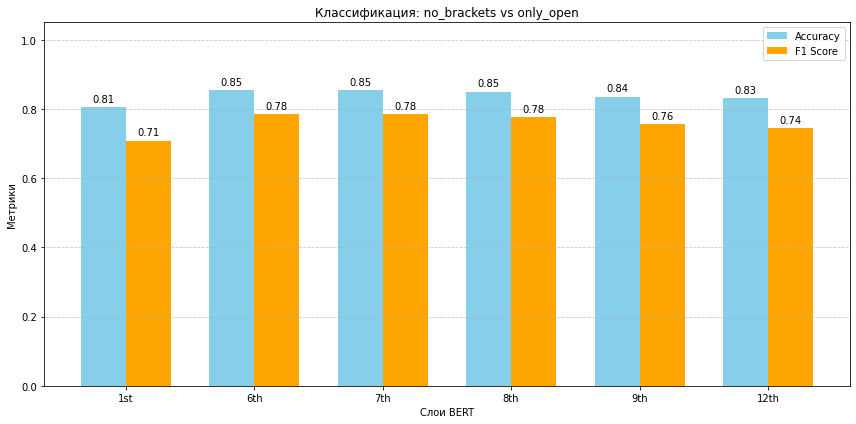


=== Классификация: no_brackets vs only_close ===

Слой 1st:
Accuracy: 0.8929
F1 Score: 0.5614

Слой 6th:
Accuracy: 0.9106
F1 Score: 0.6557

Слой 7th:
Accuracy: 0.9045
F1 Score: 0.6176

Слой 8th:
Accuracy: 0.9168
F1 Score: 0.6583

Слой 9th:
Accuracy: 0.9180
F1 Score: 0.6810

Слой 12th:
Accuracy: 0.9106
F1 Score: 0.6313


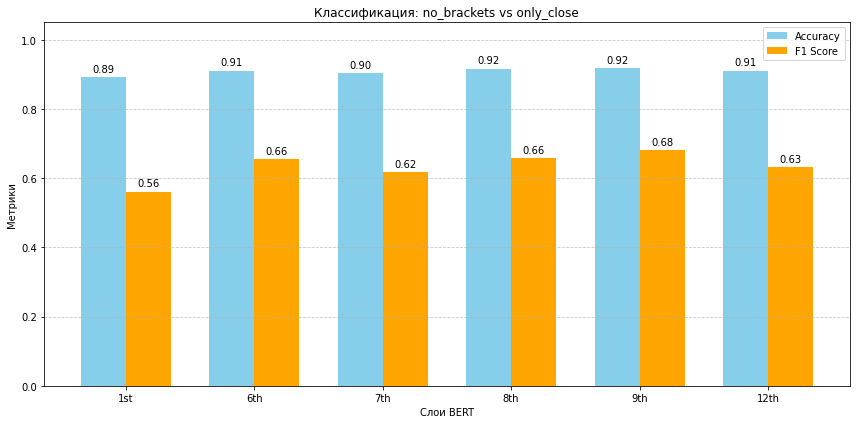


=== Классификация: no_brackets vs mixed ===

Слой 1st:
Accuracy: 0.8876
F1 Score: 0.5381

Слой 6th:
Accuracy: 0.9234
F1 Score: 0.6737

Слой 7th:
Accuracy: 0.9197
F1 Score: 0.6505

Слой 8th:
Accuracy: 0.9135
F1 Score: 0.6447

Слой 9th:
Accuracy: 0.9160
F1 Score: 0.6477

Слой 12th:
Accuracy: 0.9129
F1 Score: 0.6357


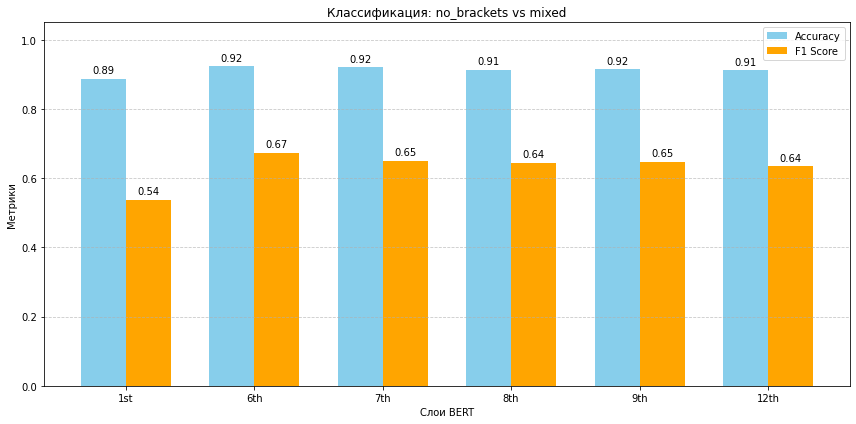


=== Классификация: only_open vs only_close ===

Слой 1st:
Accuracy: 0.8382
F1 Score: 0.6591

Слой 6th:
Accuracy: 0.9018
F1 Score: 0.7927

Слой 7th:
Accuracy: 0.9008
F1 Score: 0.7870

Слой 8th:
Accuracy: 0.8749
F1 Score: 0.7302

Слой 9th:
Accuracy: 0.8889
F1 Score: 0.7599

Слой 12th:
Accuracy: 0.8662
F1 Score: 0.6990


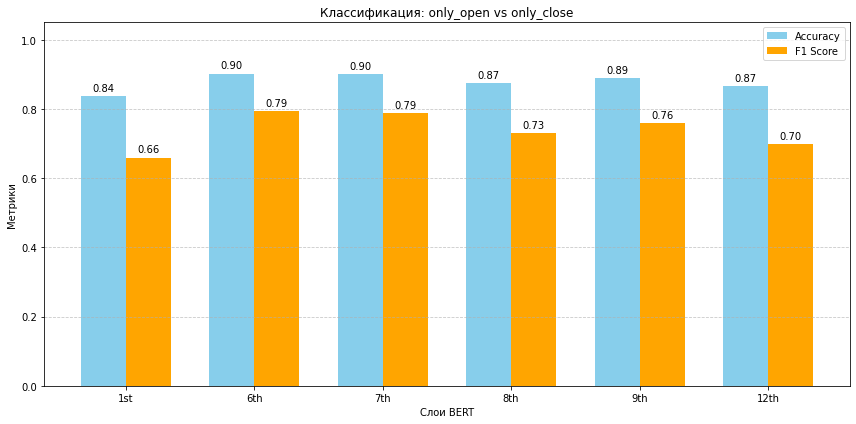


=== Классификация: only_open vs mixed ===

Слой 1st:
Accuracy: 0.7643
F1 Score: 0.3978

Слой 6th:
Accuracy: 0.8279
F1 Score: 0.5651

Слой 7th:
Accuracy: 0.8147
F1 Score: 0.5395

Слой 8th:
Accuracy: 0.8103
F1 Score: 0.5362

Слой 9th:
Accuracy: 0.8213
F1 Score: 0.5653

Слой 12th:
Accuracy: 0.8114
F1 Score: 0.5326


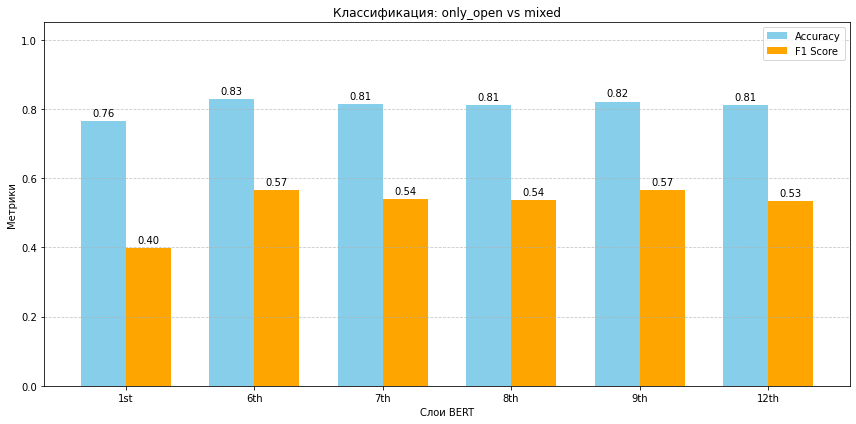


=== Классификация: only_close vs mixed ===

Слой 1st:
Accuracy: 0.6952
F1 Score: 0.6807

Слой 6th:
Accuracy: 0.7935
F1 Score: 0.7831

Слой 7th:
Accuracy: 0.7985
F1 Score: 0.7895

Слой 8th:
Accuracy: 0.7632
F1 Score: 0.7602

Слой 9th:
Accuracy: 0.7355
F1 Score: 0.7287

Слой 12th:
Accuracy: 0.7506
F1 Score: 0.7481


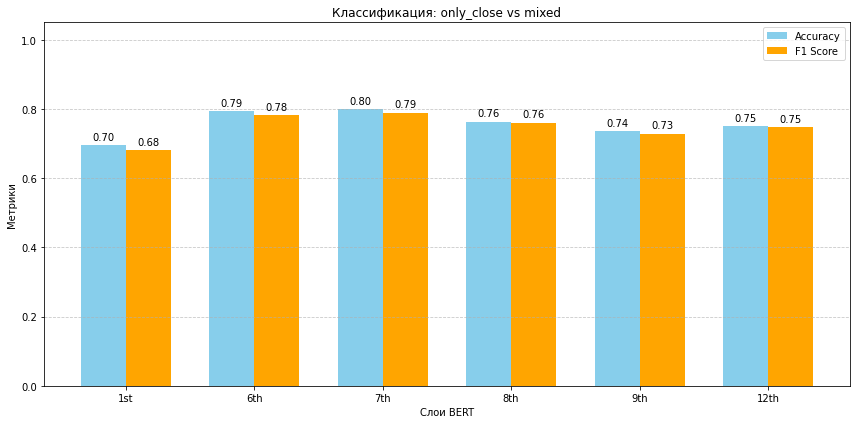

In [16]:
# Анализ для каждой пары классов
for pair_idx, (class1, class2) in enumerate(class_pairs):
    print(f"\n=== Классификация: {class1} vs {class2} ===")
    
    # Результаты для всех слоев
    pair_accuracies = []
    pair_f1_scores = []
    
    for layer in selected_layers:
        print(f"\nСлой {layer_names[layer]}:")
        
        # Фильтруем данные только для нужных классов
        X_layer = []
        y_layer = []
        
        for x, y in zip(X_all[layer], y_raw[layer]):
            if y == class1:
                X_layer.append(x)
                y_layer.append(0)  # Первый класс как 0
            elif y == class2:
                X_layer.append(x)
                y_layer.append(1)  # Второй класс как 1
        
        X_layer = np.array(X_layer)
        y_layer = np.array(y_layer)
        
        if len(X_layer) == 0 or len(np.unique(y_layer)) < 2:
            print("Недостаточно данных для этих классов")
            pair_accuracies.append(np.nan)
            pair_f1_scores.append(np.nan)
            continue
        
        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X_layer, y_layer, test_size=0.2, random_state=42
        )
        
        # Обучение и оценка
        accuracy, f1 = train_and_evaluate(
            X_train, X_test, y_train, y_test,
            layer_names[layer], f"{class1}_vs_{class2}"
        )
        
        pair_accuracies.append(accuracy)
        pair_f1_scores.append(f1)
    
    # Визуализация результатов для пары классов
    plt.figure(figsize=(12, 6))
    
    # Убираем слои с недостаточным количеством данных
    valid_layers = [i for i, acc in enumerate(pair_accuracies) if not np.isnan(acc)]
    valid_acc = [pair_accuracies[i] for i in valid_layers]
    valid_f1 = [pair_f1_scores[i] for i in valid_layers]
    valid_labels = [layer_names[selected_layers[i]] for i in valid_layers]
    
    # Позиции для столбиков
    x = np.arange(len(valid_labels))
    width = 0.35  # Ширина столбиков
    
    # Рисуем столбики accuracy и f1 рядом
    rects1 = plt.bar(x - width/2, valid_acc, width, label='Accuracy', color='skyblue')
    rects2 = plt.bar(x + width/2, valid_f1, width, label='F1 Score', color='orange')
    
    plt.xlabel('Слои BERT')
    plt.ylabel('Метрики')
    plt.title(f'Классификация: {class1} vs {class2}')
    plt.xticks(x, valid_labels)
    plt.ylim(0, 1.05)
    plt.legend()
    
    # Добавляем значения на график
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'classification_{class1}_vs_{class2}.png')
    plt.show()

In [29]:
!pip install plotly umap-learn
import plotly.express as px
from umap import UMAP

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
    tinycss2 (>=1.1.0<1.2) ; extra == 'css'
             ~~~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [33]:
# Цветовая схема для классов
color_map = {
    'no_brackets': 'green',
    'only_open': 'blue',
    'only_close': 'red',
    'mixed': 'purple'
}

# Визуализация для всех выбранных слоев в 3D
for layer in selected_layers:
    X_layer_viz = np.array(X_all[layer])
    y_layer_viz = np.array(y_raw[layer])
    
    if len(X_layer_viz) == 0:
        print(f"\nНет данных для визуализации слоя {layer_names[layer]}")
        continue
    
    print(f"\n=== 3D UMAP визуализация для слоя {layer_names[layer]} ===")
    
    # Применяем UMAP для уменьшения размерности до 3D
    reducer = UMAP(n_components=3, random_state=42)
    X_embedded = reducer.fit_transform(X_layer_viz)
    
    # Создаем DataFrame для визуализации
    df = pd.DataFrame(X_embedded, columns=['x', 'y', 'z'])
    df['class'] = y_layer_viz
    df['color'] = df['class'].map(color_map)
    
    # Создаем интерактивный 3D график
    fig = px.scatter_3d(
        df,
        x='x',
        y='y',
        z='z',
        color='class',
        color_discrete_map=color_map,
        title=f'3D UMAP проекция векторов скобок (слой {layer_names[layer]})',
        labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'z': 'UMAP 3'},
        opacity=0.8,
        size_max=10,
        hover_data=['class']
    )
    
    # Настраиваем отображение
    fig.update_traces(
        marker=dict(
            size=5,
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        selector=dict(mode='markers')
    )
    
    # Добавляем подписи и настройки
    fig.update_layout(
        legend_title_text='Тип скобок',
        scene=dict(
            xaxis_title='UMAP 1',
            yaxis_title='UMAP 2',
            zaxis_title='UMAP 3'
        ),
        width=1000,
        height=800,
        margin=dict(r=20, b=10, l=10, t=40)
    )
    
    # Сохраняем и показываем график
    fig.write_html(f"umap3d__layer_{layer}.html")
    #fig.show()
    
    print(f"Распределение классов для слоя {layer_names[layer]}:")
    print(df['class'].value_counts())


=== 3D UMAP визуализация для слоя 1st ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 1st:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 6th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 6th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 7th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 7th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 8th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 8th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 9th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 9th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 12th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 12th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64



=== Confusion Matrix Analysis: no_brackets vs only_open ===

Слой 1st:


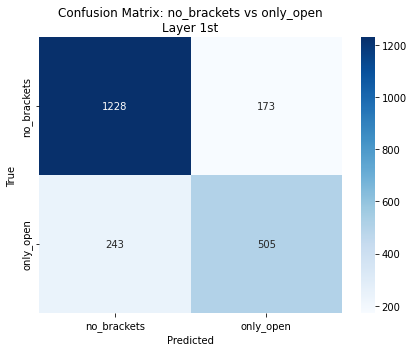

Всего примеров: 2149
Класс no_brackets: 1401
Класс only_open: 748

Матрица ошибок:
Правильно классифицированные no_brackets: 1228
Ошибочно классифицированные как only_open: 173
Ошибочно классифицированные как no_brackets: 243
Правильно классифицированные only_open: 505


Слой 6th:


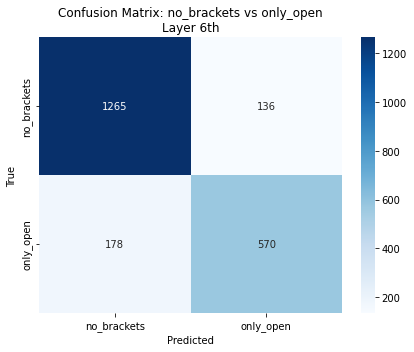

Всего примеров: 2149
Класс no_brackets: 1401
Класс only_open: 748

Матрица ошибок:
Правильно классифицированные no_brackets: 1265
Ошибочно классифицированные как only_open: 136
Ошибочно классифицированные как no_brackets: 178
Правильно классифицированные only_open: 570


Слой 12th:


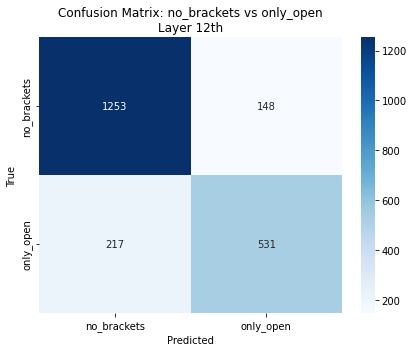

Всего примеров: 2149
Класс no_brackets: 1401
Класс only_open: 748

Матрица ошибок:
Правильно классифицированные no_brackets: 1253
Ошибочно классифицированные как only_open: 148
Ошибочно классифицированные как no_brackets: 217
Правильно классифицированные only_open: 531


=== Confusion Matrix Analysis: no_brackets vs only_close ===

Слой 1st:


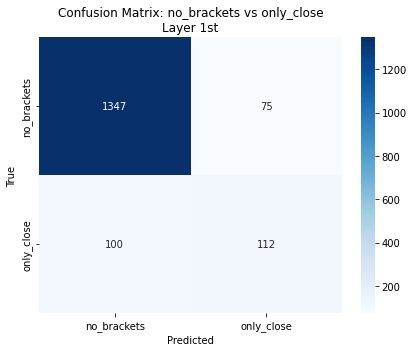

Всего примеров: 1634
Класс no_brackets: 1422
Класс only_close: 212

Матрица ошибок:
Правильно классифицированные no_brackets: 1347
Ошибочно классифицированные как only_close: 75
Ошибочно классифицированные как no_brackets: 100
Правильно классифицированные only_close: 112


Слой 6th:


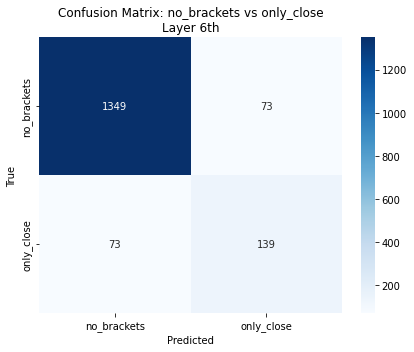

Всего примеров: 1634
Класс no_brackets: 1422
Класс only_close: 212

Матрица ошибок:
Правильно классифицированные no_brackets: 1349
Ошибочно классифицированные как only_close: 73
Ошибочно классифицированные как no_brackets: 73
Правильно классифицированные only_close: 139


Слой 12th:


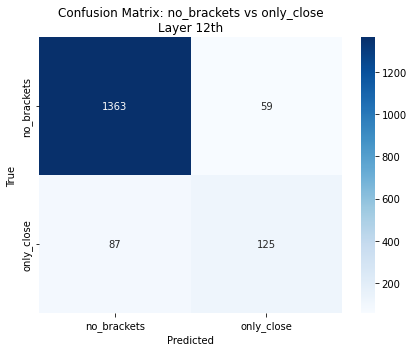

Всего примеров: 1634
Класс no_brackets: 1422
Класс only_close: 212

Матрица ошибок:
Правильно классифицированные no_brackets: 1363
Ошибочно классифицированные как only_close: 59
Ошибочно классифицированные как no_brackets: 87
Правильно классифицированные only_close: 125


=== Confusion Matrix Analysis: no_brackets vs mixed ===

Слой 1st:


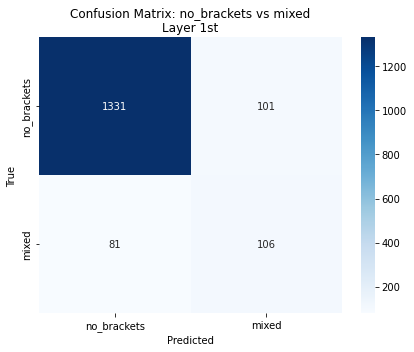

Всего примеров: 1619
Класс no_brackets: 1432
Класс mixed: 187

Матрица ошибок:
Правильно классифицированные no_brackets: 1331
Ошибочно классифицированные как mixed: 101
Ошибочно классифицированные как no_brackets: 81
Правильно классифицированные mixed: 106


Слой 6th:


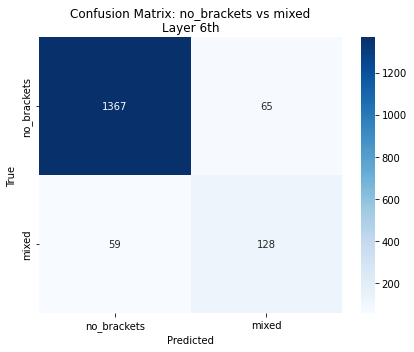

Всего примеров: 1619
Класс no_brackets: 1432
Класс mixed: 187

Матрица ошибок:
Правильно классифицированные no_brackets: 1367
Ошибочно классифицированные как mixed: 65
Ошибочно классифицированные как no_brackets: 59
Правильно классифицированные mixed: 128


Слой 12th:


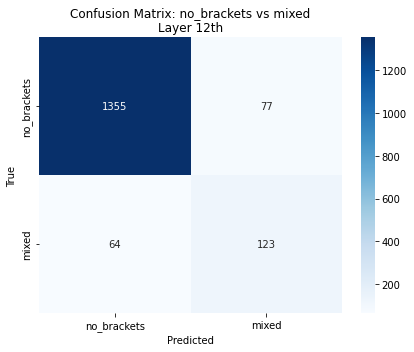

Всего примеров: 1619
Класс no_brackets: 1432
Класс mixed: 187

Матрица ошибок:
Правильно классифицированные no_brackets: 1355
Ошибочно классифицированные как mixed: 77
Ошибочно классифицированные как no_brackets: 64
Правильно классифицированные mixed: 123


=== Confusion Matrix Analysis: only_open vs only_close ===

Слой 1st:


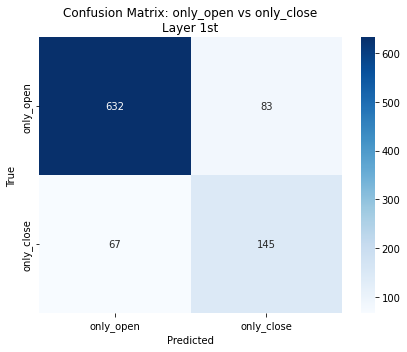

Всего примеров: 927
Класс only_open: 715
Класс only_close: 212

Матрица ошибок:
Правильно классифицированные only_open: 632
Ошибочно классифицированные как only_close: 83
Ошибочно классифицированные как only_open: 67
Правильно классифицированные only_close: 145


Слой 6th:


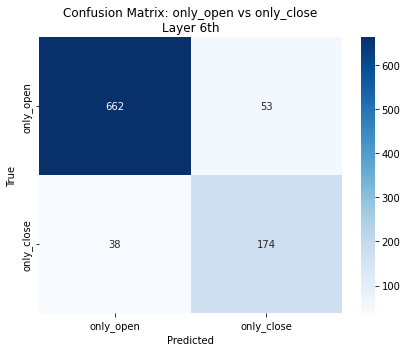

Всего примеров: 927
Класс only_open: 715
Класс only_close: 212

Матрица ошибок:
Правильно классифицированные only_open: 662
Ошибочно классифицированные как only_close: 53
Ошибочно классифицированные как only_open: 38
Правильно классифицированные only_close: 174


Слой 12th:


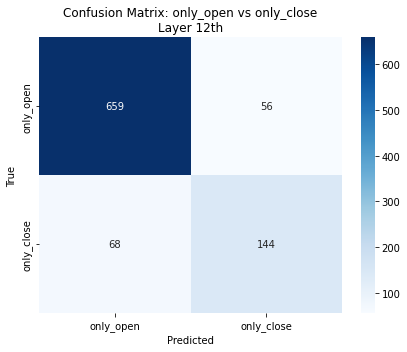

Всего примеров: 927
Класс only_open: 715
Класс only_close: 212

Матрица ошибок:
Правильно классифицированные only_open: 659
Ошибочно классифицированные как only_close: 56
Ошибочно классифицированные как only_open: 68
Правильно классифицированные only_close: 144


=== Confusion Matrix Analysis: only_open vs mixed ===

Слой 1st:


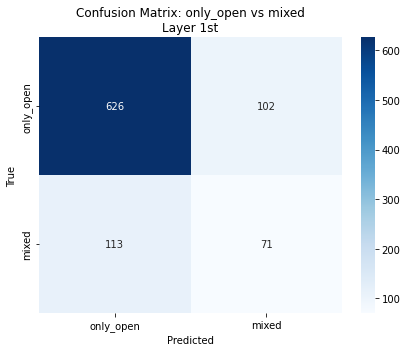

Всего примеров: 912
Класс only_open: 728
Класс mixed: 184

Матрица ошибок:
Правильно классифицированные only_open: 626
Ошибочно классифицированные как mixed: 102
Ошибочно классифицированные как only_open: 113
Правильно классифицированные mixed: 71


Слой 6th:


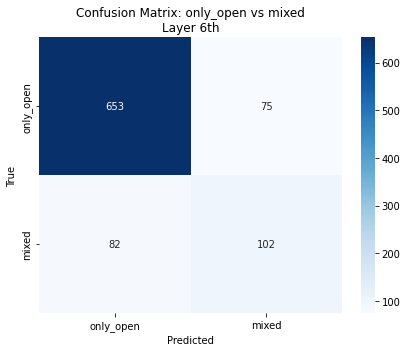

Всего примеров: 912
Класс only_open: 728
Класс mixed: 184

Матрица ошибок:
Правильно классифицированные only_open: 653
Ошибочно классифицированные как mixed: 75
Ошибочно классифицированные как only_open: 82
Правильно классифицированные mixed: 102


Слой 12th:


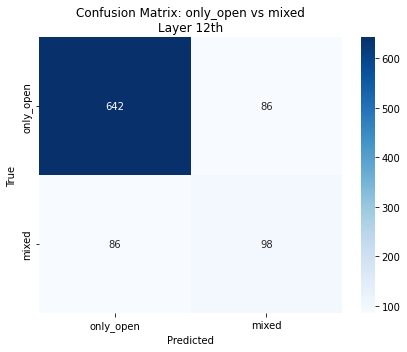

Всего примеров: 912
Класс only_open: 728
Класс mixed: 184

Матрица ошибок:
Правильно классифицированные only_open: 642
Ошибочно классифицированные как mixed: 86
Ошибочно классифицированные как only_open: 86
Правильно классифицированные mixed: 98


=== Confusion Matrix Analysis: only_close vs mixed ===

Слой 1st:


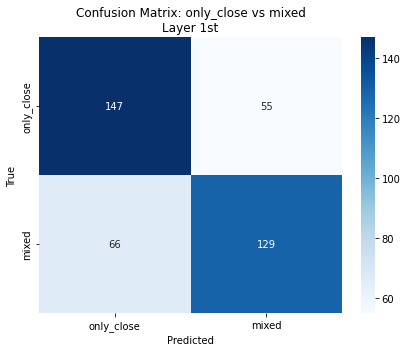

Всего примеров: 397
Класс only_close: 202
Класс mixed: 195

Матрица ошибок:
Правильно классифицированные only_close: 147
Ошибочно классифицированные как mixed: 55
Ошибочно классифицированные как only_close: 66
Правильно классифицированные mixed: 129


Слой 6th:


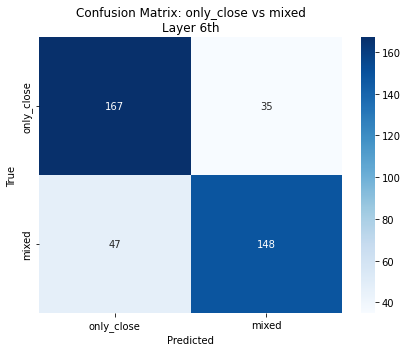

Всего примеров: 397
Класс only_close: 202
Класс mixed: 195

Матрица ошибок:
Правильно классифицированные only_close: 167
Ошибочно классифицированные как mixed: 35
Ошибочно классифицированные как only_close: 47
Правильно классифицированные mixed: 148


Слой 12th:


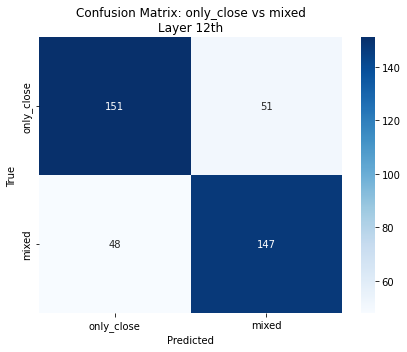

Всего примеров: 397
Класс only_close: 202
Класс mixed: 195

Матрица ошибок:
Правильно классифицированные only_close: 151
Ошибочно классифицированные как mixed: 51
Ошибочно классифицированные как only_close: 48
Правильно классифицированные mixed: 147



In [16]:
# Анализ confusion matrix для выбранных слоев (1, 6, 12)
selected_for_cm = [1, 6, 12]

for pair_idx, (class1, class2) in enumerate(class_pairs):
    print(f"\n=== Confusion Matrix Analysis: {class1} vs {class2} ===")
    
    for layer in selected_for_cm:
        print(f"\nСлой {layer_names[layer]}:")
        
        # Фильтруем данные только для нужных классов
        X_layer = []
        y_layer = []
        
        for x, y in zip(X_all[layer], y_raw[layer]):
            if y == class1:
                X_layer.append(x)
                y_layer.append(0)  # Первый класс как 0
            elif y == class2:
                X_layer.append(x)
                y_layer.append(1)  # Второй класс как 1
        
        X_layer = np.array(X_layer)
        y_layer = np.array(y_layer)
        
        if len(X_layer) == 0 or len(np.unique(y_layer)) < 2:
            print("Недостаточно данных для этих классов")
            continue
        
        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X_layer, y_layer, test_size=0.2, random_state=42
        )
        
        # Масштабирование и обучение
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_scaled, y_train)
        
        # Предсказания для confusion matrix
        y_pred = clf.predict(X_test_scaled)
        
        # Построение confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=[class1, class2], 
                    yticklabels=[class1, class2])
        plt.title(f'Confusion Matrix: {class1} vs {class2}\nLayer {layer_names[layer]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{class1}_vs_{class2}_layer{layer}.png')
        plt.show()
        
        # Вывод дополнительной информации
        print(f"Всего примеров: {len(y_test)}")
        print(f"Класс {class1}: {sum(y_test == 0)}")
        print(f"Класс {class2}: {sum(y_test == 1)}")
        print("\nМатрица ошибок:")
        print(f"Правильно классифицированные {class1}: {cm[0, 0]}")
        print(f"Ошибочно классифицированные как {class2}: {cm[0, 1]}")
        print(f"Ошибочно классифицированные как {class1}: {cm[1, 0]}")
        print(f"Правильно классифицированные {class2}: {cm[1, 1]}")
        print("\n" + "="*50)

In [17]:
import numpy as np
from sklearn.utils import shuffle

# Функция для аугментации данных
def augment_data(X, y, target_size=None):
    # Если target_size не указан, увеличиваем каждый класс в 2 раза
    if target_size is None:
        unique_classes, counts = np.unique(y, return_counts=True)
        target_size = max(counts) * 2  # Увеличиваем в 2 раза размер самого большого класса
    
    X_augmented = []
    y_augmented = []
    
    for class_label in np.unique(y):
        # Выбираем все примеры текущего класса
        class_indices = np.where(y == class_label)[0]
        X_class = X[class_indices]
        y_class = y[class_indices]
        
        # Вычисляем сколько примеров нужно добавить
        current_size = len(X_class)
        needed = target_size - current_size
        
        if needed <= 0:
            # Если класс уже достаточно большой, просто добавляем существующие данные
            X_augmented.append(X_class)
            y_augmented.append(y_class)
            continue
        
        # Создаем новые примеры
        new_X = []
        for _ in range(needed):
            # Выбираем случайный пример из класса
            idx = np.random.choice(class_indices)
            original_vec = X[idx]
            
            # Создаем случайный вектор и нормализуем
            random_vec = np.random.randn(*original_vec.shape)
            random_vec = random_vec / np.linalg.norm(random_vec)
            
            # Добавляем небольшой шум к оригинальному вектору
            noisy_vec = original_vec + random_vec * 1e-9
            new_X.append(noisy_vec)
        
        # Объединяем оригинальные и новые примеры
        X_augmented.append(np.vstack([X_class, np.array(new_X)]))
        y_augmented.append(np.hstack([y_class, np.array([class_label]*needed)]))
    
    # Объединяем все классы и перемешиваем
    X_final = np.vstack(X_augmented)
    y_final = np.hstack(y_augmented)
    return shuffle(X_final, y_final, random_state=42)

# Аугментация данных для каждого слоя
X_all_augmented = {}
y_raw_augmented = {}

for layer in selected_layers:
    # Преобразуем в numpy массивы
    X_np = np.array(X_all[layer])
    y_np = np.array(y_raw[layer])
    
    # Аугментируем данные
    X_aug, y_aug = augment_data(X_np, y_np)
    X_all_augmented[layer] = X_aug
    y_raw_augmented[layer] = y_aug
    
    # Проверяем баланс классов после аугментации
    unique, counts = np.unique(y_aug, return_counts=True)
    print(f"\nСлой {layer_names[layer]} - распределение классов после аугментации:")
    for cls, cnt in zip(unique, counts):
        print(f"{cls}: {cnt} примеров")



Слой 1st - распределение классов после аугментации:
mixed: 14276 примеров
no_brackets: 14276 примеров
only_close: 14276 примеров
only_open: 14276 примеров

Слой 6th - распределение классов после аугментации:
mixed: 14276 примеров
no_brackets: 14276 примеров
only_close: 14276 примеров
only_open: 14276 примеров

Слой 7th - распределение классов после аугментации:
mixed: 14276 примеров
no_brackets: 14276 примеров
only_close: 14276 примеров
only_open: 14276 примеров

Слой 8th - распределение классов после аугментации:
mixed: 14276 примеров
no_brackets: 14276 примеров
only_close: 14276 примеров
only_open: 14276 примеров

Слой 9th - распределение классов после аугментации:
mixed: 14276 примеров
no_brackets: 14276 примеров
only_close: 14276 примеров
only_open: 14276 примеров

Слой 12th - распределение классов после аугментации:
mixed: 14276 примеров
no_brackets: 14276 примеров
only_close: 14276 примеров
only_open: 14276 примеров



=== Классификация с аугментированными данными: no_brackets vs only_open ===

Слой 1st:
Accuracy: 0.8202
F1 Score: 0.8230

Слой 6th:
Accuracy: 0.8750
F1 Score: 0.8761

Слой 7th:
Accuracy: 0.8724
F1 Score: 0.8732

Слой 8th:
Accuracy: 0.8690
F1 Score: 0.8705

Слой 9th:
Accuracy: 0.8792
F1 Score: 0.8795

Слой 12th:
Accuracy: 0.8548
F1 Score: 0.8562


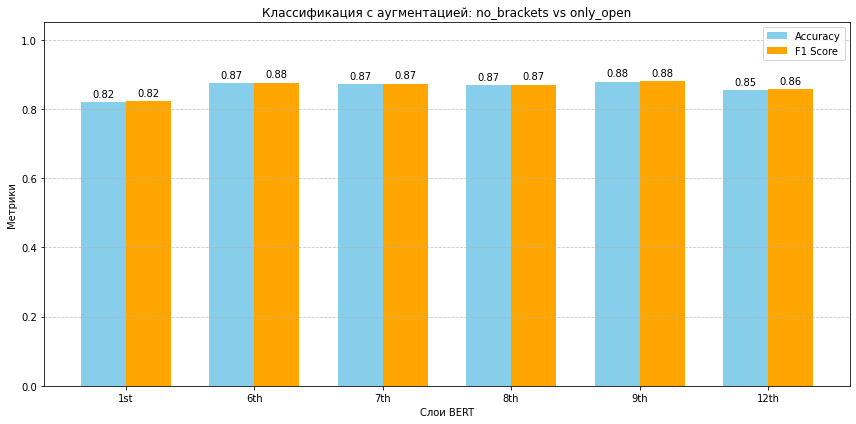


=== Классификация с аугментированными данными: no_brackets vs only_close ===

Слой 1st:
Accuracy: 0.8881
F1 Score: 0.8903

Слой 6th:
Accuracy: 0.9312
F1 Score: 0.9328

Слой 7th:
Accuracy: 0.9392
F1 Score: 0.9413

Слой 8th:
Accuracy: 0.9328
F1 Score: 0.9350

Слой 9th:
Accuracy: 0.9319
F1 Score: 0.9336

Слой 12th:
Accuracy: 0.9186
F1 Score: 0.9199


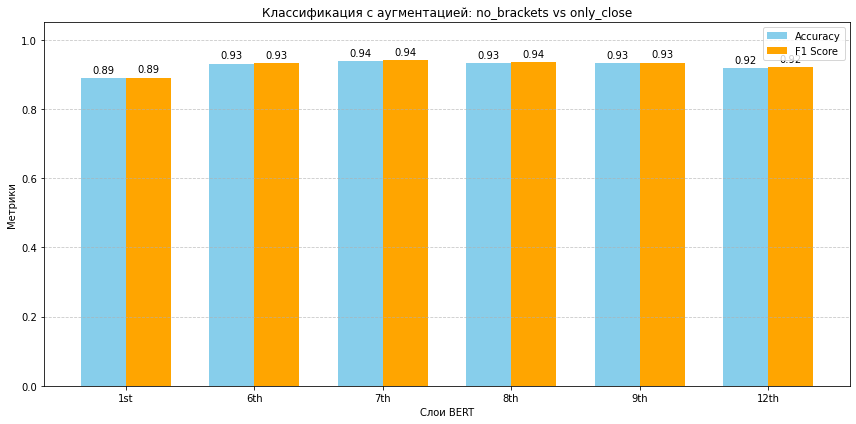


=== Классификация с аугментированными данными: no_brackets vs mixed ===

Слой 1st:
Accuracy: 0.9342
F1 Score: 0.9356

Слой 6th:
Accuracy: 0.9655
F1 Score: 0.9660

Слой 7th:
Accuracy: 0.9730
F1 Score: 0.9737

Слой 8th:
Accuracy: 0.9727
F1 Score: 0.9733

Слой 9th:
Accuracy: 0.9701
F1 Score: 0.9708

Слой 12th:
Accuracy: 0.9504
F1 Score: 0.9513


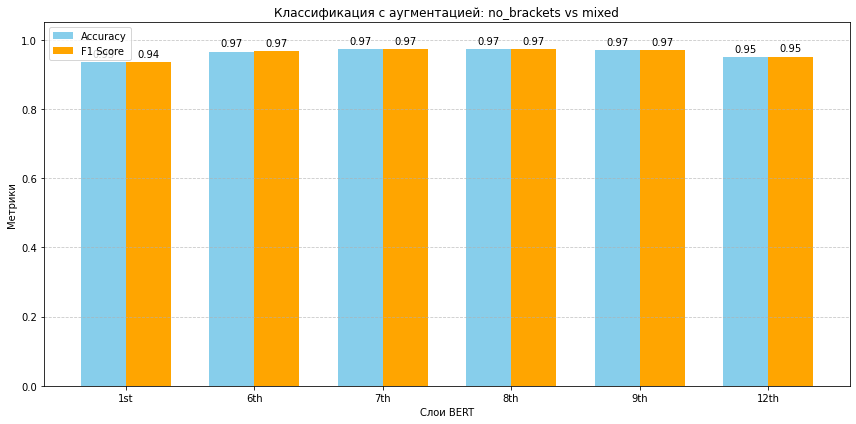


=== Классификация с аугментированными данными: only_open vs only_close ===

Слой 1st:
Accuracy: 0.9140
F1 Score: 0.9137

Слой 6th:
Accuracy: 0.9958
F1 Score: 0.9957

Слой 7th:
Accuracy: 0.9970
F1 Score: 0.9970

Слой 8th:
Accuracy: 0.9953
F1 Score: 0.9952

Слой 9th:
Accuracy: 0.9958
F1 Score: 0.9957

Слой 12th:
Accuracy: 0.9793
F1 Score: 0.9791


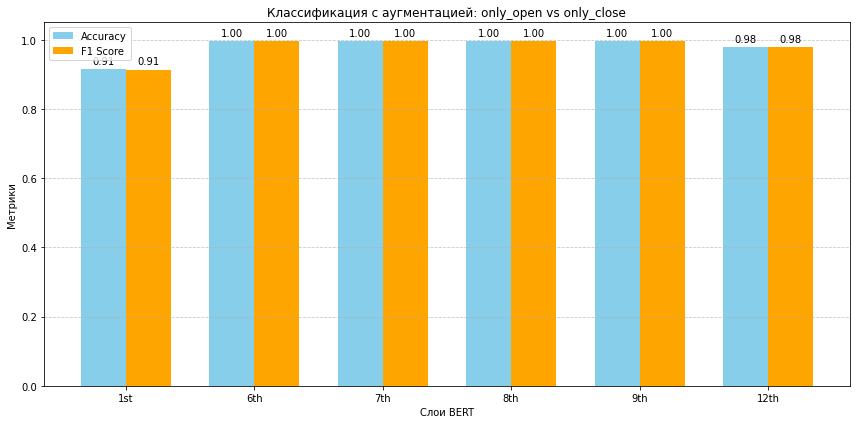


=== Классификация с аугментированными данными: only_open vs mixed ===

Слой 1st:
Accuracy: 0.8435
F1 Score: 0.8466

Слой 6th:
Accuracy: 0.9170
F1 Score: 0.9177

Слой 7th:
Accuracy: 0.9181
F1 Score: 0.9198

Слой 8th:
Accuracy: 0.9032
F1 Score: 0.9047

Слой 9th:
Accuracy: 0.9070
F1 Score: 0.9088

Слой 12th:
Accuracy: 0.8923
F1 Score: 0.8944


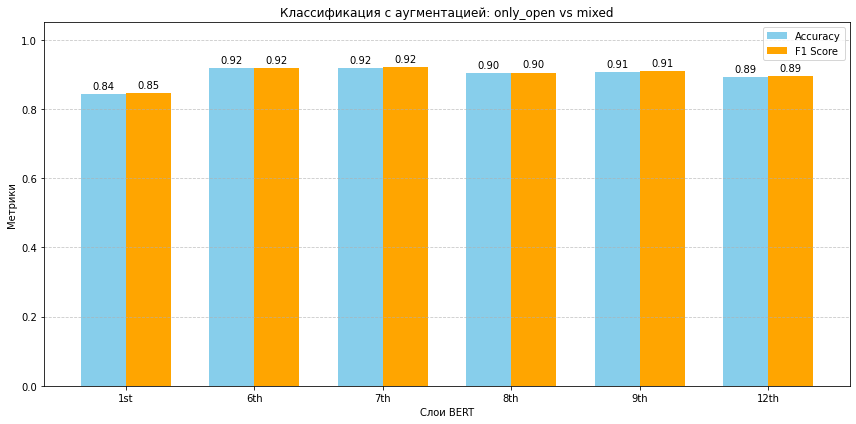


=== Классификация с аугментированными данными: only_close vs mixed ===

Слой 1st:
Accuracy: 0.9940
F1 Score: 0.9941

Слой 6th:
Accuracy: 1.0000
F1 Score: 1.0000

Слой 7th:
Accuracy: 1.0000
F1 Score: 1.0000

Слой 8th:
Accuracy: 1.0000
F1 Score: 1.0000

Слой 9th:
Accuracy: 1.0000
F1 Score: 1.0000

Слой 12th:
Accuracy: 1.0000
F1 Score: 1.0000


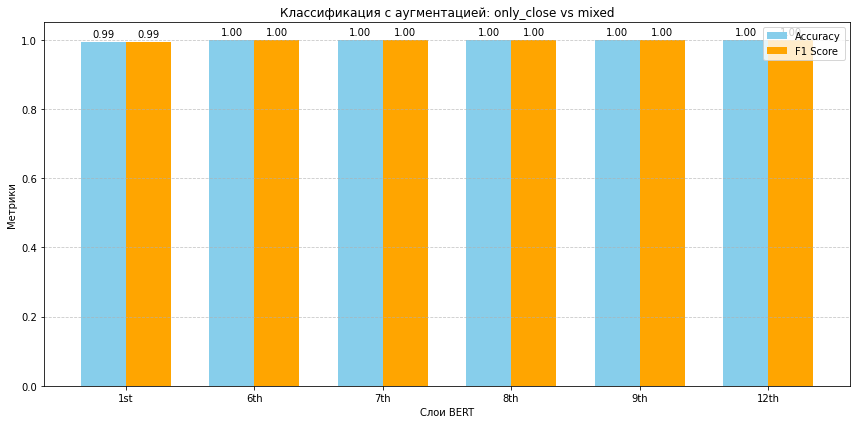


=== Confusion Matrix Analysis with Augmented Data: no_brackets vs only_open ===

Слой 1st:


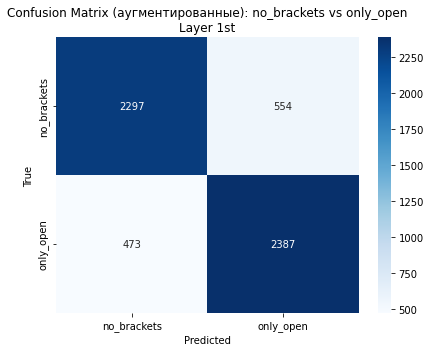

Всего примеров: 5711
Класс no_brackets: 2851
Класс only_open: 2860

Матрица ошибок:
Правильно классифицированные no_brackets: 2297
Ошибочно классифицированные как only_open: 554
Ошибочно классифицированные как no_brackets: 473
Правильно классифицированные only_open: 2387


Слой 6th:


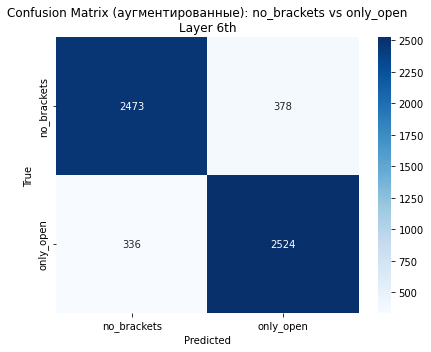

Всего примеров: 5711
Класс no_brackets: 2851
Класс only_open: 2860

Матрица ошибок:
Правильно классифицированные no_brackets: 2473
Ошибочно классифицированные как only_open: 378
Ошибочно классифицированные как no_brackets: 336
Правильно классифицированные only_open: 2524


Слой 12th:


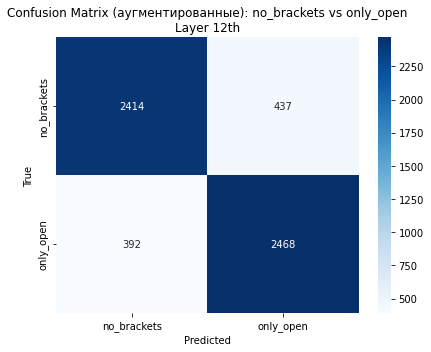

Всего примеров: 5711
Класс no_brackets: 2851
Класс only_open: 2860

Матрица ошибок:
Правильно классифицированные no_brackets: 2414
Ошибочно классифицированные как only_open: 437
Ошибочно классифицированные как no_brackets: 392
Правильно классифицированные only_open: 2468


=== Confusion Matrix Analysis with Augmented Data: no_brackets vs only_close ===

Слой 1st:


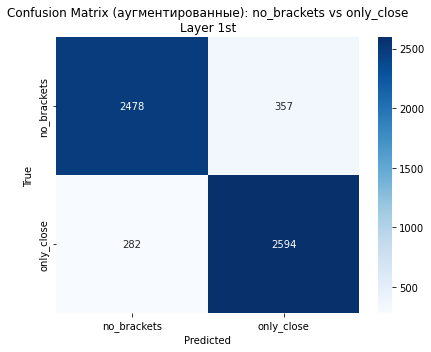

Всего примеров: 5711
Класс no_brackets: 2835
Класс only_close: 2876

Матрица ошибок:
Правильно классифицированные no_brackets: 2478
Ошибочно классифицированные как only_close: 357
Ошибочно классифицированные как no_brackets: 282
Правильно классифицированные only_close: 2594


Слой 6th:


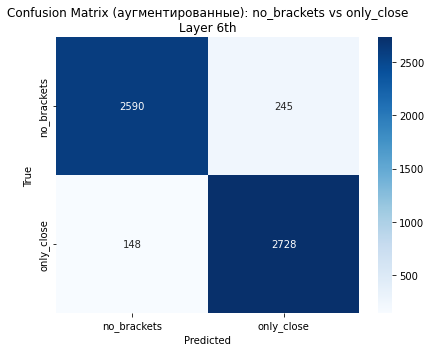

Всего примеров: 5711
Класс no_brackets: 2835
Класс only_close: 2876

Матрица ошибок:
Правильно классифицированные no_brackets: 2590
Ошибочно классифицированные как only_close: 245
Ошибочно классифицированные как no_brackets: 148
Правильно классифицированные only_close: 2728


Слой 12th:


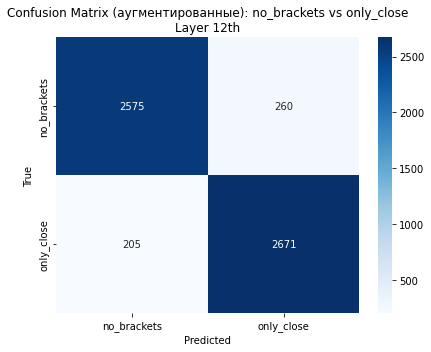

Всего примеров: 5711
Класс no_brackets: 2835
Класс only_close: 2876

Матрица ошибок:
Правильно классифицированные no_brackets: 2575
Ошибочно классифицированные как only_close: 260
Ошибочно классифицированные как no_brackets: 205
Правильно классифицированные only_close: 2671


=== Confusion Matrix Analysis with Augmented Data: no_brackets vs mixed ===

Слой 1st:


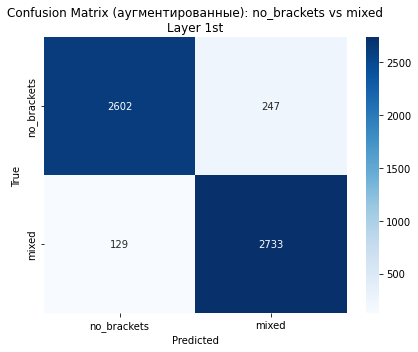

Всего примеров: 5711
Класс no_brackets: 2849
Класс mixed: 2862

Матрица ошибок:
Правильно классифицированные no_brackets: 2602
Ошибочно классифицированные как mixed: 247
Ошибочно классифицированные как no_brackets: 129
Правильно классифицированные mixed: 2733


Слой 6th:


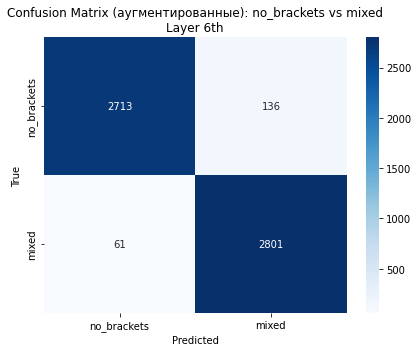

Всего примеров: 5711
Класс no_brackets: 2849
Класс mixed: 2862

Матрица ошибок:
Правильно классифицированные no_brackets: 2713
Ошибочно классифицированные как mixed: 136
Ошибочно классифицированные как no_brackets: 61
Правильно классифицированные mixed: 2801


Слой 12th:


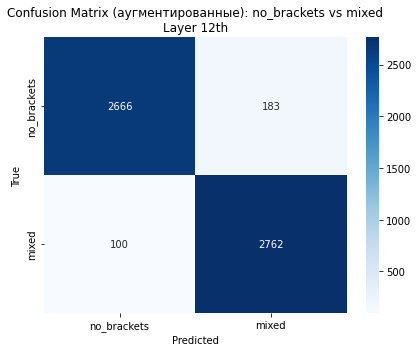

Всего примеров: 5711
Класс no_brackets: 2849
Класс mixed: 2862

Матрица ошибок:
Правильно классифицированные no_brackets: 2666
Ошибочно классифицированные как mixed: 183
Ошибочно классифицированные как no_brackets: 100
Правильно классифицированные mixed: 2762


=== Confusion Matrix Analysis with Augmented Data: only_open vs only_close ===

Слой 1st:


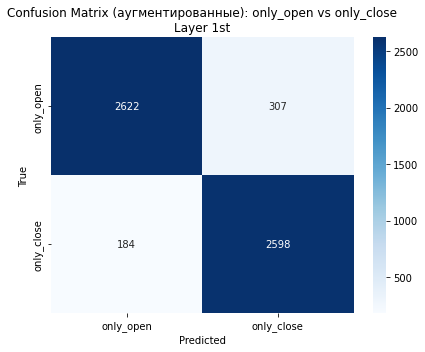

Всего примеров: 5711
Класс only_open: 2929
Класс only_close: 2782

Матрица ошибок:
Правильно классифицированные only_open: 2622
Ошибочно классифицированные как only_close: 307
Ошибочно классифицированные как only_open: 184
Правильно классифицированные only_close: 2598


Слой 6th:


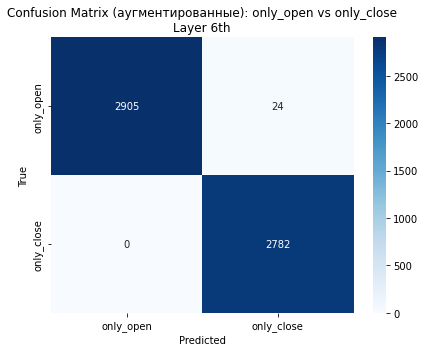

Всего примеров: 5711
Класс only_open: 2929
Класс only_close: 2782

Матрица ошибок:
Правильно классифицированные only_open: 2905
Ошибочно классифицированные как only_close: 24
Ошибочно классифицированные как only_open: 0
Правильно классифицированные only_close: 2782


Слой 12th:


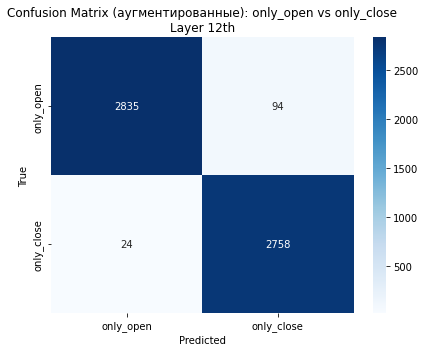

Всего примеров: 5711
Класс only_open: 2929
Класс only_close: 2782

Матрица ошибок:
Правильно классифицированные only_open: 2835
Ошибочно классифицированные как only_close: 94
Ошибочно классифицированные как only_open: 24
Правильно классифицированные only_close: 2758


=== Confusion Matrix Analysis with Augmented Data: only_open vs mixed ===

Слой 1st:


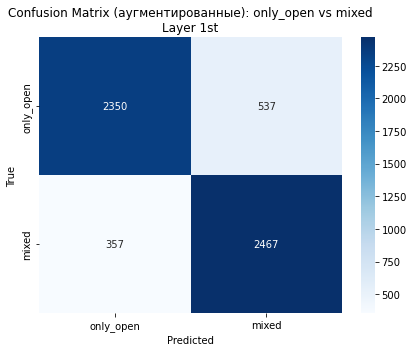

Всего примеров: 5711
Класс only_open: 2887
Класс mixed: 2824

Матрица ошибок:
Правильно классифицированные only_open: 2350
Ошибочно классифицированные как mixed: 537
Ошибочно классифицированные как only_open: 357
Правильно классифицированные mixed: 2467


Слой 6th:


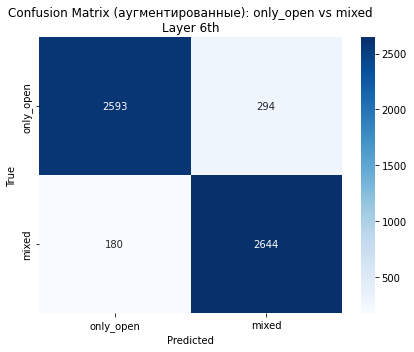

Всего примеров: 5711
Класс only_open: 2887
Класс mixed: 2824

Матрица ошибок:
Правильно классифицированные only_open: 2593
Ошибочно классифицированные как mixed: 294
Ошибочно классифицированные как only_open: 180
Правильно классифицированные mixed: 2644


Слой 12th:


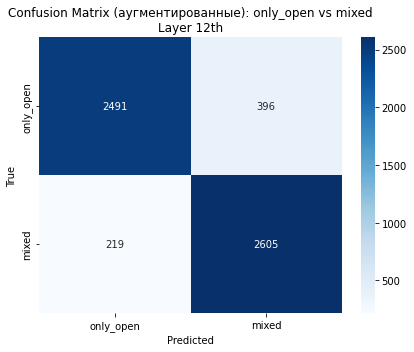

Всего примеров: 5711
Класс only_open: 2887
Класс mixed: 2824

Матрица ошибок:
Правильно классифицированные only_open: 2491
Ошибочно классифицированные как mixed: 396
Ошибочно классифицированные как only_open: 219
Правильно классифицированные mixed: 2605


=== Confusion Matrix Analysis with Augmented Data: only_close vs mixed ===

Слой 1st:


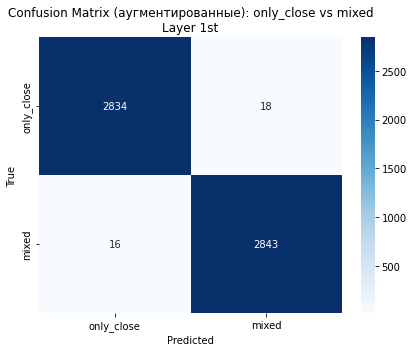

Всего примеров: 5711
Класс only_close: 2852
Класс mixed: 2859

Матрица ошибок:
Правильно классифицированные only_close: 2834
Ошибочно классифицированные как mixed: 18
Ошибочно классифицированные как only_close: 16
Правильно классифицированные mixed: 2843


Слой 6th:


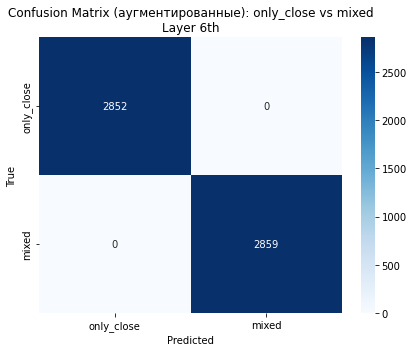

Всего примеров: 5711
Класс only_close: 2852
Класс mixed: 2859

Матрица ошибок:
Правильно классифицированные only_close: 2852
Ошибочно классифицированные как mixed: 0
Ошибочно классифицированные как only_close: 0
Правильно классифицированные mixed: 2859


Слой 12th:


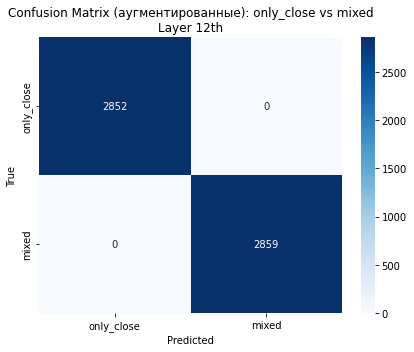

Всего примеров: 5711
Класс only_close: 2852
Класс mixed: 2859

Матрица ошибок:
Правильно классифицированные only_close: 2852
Ошибочно классифицированные как mixed: 0
Ошибочно классифицированные как only_close: 0
Правильно классифицированные mixed: 2859



In [18]:
# Повторяем анализ с аугментированными данными
for pair_idx, (class1, class2) in enumerate(class_pairs):
    print(f"\n=== Классификация с аугментированными данными: {class1} vs {class2} ===")
    
    # Результаты для всех слоев
    pair_accuracies = []
    pair_f1_scores = []
    
    for layer in selected_layers:
        print(f"\nСлой {layer_names[layer]}:")
        
        # Фильтруем данные только для нужных классов
        X_layer = []
        y_layer = []
        
        for x, y in zip(X_all_augmented[layer], y_raw_augmented[layer]):
            if y == class1:
                X_layer.append(x)
                y_layer.append(0)  # Первый класс как 0
            elif y == class2:
                X_layer.append(x)
                y_layer.append(1)  # Второй класс как 1
        
        X_layer = np.array(X_layer)
        y_layer = np.array(y_layer)
        
        if len(X_layer) == 0 or len(np.unique(y_layer)) < 2:
            print("Недостаточно данных для этих классов")
            pair_accuracies.append(np.nan)
            pair_f1_scores.append(np.nan)
            continue
        
        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X_layer, y_layer, test_size=0.2, random_state=42
        )
        
        # Обучение и оценка
        accuracy, f1 = train_and_evaluate(
            X_train, X_test, y_train, y_test,
            layer_names[layer], f"{class1}_vs_{class2}"
        )
        
        pair_accuracies.append(accuracy)
        pair_f1_scores.append(f1)
    
    # Визуализация результатов для пары классов
    plt.figure(figsize=(12, 6))
    
    # Убираем слои с недостаточным количеством данных
    valid_layers = [i for i, acc in enumerate(pair_accuracies) if not np.isnan(acc)]
    valid_acc = [pair_accuracies[i] for i in valid_layers]
    valid_f1 = [pair_f1_scores[i] for i in valid_layers]
    valid_labels = [layer_names[selected_layers[i]] for i in valid_layers]
    
    # Позиции для столбиков
    x = np.arange(len(valid_labels))
    width = 0.35  # Ширина столбиков
    
    # Рисуем столбики accuracy и f1 рядом
    rects1 = plt.bar(x - width/2, valid_acc, width, label='Accuracy', color='skyblue')
    rects2 = plt.bar(x + width/2, valid_f1, width, label='F1 Score', color='orange')
    
    plt.xlabel('Слои BERT')
    plt.ylabel('Метрики')
    plt.title(f'Классификация с аугментацией: {class1} vs {class2}')
    plt.xticks(x, valid_labels)
    plt.ylim(0, 1.05)
    plt.legend()
    
    # Добавляем значения на график
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'classification_augmented_{class1}_vs_{class2}.png')
    plt.show()

# Confusion matrix для аугментированных данных (слои 1, 6, 12)
selected_for_cm = [1, 6, 12]

for pair_idx, (class1, class2) in enumerate(class_pairs):
    print(f"\n=== Confusion Matrix Analysis with Augmented Data: {class1} vs {class2} ===")
    
    for layer in selected_for_cm:
        print(f"\nСлой {layer_names[layer]}:")
        
        # Фильтруем данные только для нужных классов
        X_layer = []
        y_layer = []
        
        for x, y in zip(X_all_augmented[layer], y_raw_augmented[layer]):
            if y == class1:
                X_layer.append(x)
                y_layer.append(0)  # Первый класс как 0
            elif y == class2:
                X_layer.append(x)
                y_layer.append(1)  # Второй класс как 1
        
        X_layer = np.array(X_layer)
        y_layer = np.array(y_layer)
        
        if len(X_layer) == 0 or len(np.unique(y_layer)) < 2:
            print("Недостаточно данных для этих классов")
            continue
        
        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X_layer, y_layer, test_size=0.2, random_state=42
        )
        
        # Масштабирование и обучение
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_scaled, y_train)
        
        # Предсказания для confusion matrix
        y_pred = clf.predict(X_test_scaled)
        
        # Построение confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=[class1, class2], 
                    yticklabels=[class1, class2])
        plt.title(f'Confusion Matrix (аугментированные): {class1} vs {class2}\nLayer {layer_names[layer]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_augmented_{class1}_vs_{class2}_layer{layer}.png')
        plt.show()
        
        # Вывод дополнительной информации
        print(f"Всего примеров: {len(y_test)}")
        print(f"Класс {class1}: {sum(y_test == 0)}")
        print(f"Класс {class2}: {sum(y_test == 1)}")
        print("\nМатрица ошибок:")
        print(f"Правильно классифицированные {class1}: {cm[0, 0]}")
        print(f"Ошибочно классифицированные как {class2}: {cm[0, 1]}")
        print(f"Ошибочно классифицированные как {class1}: {cm[1, 0]}")
        print(f"Правильно классифицированные {class2}: {cm[1, 1]}")
        print("\n" + "="*50)


=== UMAP визуализация для слоя 1st ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


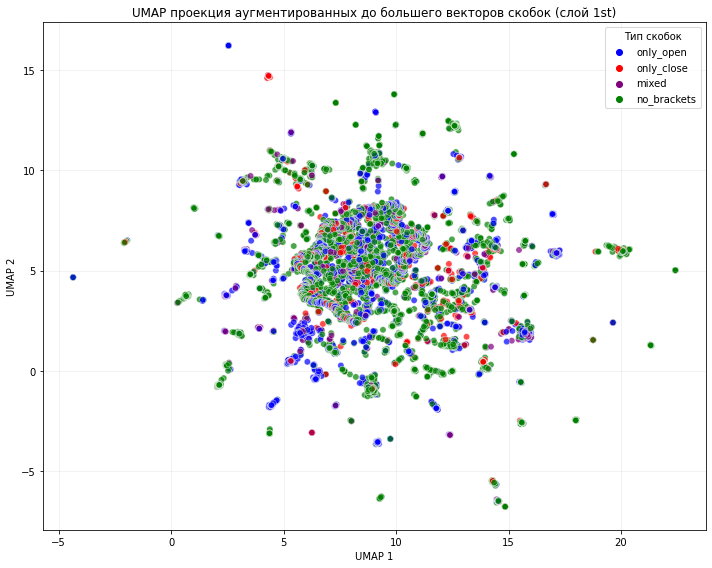

Распределение классов для слоя 1st:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 6th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


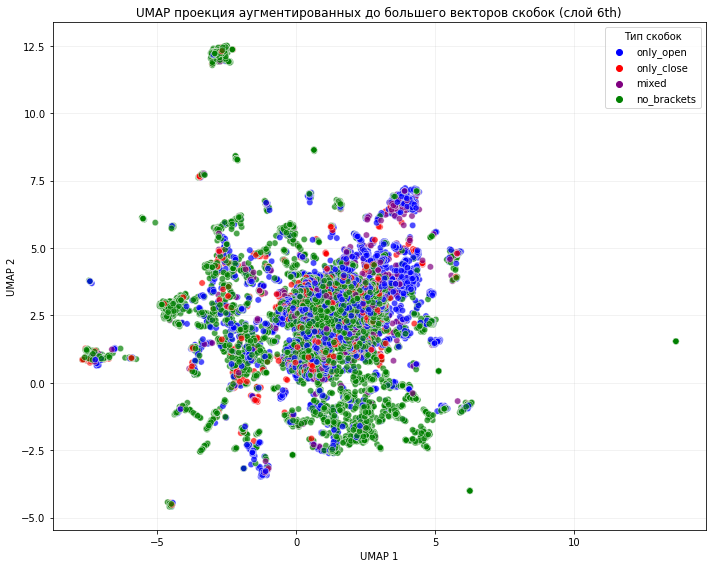

Распределение классов для слоя 6th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 7th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


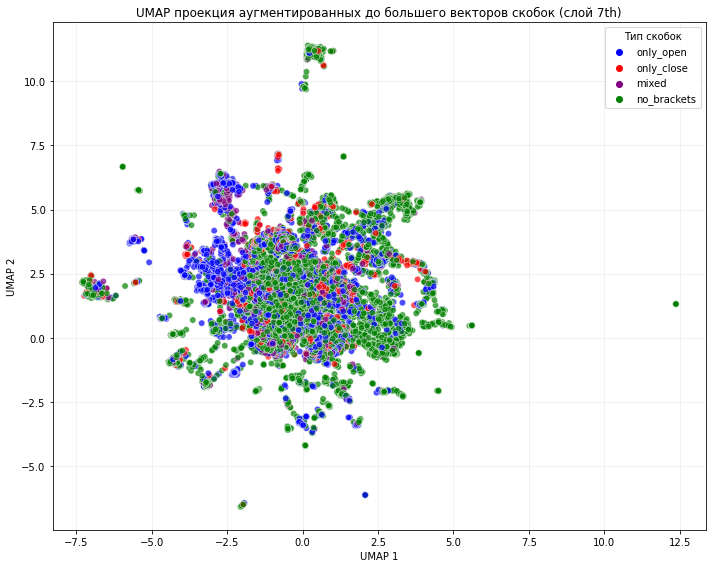

Распределение классов для слоя 7th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 8th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


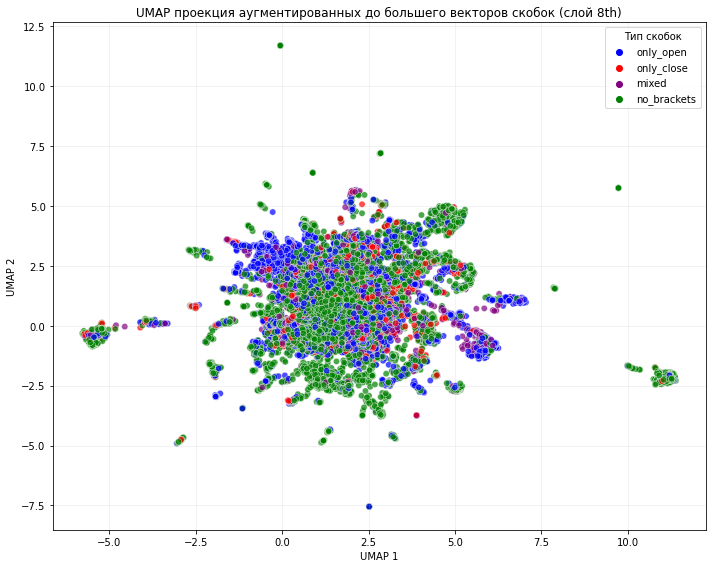

Распределение классов для слоя 8th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 9th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


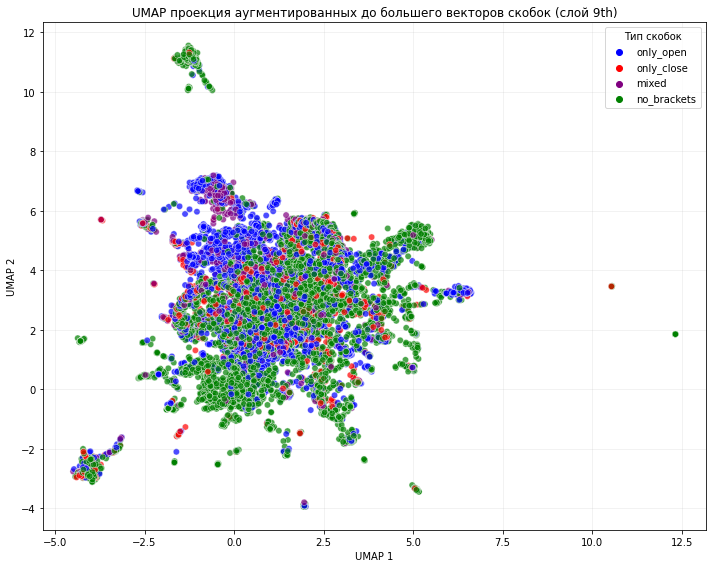

Распределение классов для слоя 9th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 12th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


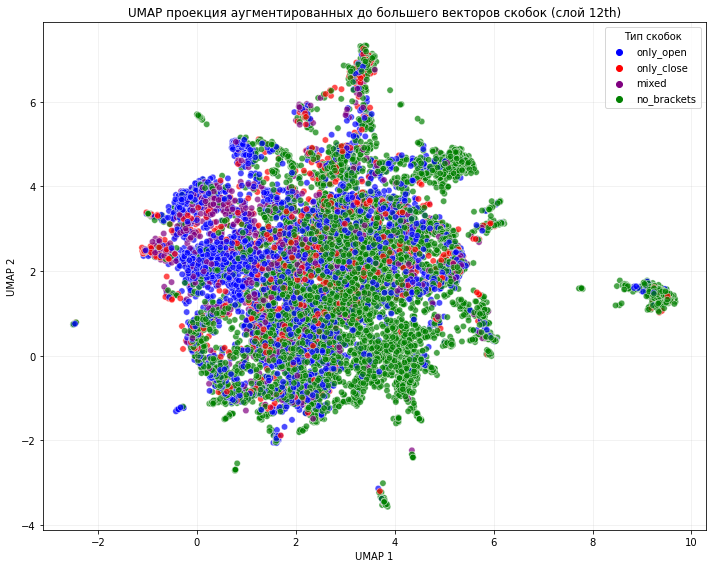

Распределение классов для слоя 12th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64


In [26]:
color_map = {
    'no_brackets': 'green',
    'only_open': 'blue',
    'only_close': 'red',
    'mixed': 'purple'
}
# Визуализация для всех выбранных слоев
for layer in selected_layers:
    X_layer_viz = np.array(X_all[layer])
    y_layer_viz = np.array(y_raw[layer])
    
    if len(X_layer_viz) == 0:
        print(f"\nНет данных для визуализации слоя {layer_names[layer]}")
        continue
    
    print(f"\n=== UMAP визуализация для слоя {layer_names[layer]} ===")
    
    reducer = UMAP(random_state=42)
    X_embedded = reducer.fit_transform(X_layer_viz)
    
    df = pd.DataFrame(X_embedded, columns=['x', 'y'])
    df['class'] = y_layer_viz
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df,
        x='x',
        y='y',
        hue='class',
        palette=color_map,
        alpha=0.7,
        s=40
    )
    
    plt.title(f'UMAP проекция аугментированных до большего векторов скобок (слой {layer_names[layer]})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(title='Тип скобок')
    plt.grid(alpha=0.2)
    
    plt.tight_layout()
    plt.savefig(f'umap_augmax_visualization_layer_{layer}.png')
    plt.show()
    
    print(f"Распределение классов для слоя {layer_names[layer]}:")
    print(df['class'].value_counts())

In [34]:
# Цветовая схема для классов
color_map = {
    'no_brackets': 'green',
    'only_open': 'blue',
    'only_close': 'red',
    'mixed': 'purple'
}

# Визуализация для всех выбранных слоев в 3D
for layer in selected_layers:
    X_layer_viz = np.array(X_all[layer])
    y_layer_viz = np.array(y_raw[layer])
    
    if len(X_layer_viz) == 0:
        print(f"\nНет данных для визуализации слоя {layer_names[layer]}")
        continue
    
    print(f"\n=== 3D UMAP визуализация для слоя {layer_names[layer]} ===")
    
    # Применяем UMAP для уменьшения размерности до 3D
    reducer = UMAP(n_components=3, random_state=42)
    X_embedded = reducer.fit_transform(X_layer_viz)
    
    # Создаем DataFrame для визуализации
    df = pd.DataFrame(X_embedded, columns=['x', 'y', 'z'])
    df['class'] = y_layer_viz
    df['color'] = df['class'].map(color_map)
    
    # Создаем интерактивный 3D график
    fig = px.scatter_3d(
        df,
        x='x',
        y='y',
        z='z',
        color='class',
        color_discrete_map=color_map,
        title=f'3D UMAP проекция аугментированных векторов скобок (слой {layer_names[layer]})',
        labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'z': 'UMAP 3'},
        opacity=0.8,
        size_max=10,
        hover_data=['class']
    )
    
    # Настраиваем отображение
    fig.update_traces(
        marker=dict(
            size=5,
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        selector=dict(mode='markers')
    )
    
    # Добавляем подписи и настройки
    fig.update_layout(
        legend_title_text='Тип скобок',
        scene=dict(
            xaxis_title='UMAP 1',
            yaxis_title='UMAP 2',
            zaxis_title='UMAP 3'
        ),
        width=1000,
        height=800,
        margin=dict(r=20, b=10, l=10, t=40)
    )
    
    # Сохраняем и показываем график
    fig.write_html(f"umap3d_augmax_layer_{layer}.html")
    #fig.show()
    
    print(f"Распределение классов для слоя {layer_names[layer]}:")
    print(df['class'].value_counts())


=== 3D UMAP визуализация для слоя 1st ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 1st:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 6th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 6th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 7th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 7th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 8th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 8th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 9th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 9th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 12th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 12th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64


In [19]:
# Исправленная функция для аугментации данных (просто удваиваем каждый класс)
def augment_data_simple(X, y):
    X_augmented = []
    y_augmented = []
    
    for class_label in np.unique(y):
        # Выбираем все примеры текущего класса
        class_indices = np.where(y == class_label)[0]
        X_class = X[class_indices]
        y_class = y[class_indices]
        
        # Создаем новые примеры (столько же, сколько уже есть)
        new_X = []
        for _ in range(len(X_class)):
            # Выбираем случайный пример из класса
            idx = np.random.choice(class_indices)
            original_vec = X[idx]
            
            # Создаем случайный вектор и нормализуем
            random_vec = np.random.randn(*original_vec.shape)
            random_vec = random_vec / np.linalg.norm(random_vec)
            
            # Добавляем небольшой шум к оригинальному вектору
            noisy_vec = original_vec + random_vec * 1e-9
            new_X.append(noisy_vec)
        
        # Объединяем оригинальные и новые примеры
        X_augmented.append(np.vstack([X_class, np.array(new_X)]))
        y_augmented.append(np.hstack([y_class, np.array([class_label]*len(X_class))]))
    
    # Объединяем все классы и перемешиваем
    X_final = np.vstack(X_augmented)
    y_final = np.hstack(y_augmented)
    return shuffle(X_final, y_final, random_state=42)

# Аугментация данных для каждого слоя (просто удваиваем)
X_all_augmented = {}
y_raw_augmented = {}

for layer in selected_layers:
    # Преобразуем в numpy массивы
    X_np = np.array(X_all[layer])
    y_np = np.array(y_raw[layer])
    
    # Аугментируем данные (просто удваиваем каждый класс)
    X_aug, y_aug = augment_data_simple(X_np, y_np)
    X_all_augmented[layer] = X_aug
    y_raw_augmented[layer] = y_aug
    
    # Проверяем баланс классов после аугментации
    unique, counts = np.unique(y_aug, return_counts=True)
    print(f"\nСлой {layer_names[layer]} - распределение классов после аугментации:")
    for cls, cnt in zip(unique, counts):
        print(f"{cls}: {cnt} примеров (было {cnt//2})")


Слой 1st - распределение классов после аугментации:
mixed: 1906 примеров (было 953)
no_brackets: 14276 примеров (было 7138)
only_close: 2056 примеров (было 1028)
only_open: 7214 примеров (было 3607)

Слой 6th - распределение классов после аугментации:
mixed: 1906 примеров (было 953)
no_brackets: 14276 примеров (было 7138)
only_close: 2056 примеров (было 1028)
only_open: 7214 примеров (было 3607)

Слой 7th - распределение классов после аугментации:
mixed: 1906 примеров (было 953)
no_brackets: 14276 примеров (было 7138)
only_close: 2056 примеров (было 1028)
only_open: 7214 примеров (было 3607)

Слой 8th - распределение классов после аугментации:
mixed: 1906 примеров (было 953)
no_brackets: 14276 примеров (было 7138)
only_close: 2056 примеров (было 1028)
only_open: 7214 примеров (было 3607)

Слой 9th - распределение классов после аугментации:
mixed: 1906 примеров (было 953)
no_brackets: 14276 примеров (было 7138)
only_close: 2056 примеров (было 1028)
only_open: 7214 примеров (было 3607)



=== Классификация с аугментированными данными: no_brackets vs only_open ===

Слой 1st:
Accuracy: 0.8399
F1 Score: 0.7454

Слой 6th:
Accuracy: 0.8804
F1 Score: 0.8128

Слой 7th:
Accuracy: 0.8734
F1 Score: 0.8028

Слой 8th:
Accuracy: 0.8799
F1 Score: 0.8122

Слой 9th:
Accuracy: 0.8711
F1 Score: 0.8000

Слой 12th:
Accuracy: 0.8609
F1 Score: 0.7785


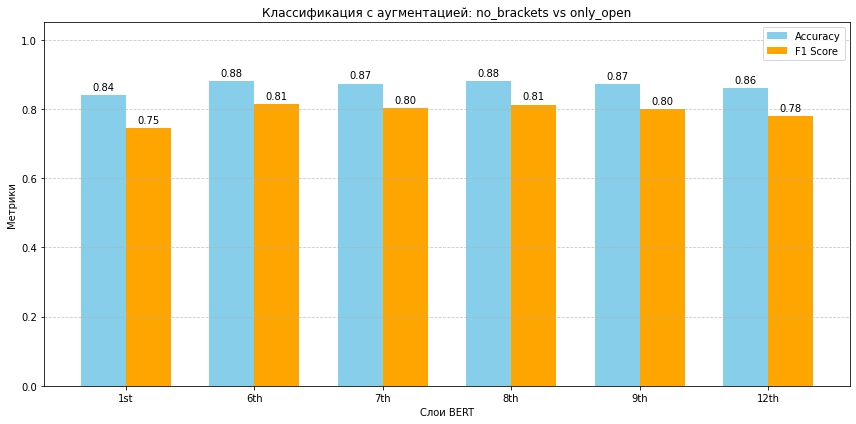


=== Классификация с аугментированными данными: no_brackets vs only_close ===

Слой 1st:
Accuracy: 0.9244
F1 Score: 0.6845

Слой 6th:
Accuracy: 0.9553
F1 Score: 0.8180

Слой 7th:
Accuracy: 0.9507
F1 Score: 0.7995

Слой 8th:
Accuracy: 0.9529
F1 Score: 0.8131

Слой 9th:
Accuracy: 0.9559
F1 Score: 0.8269

Слой 12th:
Accuracy: 0.9431
F1 Score: 0.7669


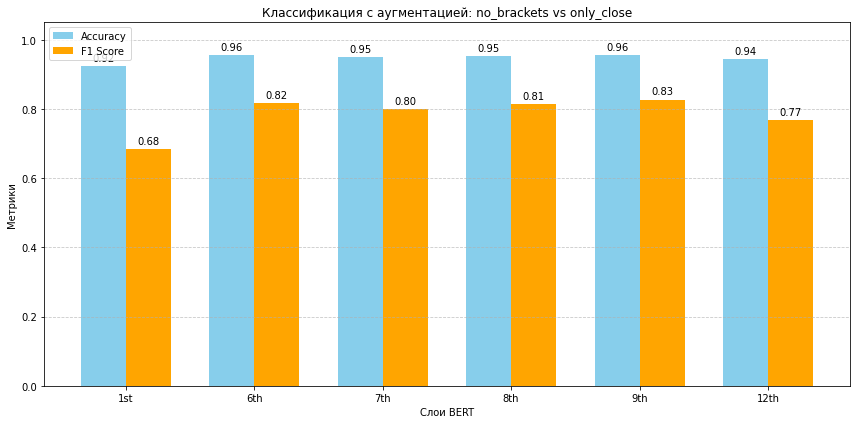


=== Классификация с аугментированными данными: no_brackets vs mixed ===

Слой 1st:
Accuracy: 0.9428
F1 Score: 0.7462

Слой 6th:
Accuracy: 0.9679
F1 Score: 0.8656

Слой 7th:
Accuracy: 0.9614
F1 Score: 0.8399

Слой 8th:
Accuracy: 0.9676
F1 Score: 0.8613

Слой 9th:
Accuracy: 0.9648
F1 Score: 0.8500

Слой 12th:
Accuracy: 0.9654
F1 Score: 0.8530


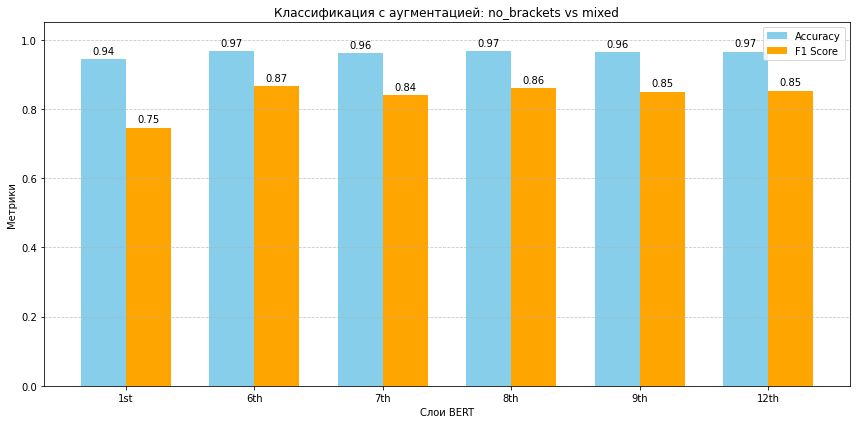


=== Классификация с аугментированными данными: only_open vs only_close ===

Слой 1st:
Accuracy: 0.9051
F1 Score: 0.7972

Слой 6th:
Accuracy: 0.9628
F1 Score: 0.9199

Слой 7th:
Accuracy: 0.9633
F1 Score: 0.9236

Слой 8th:
Accuracy: 0.9693
F1 Score: 0.9356

Слой 9th:
Accuracy: 0.9693
F1 Score: 0.9357

Слой 12th:
Accuracy: 0.9337
F1 Score: 0.8575


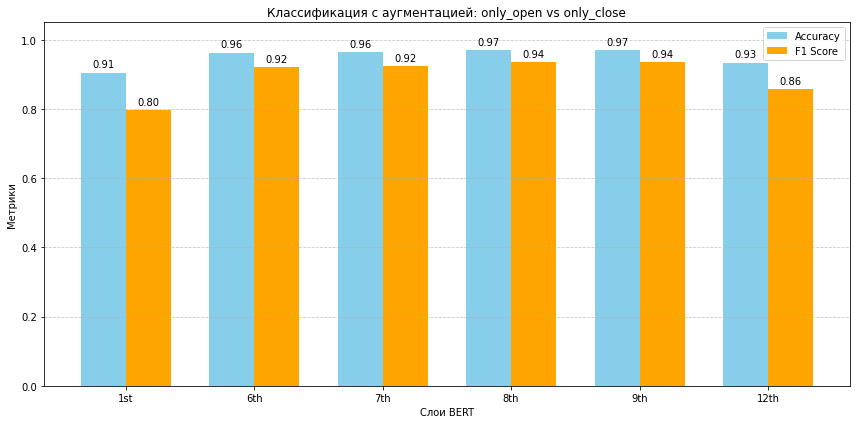


=== Классификация с аугментированными данными: only_open vs mixed ===

Слой 1st:
Accuracy: 0.8322
F1 Score: 0.5629

Слой 6th:
Accuracy: 0.8991
F1 Score: 0.7493

Слой 7th:
Accuracy: 0.8964
F1 Score: 0.7400

Слой 8th:
Accuracy: 0.8914
F1 Score: 0.7273

Слой 9th:
Accuracy: 0.8827
F1 Score: 0.7092

Слой 12th:
Accuracy: 0.8805
F1 Score: 0.7070


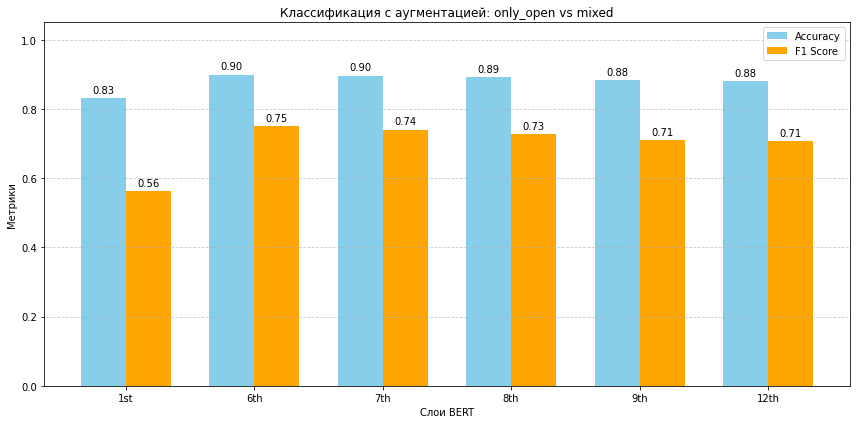


=== Классификация с аугментированными данными: only_close vs mixed ===

Слой 1st:
Accuracy: 0.9004
F1 Score: 0.8951

Слой 6th:
Accuracy: 0.9332
F1 Score: 0.9296

Слой 7th:
Accuracy: 0.9344
F1 Score: 0.9310

Слой 8th:
Accuracy: 0.9521
F1 Score: 0.9493

Слой 9th:
Accuracy: 0.9369
F1 Score: 0.9333

Слой 12th:
Accuracy: 0.9130
F1 Score: 0.9103


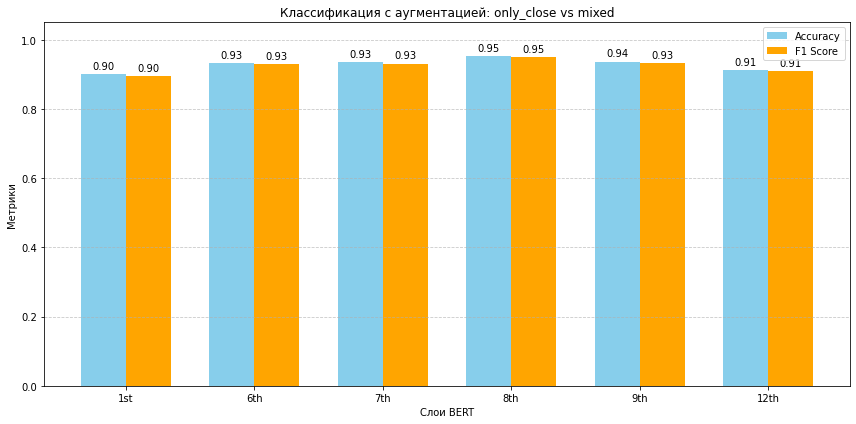


=== Confusion Matrix Analysis with Augmented Data: no_brackets vs only_open ===

Слой 1st:


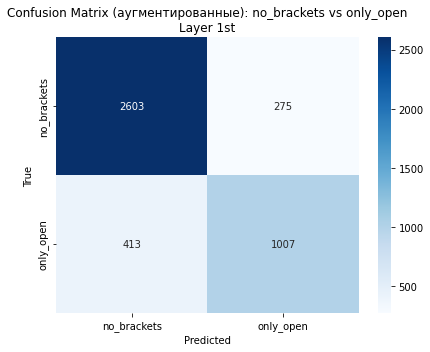

Всего примеров: 4298
Класс no_brackets: 2878
Класс only_open: 1420

Матрица ошибок:
Правильно классифицированные no_brackets: 2603
Ошибочно классифицированные как only_open: 275
Ошибочно классифицированные как no_brackets: 413
Правильно классифицированные only_open: 1007


Слой 6th:


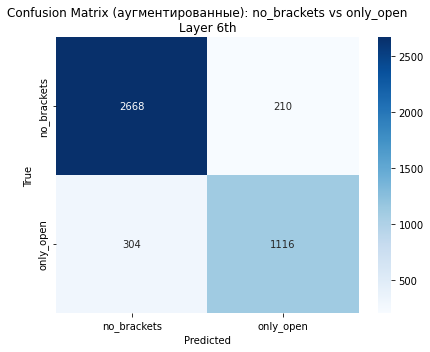

Всего примеров: 4298
Класс no_brackets: 2878
Класс only_open: 1420

Матрица ошибок:
Правильно классифицированные no_brackets: 2668
Ошибочно классифицированные как only_open: 210
Ошибочно классифицированные как no_brackets: 304
Правильно классифицированные only_open: 1116


Слой 12th:


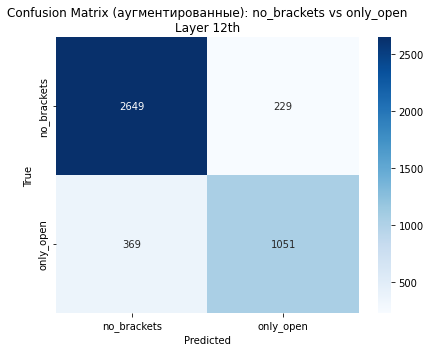

Всего примеров: 4298
Класс no_brackets: 2878
Класс only_open: 1420

Матрица ошибок:
Правильно классифицированные no_brackets: 2649
Ошибочно классифицированные как only_open: 229
Ошибочно классифицированные как no_brackets: 369
Правильно классифицированные only_open: 1051


=== Confusion Matrix Analysis with Augmented Data: no_brackets vs only_close ===

Слой 1st:


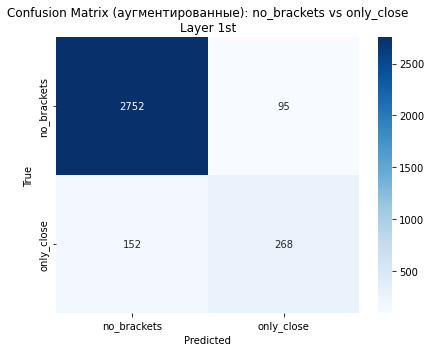

Всего примеров: 3267
Класс no_brackets: 2847
Класс only_close: 420

Матрица ошибок:
Правильно классифицированные no_brackets: 2752
Ошибочно классифицированные как only_close: 95
Ошибочно классифицированные как no_brackets: 152
Правильно классифицированные only_close: 268


Слой 6th:


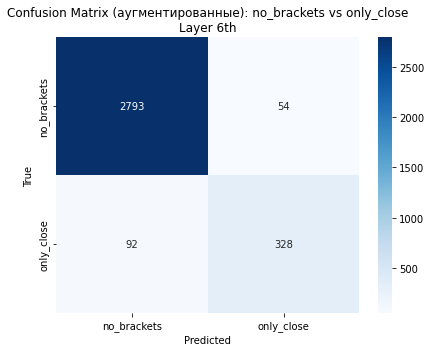

Всего примеров: 3267
Класс no_brackets: 2847
Класс only_close: 420

Матрица ошибок:
Правильно классифицированные no_brackets: 2793
Ошибочно классифицированные как only_close: 54
Ошибочно классифицированные как no_brackets: 92
Правильно классифицированные only_close: 328


Слой 12th:


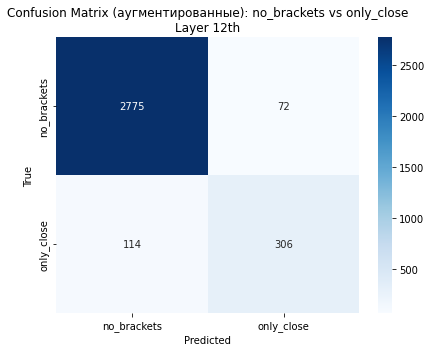

Всего примеров: 3267
Класс no_brackets: 2847
Класс only_close: 420

Матрица ошибок:
Правильно классифицированные no_brackets: 2775
Ошибочно классифицированные как only_close: 72
Ошибочно классифицированные как no_brackets: 114
Правильно классифицированные only_close: 306


=== Confusion Matrix Analysis with Augmented Data: no_brackets vs mixed ===

Слой 1st:


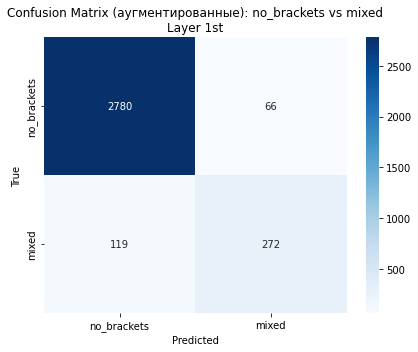

Всего примеров: 3237
Класс no_brackets: 2846
Класс mixed: 391

Матрица ошибок:
Правильно классифицированные no_brackets: 2780
Ошибочно классифицированные как mixed: 66
Ошибочно классифицированные как no_brackets: 119
Правильно классифицированные mixed: 272


Слой 6th:


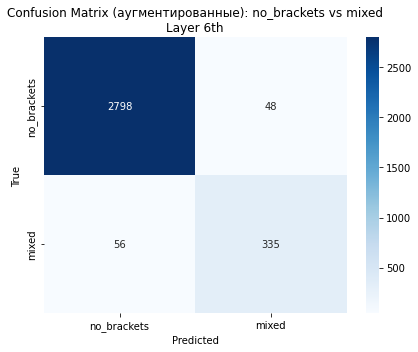

Всего примеров: 3237
Класс no_brackets: 2846
Класс mixed: 391

Матрица ошибок:
Правильно классифицированные no_brackets: 2798
Ошибочно классифицированные как mixed: 48
Ошибочно классифицированные как no_brackets: 56
Правильно классифицированные mixed: 335


Слой 12th:


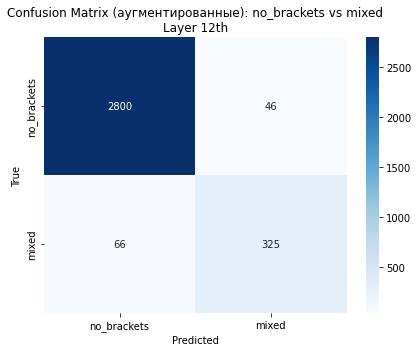

Всего примеров: 3237
Класс no_brackets: 2846
Класс mixed: 391

Матрица ошибок:
Правильно классифицированные no_brackets: 2800
Ошибочно классифицированные как mixed: 46
Ошибочно классифицированные как no_brackets: 66
Правильно классифицированные mixed: 325


=== Confusion Matrix Analysis with Augmented Data: only_open vs only_close ===

Слой 1st:


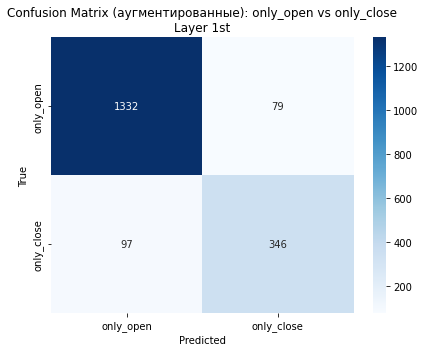

Всего примеров: 1854
Класс only_open: 1411
Класс only_close: 443

Матрица ошибок:
Правильно классифицированные only_open: 1332
Ошибочно классифицированные как only_close: 79
Ошибочно классифицированные как only_open: 97
Правильно классифицированные only_close: 346


Слой 6th:


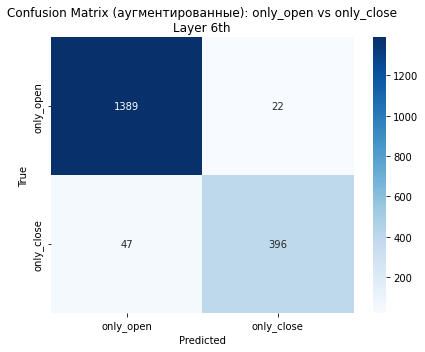

Всего примеров: 1854
Класс only_open: 1411
Класс only_close: 443

Матрица ошибок:
Правильно классифицированные only_open: 1389
Ошибочно классифицированные как only_close: 22
Ошибочно классифицированные как only_open: 47
Правильно классифицированные only_close: 396


Слой 12th:


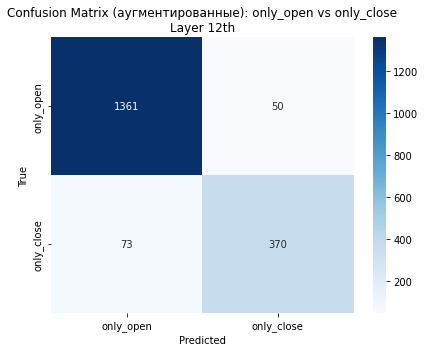

Всего примеров: 1854
Класс only_open: 1411
Класс only_close: 443

Матрица ошибок:
Правильно классифицированные only_open: 1361
Ошибочно классифицированные как only_close: 50
Ошибочно классифицированные как only_open: 73
Правильно классифицированные only_close: 370


=== Confusion Matrix Analysis with Augmented Data: only_open vs mixed ===

Слой 1st:


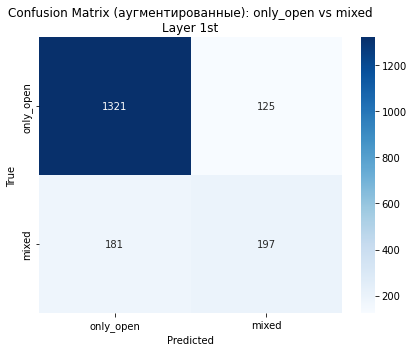

Всего примеров: 1824
Класс only_open: 1446
Класс mixed: 378

Матрица ошибок:
Правильно классифицированные only_open: 1321
Ошибочно классифицированные как mixed: 125
Ошибочно классифицированные как only_open: 181
Правильно классифицированные mixed: 197


Слой 6th:


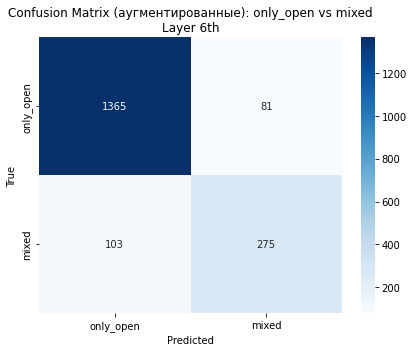

Всего примеров: 1824
Класс only_open: 1446
Класс mixed: 378

Матрица ошибок:
Правильно классифицированные only_open: 1365
Ошибочно классифицированные как mixed: 81
Ошибочно классифицированные как only_open: 103
Правильно классифицированные mixed: 275


Слой 12th:


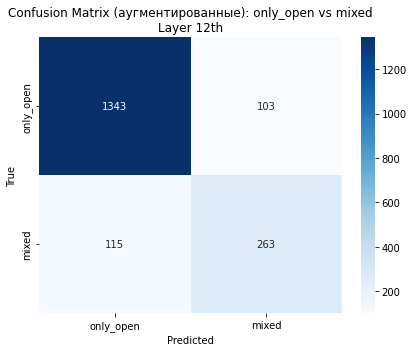

Всего примеров: 1824
Класс only_open: 1446
Класс mixed: 378

Матрица ошибок:
Правильно классифицированные only_open: 1343
Ошибочно классифицированные как mixed: 103
Ошибочно классифицированные как only_open: 115
Правильно классифицированные mixed: 263


=== Confusion Matrix Analysis with Augmented Data: only_close vs mixed ===

Слой 1st:


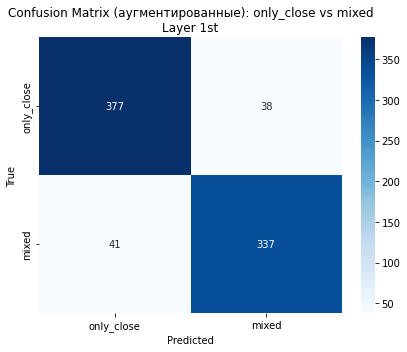

Всего примеров: 793
Класс only_close: 415
Класс mixed: 378

Матрица ошибок:
Правильно классифицированные only_close: 377
Ошибочно классифицированные как mixed: 38
Ошибочно классифицированные как only_close: 41
Правильно классифицированные mixed: 337


Слой 6th:


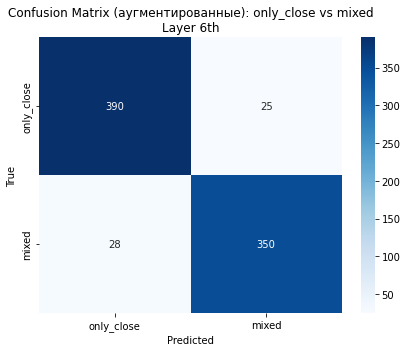

Всего примеров: 793
Класс only_close: 415
Класс mixed: 378

Матрица ошибок:
Правильно классифицированные only_close: 390
Ошибочно классифицированные как mixed: 25
Ошибочно классифицированные как only_close: 28
Правильно классифицированные mixed: 350


Слой 12th:


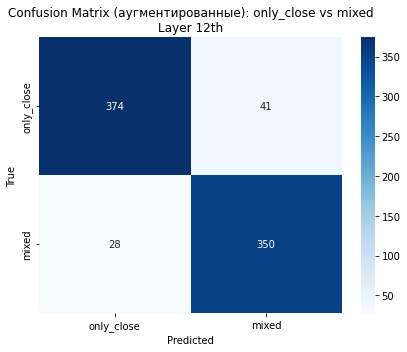

Всего примеров: 793
Класс only_close: 415
Класс mixed: 378

Матрица ошибок:
Правильно классифицированные only_close: 374
Ошибочно классифицированные как mixed: 41
Ошибочно классифицированные как only_close: 28
Правильно классифицированные mixed: 350



In [22]:
# Повторяем анализ с аугментированными данными
for pair_idx, (class1, class2) in enumerate(class_pairs):
    print(f"\n=== Классификация с аугментированными данными: {class1} vs {class2} ===")
    
    # Результаты для всех слоев
    pair_accuracies = []
    pair_f1_scores = []
    
    for layer in selected_layers:
        print(f"\nСлой {layer_names[layer]}:")
        
        # Фильтруем данные только для нужных классов
        X_layer = []
        y_layer = []
        
        for x, y in zip(X_all_augmented[layer], y_raw_augmented[layer]):
            if y == class1:
                X_layer.append(x)
                y_layer.append(0)  # Первый класс как 0
            elif y == class2:
                X_layer.append(x)
                y_layer.append(1)  # Второй класс как 1
        
        X_layer = np.array(X_layer)
        y_layer = np.array(y_layer)
        
        if len(X_layer) == 0 or len(np.unique(y_layer)) < 2:
            print("Недостаточно данных для этих классов")
            pair_accuracies.append(np.nan)
            pair_f1_scores.append(np.nan)
            continue
        
        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X_layer, y_layer, test_size=0.2, random_state=42
        )
        
        # Обучение и оценка
        accuracy, f1 = train_and_evaluate(
            X_train, X_test, y_train, y_test,
            layer_names[layer], f"{class1}_vs_{class2}"
        )
        
        pair_accuracies.append(accuracy)
        pair_f1_scores.append(f1)
    
    # Визуализация результатов для пары классов
    plt.figure(figsize=(12, 6))
    
    # Убираем слои с недостаточным количеством данных
    valid_layers = [i for i, acc in enumerate(pair_accuracies) if not np.isnan(acc)]
    valid_acc = [pair_accuracies[i] for i in valid_layers]
    valid_f1 = [pair_f1_scores[i] for i in valid_layers]
    valid_labels = [layer_names[selected_layers[i]] for i in valid_layers]
    
    # Настройки для группированных столбцов
    x = np.arange(len(valid_labels))  # позиции слоев
    width = 0.35  # ширина столбцов
    
    # Создаем столбцы
    rects1 = plt.bar(x - width/2, valid_acc, width, label='Accuracy', color='skyblue')
    rects2 = plt.bar(x + width/2, valid_f1, width, label='F1 Score', color='orange')
    
    plt.xlabel('Слои BERT')
    plt.ylabel('Метрики')
    plt.title(f'Классификация с аугментацией: {class1} vs {class2}')
    plt.xticks(x, valid_labels)
    plt.ylim(0, 1.05)
    plt.legend()
    
    # Добавляем значения на столбцы
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            plt.annotate(f'{height:.2f}',
                         xy=(rect.get_x() + rect.get_width()/2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom')
    
    add_labels(rects1)
    add_labels(rects2)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'доп/classification_augmented_{class1}_vs_{class2}.png')
    plt.show()

# Confusion matrix для аугментированных данных (слои 1, 6, 12)
selected_for_cm = [1, 6, 12]

for pair_idx, (class1, class2) in enumerate(class_pairs):
    print(f"\n=== Confusion Matrix Analysis with Augmented Data: {class1} vs {class2} ===")
    
    for layer in selected_for_cm:
        print(f"\nСлой {layer_names[layer]}:")
        
        # Фильтруем данные только для нужных классов
        X_layer = []
        y_layer = []
        
        for x, y in zip(X_all_augmented[layer], y_raw_augmented[layer]):
            if y == class1:
                X_layer.append(x)
                y_layer.append(0)
            elif y == class2:
                X_layer.append(x)
                y_layer.append(1)
        
        X_layer = np.array(X_layer)
        y_layer = np.array(y_layer)
        
        if len(X_layer) == 0 or len(np.unique(y_layer)) < 2:
            print("Недостаточно данных для этих классов")
            continue
        
        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X_layer, y_layer, test_size=0.2, random_state=42
        )
        
        # Масштабирование и обучение
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_scaled, y_train)
        
        # Предсказания для confusion matrix
        y_pred = clf.predict(X_test_scaled)
        
        # Построение confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=[class1, class2], 
                    yticklabels=[class1, class2])
        plt.title(f'Confusion Matrix (аугментированные): {class1} vs {class2}\nLayer {layer_names[layer]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(f'доп/confusion_matrix_augmented_{class1}_vs_{class2}_layer{layer}.png')
        plt.show()
        
        # Вывод дополнительной информации
        print(f"Всего примеров: {len(y_test)}")
        print(f"Класс {class1}: {sum(y_test == 0)}")
        print(f"Класс {class2}: {sum(y_test == 1)}")
        print("\nМатрица ошибок:")
        print(f"Правильно классифицированные {class1}: {cm[0, 0]}")
        print(f"Ошибочно классифицированные как {class2}: {cm[0, 1]}")
        print(f"Ошибочно классифицированные как {class1}: {cm[1, 0]}")
        print(f"Правильно классифицированные {class2}: {cm[1, 1]}")
        print("\n" + "="*50)


=== UMAP визуализация для слоя 1st ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


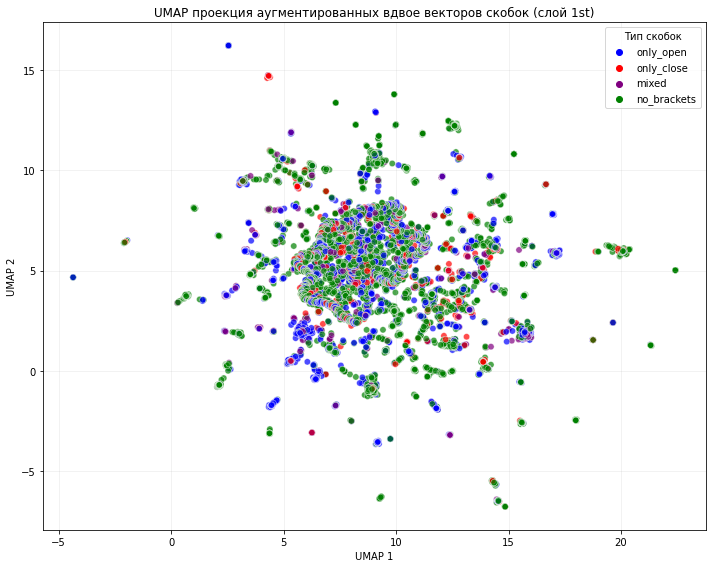

Распределение классов для слоя 1st:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 6th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


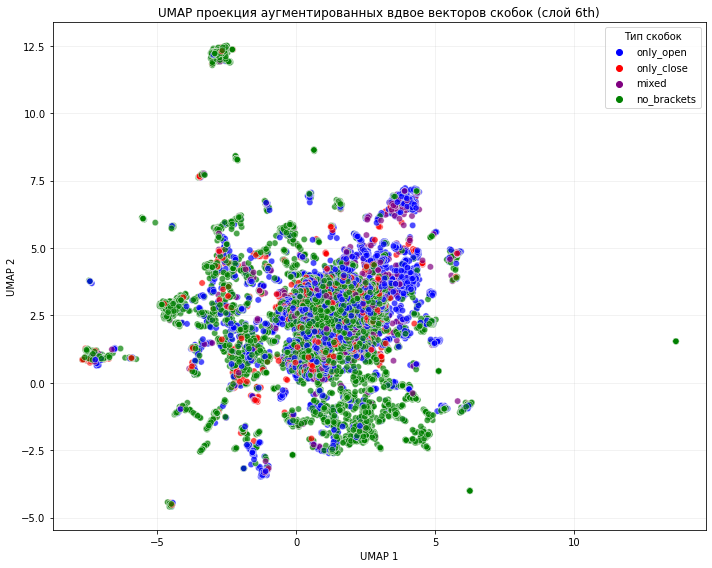

Распределение классов для слоя 6th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 7th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


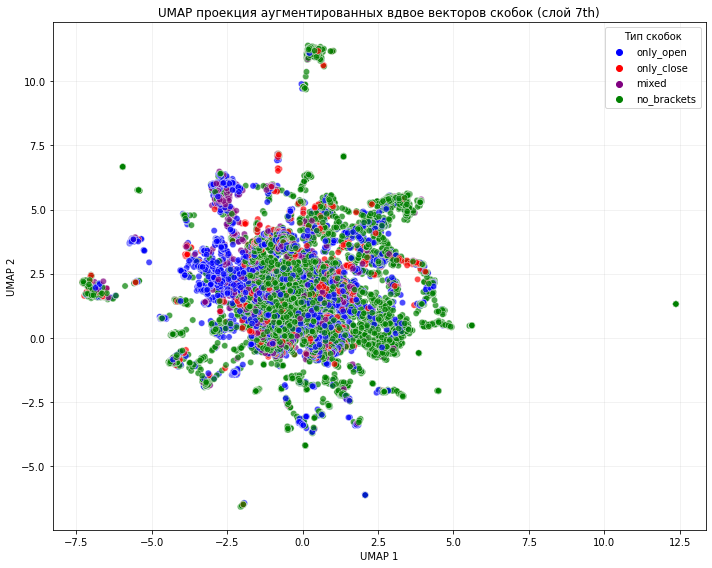

Распределение классов для слоя 7th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 8th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


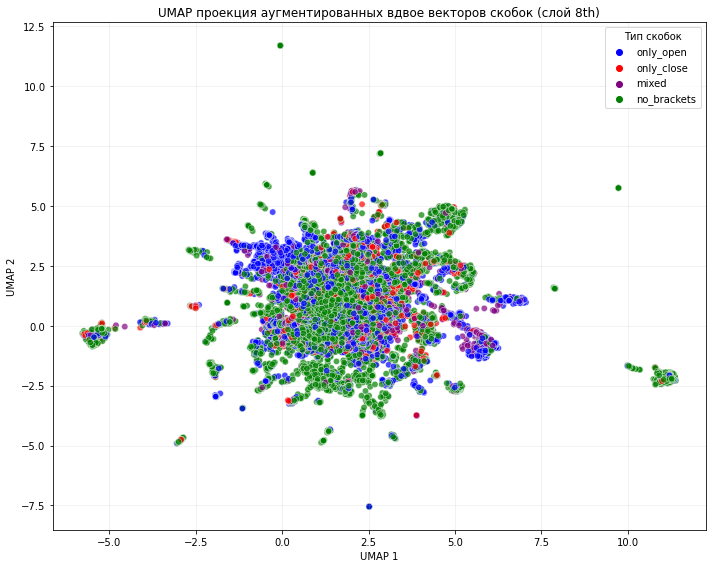

Распределение классов для слоя 8th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 9th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


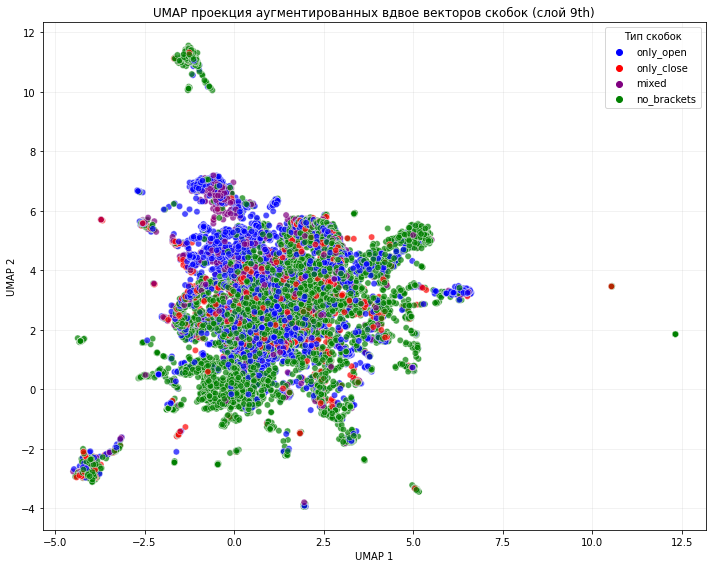

Распределение классов для слоя 9th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== UMAP визуализация для слоя 12th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


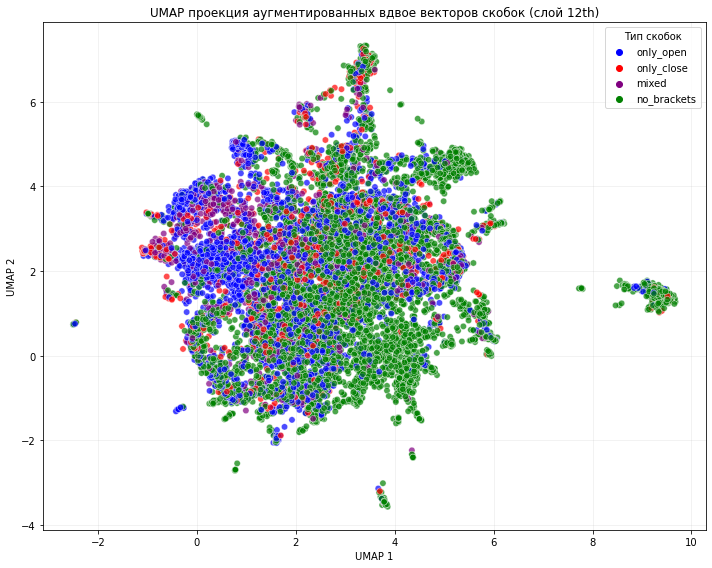

Распределение классов для слоя 12th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64


In [27]:
color_map = {
    'no_brackets': 'green',
    'only_open': 'blue',
    'only_close': 'red',
    'mixed': 'purple'
}
# Визуализация для всех выбранных слоев
for layer in selected_layers:
    X_layer_viz = np.array(X_all[layer])
    y_layer_viz = np.array(y_raw[layer])
    
    if len(X_layer_viz) == 0:
        print(f"\nНет данных для визуализации слоя {layer_names[layer]}")
        continue
    
    print(f"\n=== UMAP визуализация для слоя {layer_names[layer]} ===")
    
    reducer = UMAP(random_state=42)
    X_embedded = reducer.fit_transform(X_layer_viz)
    
    df = pd.DataFrame(X_embedded, columns=['x', 'y'])
    df['class'] = y_layer_viz
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df,
        x='x',
        y='y',
        hue='class',
        palette=color_map,
        alpha=0.7,
        s=40
    )
    
    plt.title(f'UMAP проекция аугментированных вдвое векторов скобок (слой {layer_names[layer]})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(title='Тип скобок')
    plt.grid(alpha=0.2)
    
    plt.tight_layout()
    plt.savefig(f'umap_aug2_visualization_layer_{layer}.png')
    plt.show()
    
    print(f"Распределение классов для слоя {layer_names[layer]}:")
    print(df['class'].value_counts())

In [35]:
# Цветовая схема для классов
color_map = {
    'no_brackets': 'green',
    'only_open': 'blue',
    'only_close': 'red',
    'mixed': 'purple'
}

# Визуализация для всех выбранных слоев в 3D
for layer in selected_layers:
    X_layer_viz = np.array(X_all[layer])
    y_layer_viz = np.array(y_raw[layer])
    
    if len(X_layer_viz) == 0:
        print(f"\nНет данных для визуализации слоя {layer_names[layer]}")
        continue
    
    print(f"\n=== 3D UMAP визуализация для слоя {layer_names[layer]} ===")
    
    # Применяем UMAP для уменьшения размерности до 3D
    reducer = UMAP(n_components=3, random_state=42)
    X_embedded = reducer.fit_transform(X_layer_viz)
    
    # Создаем DataFrame для визуализации
    df = pd.DataFrame(X_embedded, columns=['x', 'y', 'z'])
    df['class'] = y_layer_viz
    df['color'] = df['class'].map(color_map)
    
    # Создаем интерактивный 3D график
    fig = px.scatter_3d(
        df,
        x='x',
        y='y',
        z='z',
        color='class',
        color_discrete_map=color_map,
        title=f'3D UMAP проекция аугментированных вдвое векторов скобок (слой {layer_names[layer]})',
        labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'z': 'UMAP 3'},
        opacity=0.8,
        size_max=10,
        hover_data=['class']
    )
    
    # Настраиваем отображение
    fig.update_traces(
        marker=dict(
            size=5,
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        selector=dict(mode='markers')
    )
    
    # Добавляем подписи и настройки
    fig.update_layout(
        legend_title_text='Тип скобок',
        scene=dict(
            xaxis_title='UMAP 1',
            yaxis_title='UMAP 2',
            zaxis_title='UMAP 3'
        ),
        width=1000,
        height=800,
        margin=dict(r=20, b=10, l=10, t=40)
    )
    
    # Сохраняем и показываем график
    fig.write_html(f"umap3d_aug2_layer_{layer}.html")
    #fig.show()
    
    print(f"Распределение классов для слоя {layer_names[layer]}:")
    print(df['class'].value_counts())


=== 3D UMAP визуализация для слоя 1st ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 1st:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 6th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 6th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 7th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 7th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 8th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 8th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 9th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 9th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64

=== 3D UMAP визуализация для слоя 12th ===


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение классов для слоя 12th:
no_brackets    7138
only_open      3607
only_close     1028
mixed           953
Name: class, dtype: int64


In [16]:
# Выбираем нужные слои (1-based индексы: 1,6,7,8,9,12)
selected_layers = [1, 6, 7, 8, 9, 12]
layer_names = {1: '1st', 6: '6th', 7: '7th', 8: '8th', 9: '9th', 12: '12th'}

# Подготовка данных
X = {layer: [] for layer in selected_layers}
y = {layer: [] for layer in selected_layers}

for n in new_data[:1000]:
    all_layers_vectors = vectors_for_word_all_layers(n[0])  # Получаем векторы для всех слоев
    
    # Обрабатываем слова со скобками (класс 1)
    if len(n[1][0]) != 0:
        for i in n[1][0]:
            for layer in selected_layers:
                if i[0] < len(all_layers_vectors[layer-1]) and i[1] < len(all_layers_vectors[layer-1]):
                    vec_diff = all_layers_vectors[layer-1][i[0]] - all_layers_vectors[layer-1][i[1]]
                    X[layer].append(vec_diff.numpy())
                    y[layer].append(1)  # Класс "есть скобки"
    
    # Обрабатываем слова без скобок (класс 0)
    if len(n[1][1]) != 0:
        for i in n[1][1]:
            for layer in selected_layers:
                if i[0] < len(all_layers_vectors[layer-1]) and i[1] < len(all_layers_vectors[layer-1]):
                    vec_diff = all_layers_vectors[layer-1][i[0]] - all_layers_vectors[layer-1][i[1]]
                    X[layer].append(vec_diff.numpy())
                    y[layer].append(0)  # Класс "нет скобок"

In [17]:
# Результаты для графиков
accuracies = []
f1_scores = []
layer_labels = []

# Обучение и оценка для каждого слоя отдельно
for layer in selected_layers:
    print(f"\n=== Анализ для {layer_names[layer]} слоя ===")
    
    if not X[layer]:  # Пропускаем если нет данных
        print("Нет данных для этого слоя")
        continue
    
    X_layer = np.array(X[layer])
    y_layer = np.array(y[layer])
    
    # Разделение и масштабирование
    X_train, X_test, y_train, y_test = train_test_split(X_layer, y_layer, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Обучение логистической регрессии
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_scaled, y_train)
    
    # Предсказание и оценка
    y_pred = clf.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    accuracies.append(accuracy)
    f1_scores.append(f1)
    layer_labels.append(layer_names[layer])
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("="*30)


=== Анализ для 1st слоя ===
Accuracy: 0.7734
F1 Score: 0.7354

=== Анализ для 6th слоя ===
Accuracy: 0.8315
F1 Score: 0.8051

=== Анализ для 7th слоя ===
Accuracy: 0.8252
F1 Score: 0.7967

=== Анализ для 8th слоя ===
Accuracy: 0.8248
F1 Score: 0.7958

=== Анализ для 9th слоя ===
Accuracy: 0.8213
F1 Score: 0.7925

=== Анализ для 12th слоя ===
Accuracy: 0.8138
F1 Score: 0.7836


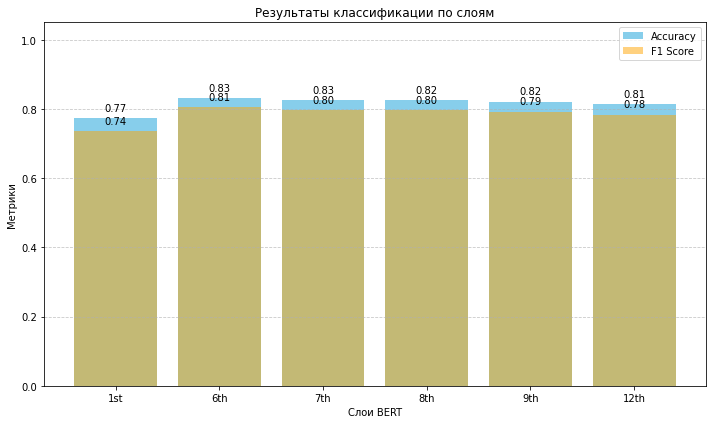

In [18]:
# Визуализация результатов
plt.figure(figsize=(10, 6))
x = range(len(accuracies))
plt.bar(x, accuracies, color='skyblue', label='Accuracy')
plt.bar(x, f1_scores, color='orange', alpha=0.5, label='F1 Score')

plt.xlabel('Слои BERT')
plt.ylabel('Метрики')
plt.title('Результаты классификации по слоям')
plt.xticks(x, layer_labels)
plt.ylim(0, 1.05)
plt.legend()

# Добавляем значения на график
for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
    plt.text(i, f1 + 0.02, f"{f1:.2f}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('classification_results.png')
plt.show()

In [20]:
# Функция для определения класса скобок
def get_bracket_class(bracket_str):
    if not bracket_str or bracket_str == '0':
        return None  # Не учитываем
    
    has_open = any(c in bracket_str for c in '([{')
    has_close = any(c in bracket_str for c in ')]}')
    
    if has_open and not has_close:
        return 0  # Только открывающие
    elif has_close and not has_open:
        return 1  # Только закрывающие
    else:
        return None  # Смешанные - не учитываем

# Подготовка данных
X = {layer: [] for layer in selected_layers}
y = {layer: [] for layer in selected_layers}

for n in new_data[:1000]:
    all_layers_vectors = vectors_for_word_all_layers(n[0])
    
    # Обрабатываем только слова со скобками (n[1][0])
    if len(n[1][0]) != 0:
        for i in n[1][0]:
            bracket_type = i[2]
            bracket_class = get_bracket_class(bracket_type)
            
            if bracket_class is None:
                continue  # Пропускаем смешанные случаи
                
            for layer in selected_layers:
                if i[0] < len(all_layers_vectors[layer-1]) and i[1] < len(all_layers_vectors[layer-1]):
                    vec_diff = all_layers_vectors[layer-1][i[0]] - all_layers_vectors[layer-1][i[1]]
                    X[layer].append(vec_diff.numpy())
                    y[layer].append(bracket_class)

In [21]:
# Результаты для графиков
accuracies = []
f1_scores = []
layer_labels = []

# Обучение и оценка для каждого слоя отдельно
for layer in selected_layers:
    print(f"\n=== Анализ для {layer_names[layer]} слоя ===")
    
    if not X[layer] or len(np.unique(y[layer])) < 2:
        print(f"Недостаточно данных для {layer_names[layer]} слоя")
        continue
    
    X_layer = np.array(X[layer])
    y_layer = np.array(y[layer])
    
    # Разделение и масштабирование
    X_train, X_test, y_train, y_test = train_test_split(X_layer, y_layer, 
                                                       test_size=0.2, 
                                                       random_state=42,
                                                       stratify=y_layer)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Обучение логистической регрессии
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X_train_scaled, y_train)
    
    # Предсказание и оценка
    y_pred = clf.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    accuracies.append(accuracy)
    f1_scores.append(f1)
    layer_labels.append(layer_names[layer])
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Opening', 'Closing']))
    print("="*30)


=== Анализ для 1st слоя ===
Accuracy: 0.8112
F1 Score: 0.8177
              precision    recall  f1-score   support

     Opening       0.91      0.85      0.87       721
     Closing       0.56      0.69      0.62       206

    accuracy                           0.81       927
   macro avg       0.73      0.77      0.75       927
weighted avg       0.83      0.81      0.82       927


=== Анализ для 6th слоя ===
Accuracy: 0.8889
F1 Score: 0.8903
              precision    recall  f1-score   support

     Opening       0.94      0.92      0.93       721
     Closing       0.73      0.79      0.76       206

    accuracy                           0.89       927
   macro avg       0.84      0.85      0.84       927
weighted avg       0.89      0.89      0.89       927


=== Анализ для 7th слоя ===
Accuracy: 0.8867
F1 Score: 0.8876
              precision    recall  f1-score   support

     Opening       0.93      0.92      0.93       721
     Closing       0.73      0.77      0.75     

<Figure size 864x432 with 0 Axes>

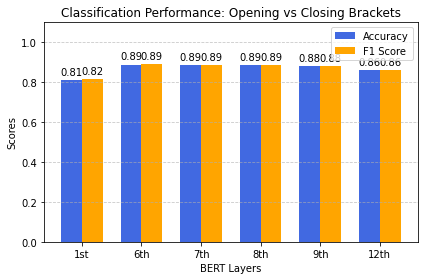

In [22]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(len(accuracies))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='royalblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='orange')

ax.set_xlabel('BERT Layers')
ax.set_ylabel('Scores')
ax.set_title('Classification Performance: Opening vs Closing Brackets')
ax.set_xticks(x)
ax.set_xticklabels(layer_labels)
ax.set_ylim(0, 1.1)
ax.legend()

# Добавляем подписи значений
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('opening_vs_closing_classification.png', dpi=300)
plt.show()

In [23]:
# Функция для определения класса скобок
def get_bracket_class(bracket_str):
    if not bracket_str or bracket_str == '0':
        return None  # Пропускаем случаи без скобок
    
    has_open = any(c in bracket_str for c in '([{')
    has_close = any(c in bracket_str for c in ')]}')
    
    if (has_open and not has_close) or (has_close and not has_open):
        return 0  # Однородные: только открывающие или только закрывающие
    elif has_open and has_close:
        return 1  # Неоднородные: смесь открывающих и закрывающих
    else:
        return None

# Подготовка данных
X = {layer: [] for layer in selected_layers}
y = {layer: [] for layer in selected_layers}

for n in new_data[:1000]:
    all_layers_vectors = vectors_for_word_all_layers(n[0])
    
    # Обрабатываем только слова со скобками (n[1][0])
    if len(n[1][0]) != 0:
        for i in n[1][0]:
            bracket_type = i[2]
            bracket_class = get_bracket_class(bracket_type)
            
            if bracket_class is None:
                continue
                
            for layer in selected_layers:
                if i[0] < len(all_layers_vectors[layer-1]) and i[1] < len(all_layers_vectors[layer-1]):
                    vec_diff = all_layers_vectors[layer-1][i[0]] - all_layers_vectors[layer-1][i[1]]
                    X[layer].append(vec_diff.numpy())
                    y[layer].append(bracket_class)

In [24]:
# Результаты для графиков
accuracies = []
f1_scores = []
layer_labels = []

# Обучение и оценка для каждого слоя отдельно
for layer in selected_layers:
    print(f"\n=== Анализ для {layer_names[layer]} слоя ===")
    
    if not X[layer] or len(np.unique(y[layer])) < 2:
        print(f"Недостаточно данных для {layer_names[layer]} слоя")
        continue
    
    X_layer = np.array(X[layer])
    y_layer = np.array(y[layer])
    
    # Разделение и масштабирование
    X_train, X_test, y_train, y_test = train_test_split(X_layer, y_layer, 
                                                       test_size=0.2, 
                                                       random_state=42,
                                                       stratify=y_layer)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Обучение логистической регрессии
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X_train_scaled, y_train)
    
    # Предсказание и оценка
    y_pred = clf.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    accuracies.append(accuracy)
    f1_scores.append(f1)
    layer_labels.append(layer_names[layer])
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred, 
                               target_names=['Homogeneous', 'Mixed']))
    print("="*30)


=== Анализ для 1st слоя ===
Accuracy: 0.6771
F1 Score: 0.7110
              precision    recall  f1-score   support

 Homogeneous       0.88      0.71      0.78       927
       Mixed       0.27      0.51      0.35       191

    accuracy                           0.68      1118
   macro avg       0.57      0.61      0.57      1118
weighted avg       0.77      0.68      0.71      1118


=== Анализ для 6th слоя ===
Accuracy: 0.7549
F1 Score: 0.7781
              precision    recall  f1-score   support

 Homogeneous       0.92      0.77      0.84       927
       Mixed       0.38      0.66      0.48       191

    accuracy                           0.75      1118
   macro avg       0.65      0.72      0.66      1118
weighted avg       0.82      0.75      0.78      1118


=== Анализ для 7th слоя ===
Accuracy: 0.7504
F1 Score: 0.7722
              precision    recall  f1-score   support

 Homogeneous       0.90      0.78      0.84       927
       Mixed       0.36      0.60      0.45     

<Figure size 864x432 with 0 Axes>

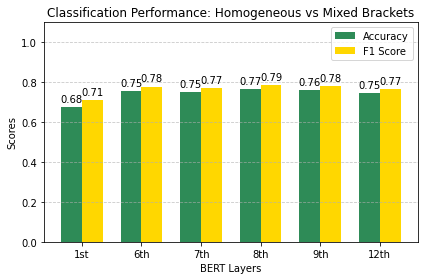

In [25]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(len(accuracies))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='seagreen')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='gold')

ax.set_xlabel('BERT Layers')
ax.set_ylabel('Scores')
ax.set_title('Classification Performance: Homogeneous vs Mixed Brackets')
ax.set_xticks(x)
ax.set_xticklabels(layer_labels)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper right')

# Добавляем подписи значений
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('homogeneous_vs_mixed_classification.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Функция для классификации скобок в 6 категорий
def classify_brackets(bracket_str):
    if bracket_str == '0':
        return 'no_brackets'
    
    open_count = sum(1 for c in bracket_str if c in '([{')
    close_count = sum(1 for c in bracket_str if c in ')]}')
    
    if open_count == 0 and close_count > 0:
        return 'only_closing'
    elif close_count == 0 and open_count > 0:
        return 'only_opening'
    elif open_count == 1 and close_count > 1:
        return 'one_open_many_close'
    elif close_count == 1 and open_count > 1:
        return 'one_close_many_open'
    elif close_count == 1 and open_count == 1:
        return 'one_close_one_open'
    else:
        return 'mixed'

# Подготовка данных
X = {layer: [] for layer in selected_layers}
y = {layer: [] for layer in selected_layers}

for n in new_data[:1000]:
    all_layers_vectors = vectors_for_word_all_layers(n[0])
    
    # Обрабатываем все пары слов
    if len(n[1][0]) != 0:  # Слова со скобками
        for i in n[1][0]:
            bracket_type = classify_brackets(i[2])  # Классифицируем скобки
            for layer in selected_layers:
                if i[0] < len(all_layers_vectors[layer-1]) and i[1] < len(all_layers_vectors[layer-1]):
                    vec_diff = all_layers_vectors[layer-1][i[0]] - all_layers_vectors[layer-1][i[1]]
                    X[layer].append(vec_diff.numpy())
                    y[layer].append(bracket_type)
    
    if len(n[1][1]) != 0:  # Слова без скобок
        for i in n[1][1]:
            for layer in selected_layers:
                if i[0] < len(all_layers_vectors[layer-1]) and i[1] < len(all_layers_vectors[layer-1]):
                    vec_diff = all_layers_vectors[layer-1][i[0]] - all_layers_vectors[layer-1][i[1]]
                    X[layer].append(vec_diff.numpy())
                    y[layer].append('no_brackets')  # Нет скобок

# Кодируем метки классов
label_encoders = {}
for layer in selected_layers:
    if y[layer]:
        le = LabelEncoder()
        y[layer] = le.fit_transform(y[layer])
        label_encoders[layer] = le

# Функция для обучения и оценки модели
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, layer_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n{model_name} Results ({layer_name} Layer):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Красивый отчет с названиями классов
    target_names = label_encoders[layer].classes_
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Матрица ошибок
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model_name} - {layer_name} Layer')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    #plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}_{layer_name}.png', dpi=300)
    plt.show()
    
    return accuracy, f1


=== Анализ для 1st слоя ===

Decision Tree Results (1st Layer):
Accuracy: 0.5844
F1 Score: 0.5590
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.69      0.78      0.73      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.03      0.02      0.02       124
one_open_many_close       0.00      0.00      0.00        54
       only_closing       0.18      0.11      0.14       206
       only_opening       0.48      0.48      0.48       722

           accuracy                           0.58      2546
          macro avg       0.20      0.20      0.20      2546
       weighted avg       0.54      0.58      0.56      2546



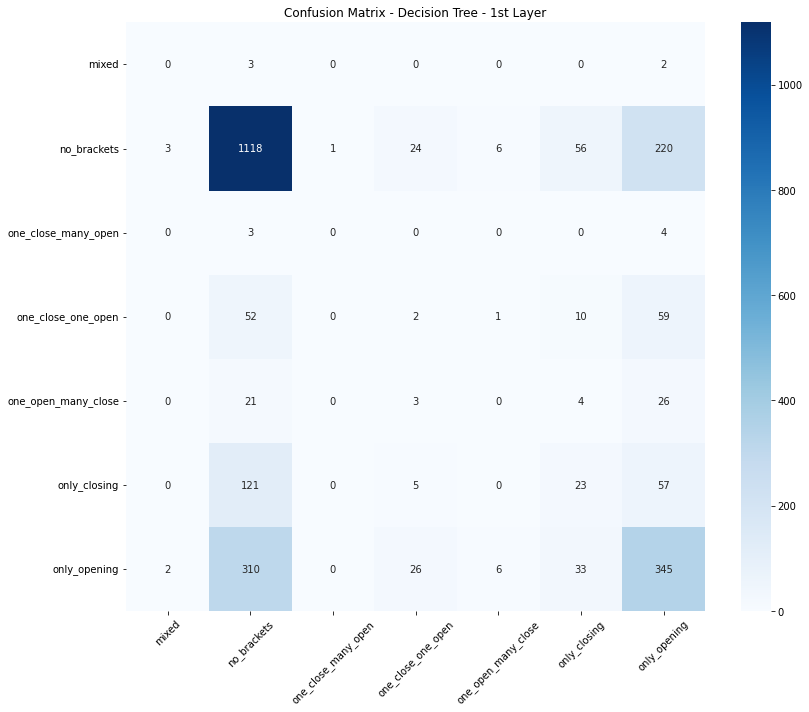


Random Forest Results (1st Layer):
Accuracy: 0.6697
F1 Score: 0.5947
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.67      0.97      0.79      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.00      0.00      0.00       124
one_open_many_close       0.00      0.00      0.00        54
       only_closing       0.00      0.00      0.00       206
       only_opening       0.68      0.43      0.53       722

           accuracy                           0.67      2546
          macro avg       0.19      0.20      0.19      2546
       weighted avg       0.57      0.67      0.59      2546



/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


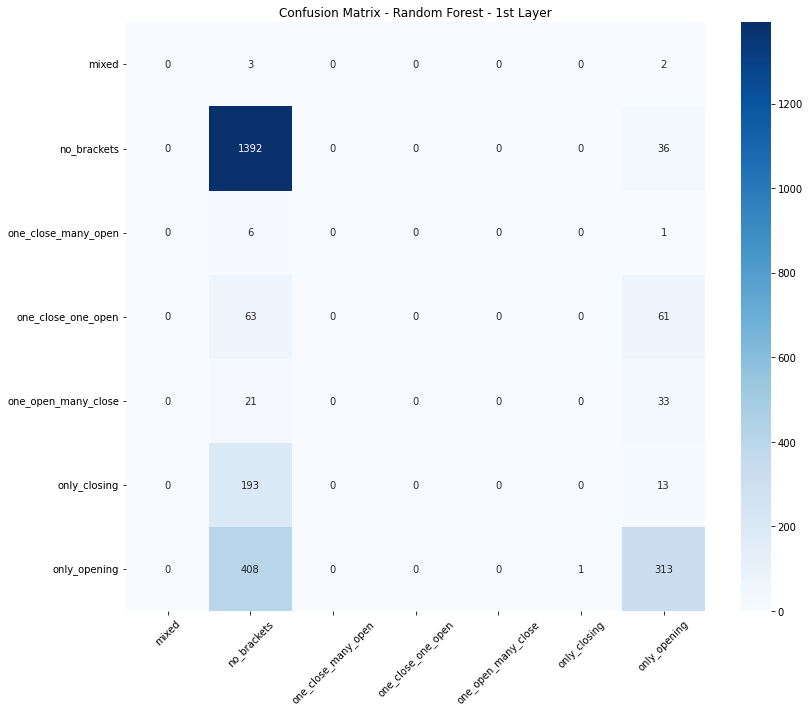

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In 


K-Means Results:
Accuracy: 0.6410
F1 Score: 0.5629


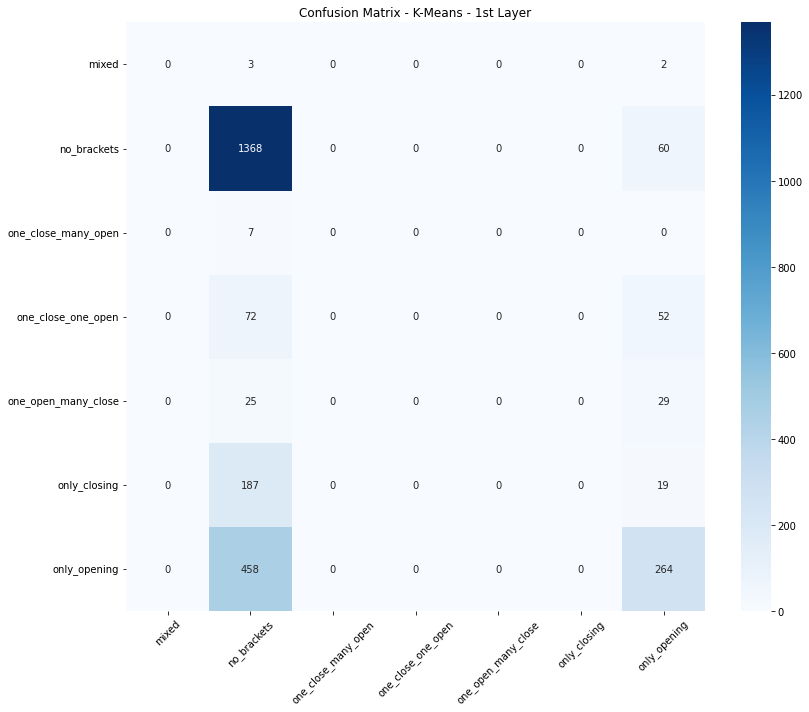


=== Анализ для 6th слоя ===

Decision Tree Results (6th Layer):
Accuracy: 0.5876
F1 Score: 0.5724
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.70      0.77      0.73      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.14      0.08      0.10       124
one_open_many_close       0.15      0.09      0.11        54
       only_closing       0.24      0.17      0.20       206
       only_opening       0.48      0.48      0.48       722

           accuracy                           0.59      2546
          macro avg       0.24      0.23      0.23      2546
       weighted avg       0.56      0.59      0.57      2546



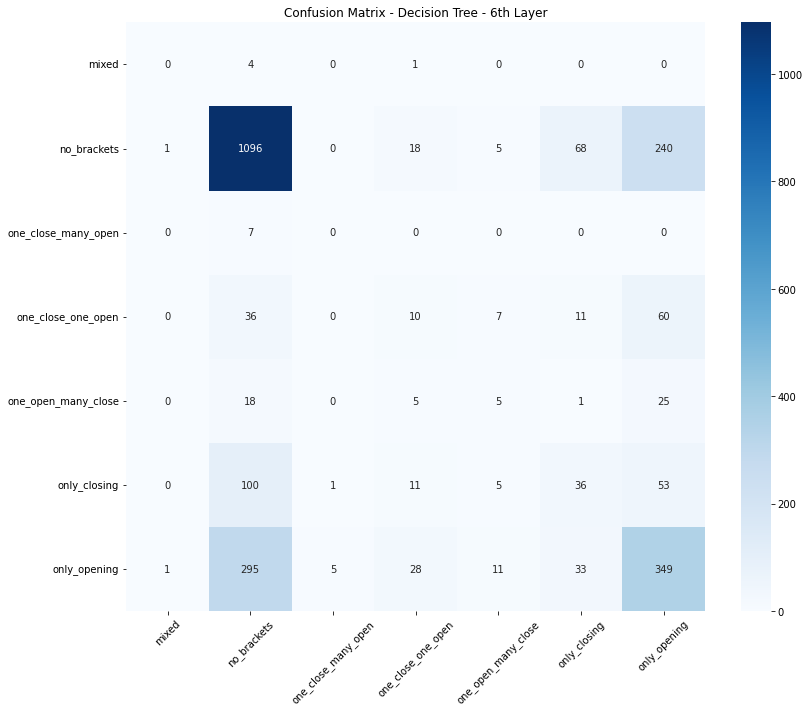


Random Forest Results (6th Layer):
Accuracy: 0.6795
F1 Score: 0.6059
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.68      0.98      0.80      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.00      0.00      0.00       124
one_open_many_close       0.00      0.00      0.00        54
       only_closing       1.00      0.00      0.01       206
       only_opening       0.68      0.46      0.55       722

           accuracy                           0.68      2546
          macro avg       0.34      0.21      0.19      2546
       weighted avg       0.65      0.68      0.61      2546



/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


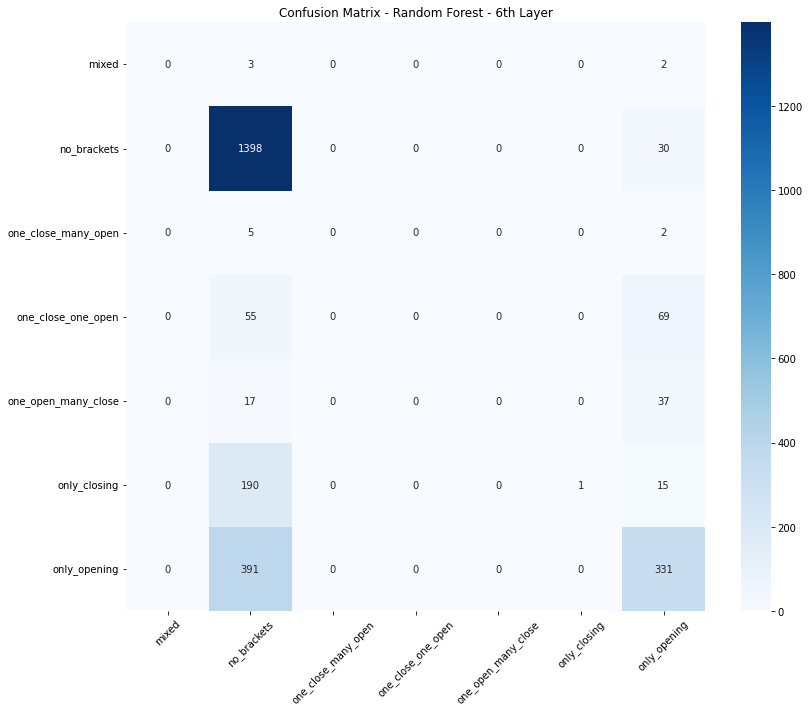

/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/6442845


K-Means Results:
Accuracy: 0.6622
F1 Score: 0.5967


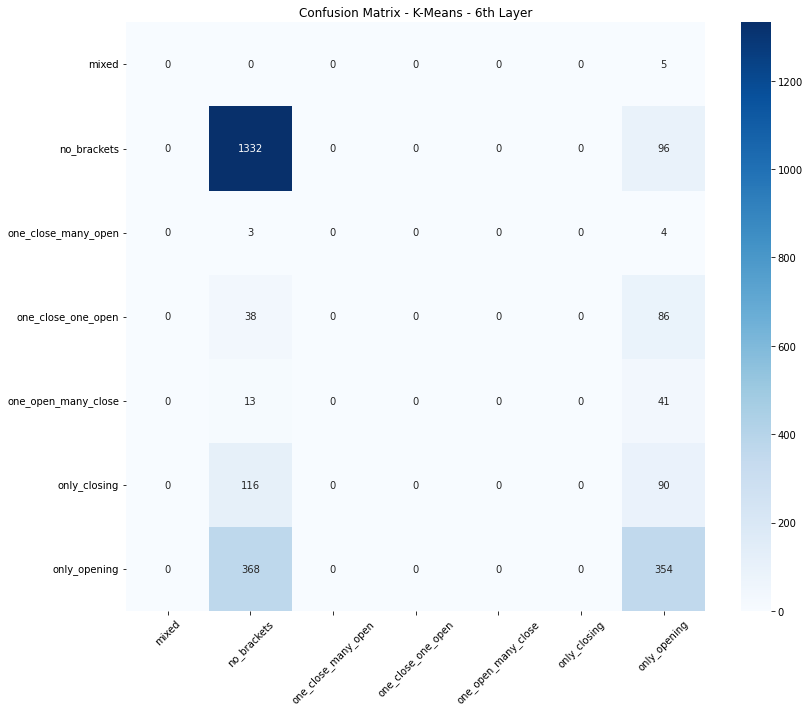


=== Анализ для 7th слоя ===

Decision Tree Results (7th Layer):
Accuracy: 0.5852
F1 Score: 0.5676
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.70      0.79      0.74      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.14      0.12      0.13       124
one_open_many_close       0.12      0.06      0.07        54
       only_closing       0.20      0.15      0.17       206
       only_opening       0.49      0.44      0.46       722

           accuracy                           0.59      2546
          macro avg       0.24      0.22      0.23      2546
       weighted avg       0.56      0.59      0.57      2546



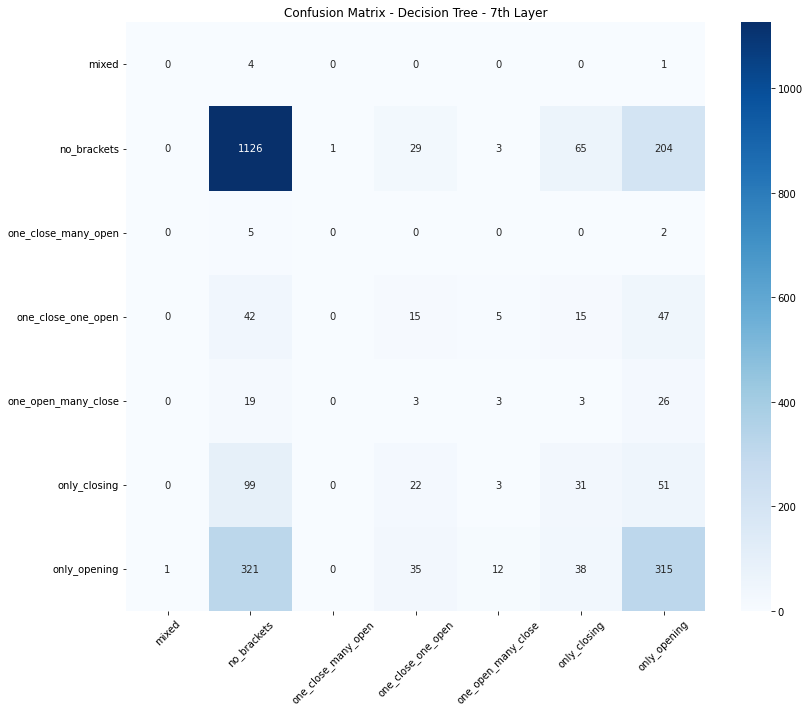


Random Forest Results (7th Layer):
Accuracy: 0.6764
F1 Score: 0.6026
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.68      0.98      0.80      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.00      0.00      0.00       124
one_open_many_close       0.00      0.00      0.00        54
       only_closing       1.00      0.01      0.02       206
       only_opening       0.67      0.45      0.54       722

           accuracy                           0.68      2546
          macro avg       0.34      0.20      0.19      2546
       weighted avg       0.65      0.68      0.60      2546



/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


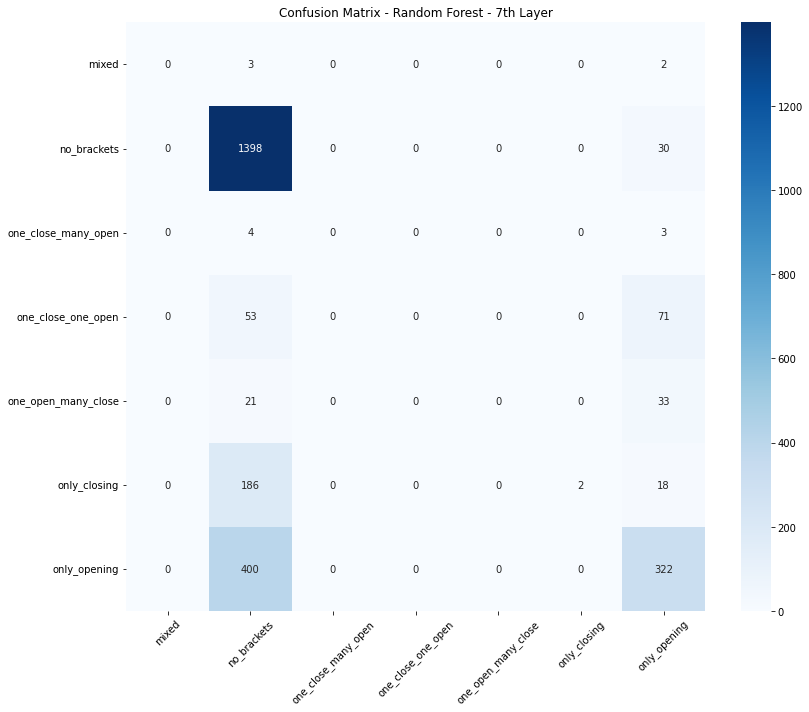

/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/6442845


K-Means Results:
Accuracy: 0.6614
F1 Score: 0.5963


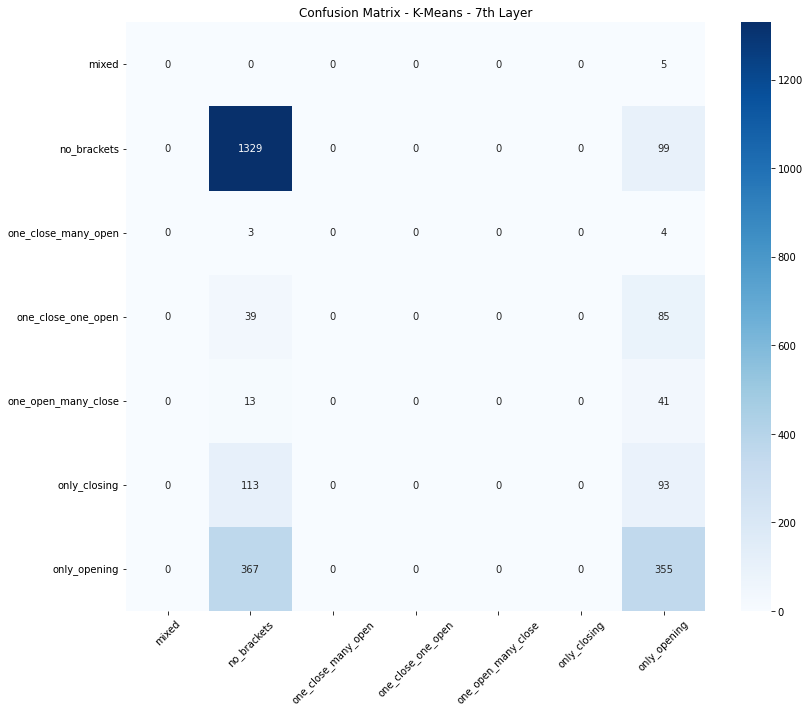


=== Анализ для 8th слоя ===

Decision Tree Results (8th Layer):
Accuracy: 0.5915
F1 Score: 0.5790
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.71      0.76      0.73      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.18      0.11      0.14       124
one_open_many_close       0.08      0.07      0.08        54
       only_closing       0.30      0.21      0.25       206
       only_opening       0.49      0.50      0.49       722

           accuracy                           0.59      2546
          macro avg       0.25      0.24      0.24      2546
       weighted avg       0.57      0.59      0.58      2546



/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


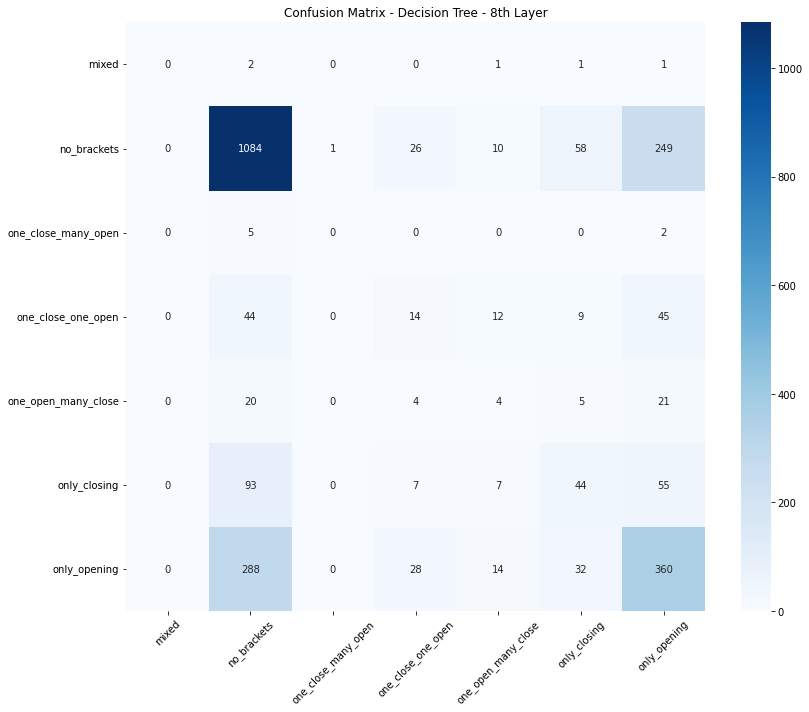


Random Forest Results (8th Layer):
Accuracy: 0.6807
F1 Score: 0.6105
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.69      0.97      0.80      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.00      0.00      0.00       124
one_open_many_close       0.00      0.00      0.00        54
       only_closing       1.00      0.02      0.04       206
       only_opening       0.65      0.48      0.55       722

           accuracy                           0.68      2546
          macro avg       0.33      0.21      0.20      2546
       weighted avg       0.65      0.68      0.61      2546



/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


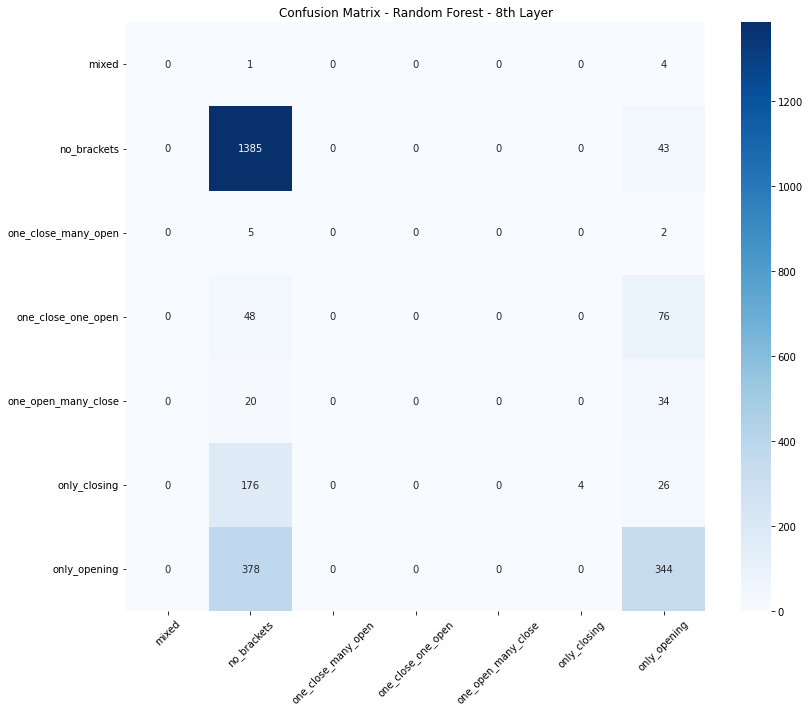

/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/6442845


K-Means Results:
Accuracy: 0.6646
F1 Score: 0.6094


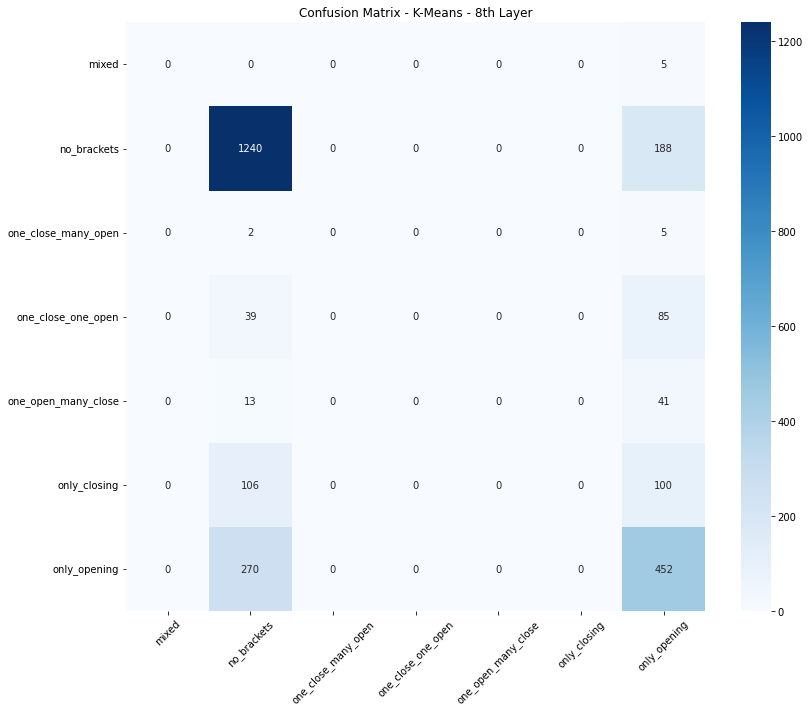


=== Анализ для 9th слоя ===

Decision Tree Results (9th Layer):
Accuracy: 0.5931
F1 Score: 0.5733
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.69      0.80      0.74      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.16      0.13      0.14       124
one_open_many_close       0.10      0.06      0.07        54
       only_closing       0.32      0.19      0.24       206
       only_opening       0.48      0.44      0.46       722

           accuracy                           0.59      2546
          macro avg       0.25      0.23      0.24      2546
       weighted avg       0.56      0.59      0.57      2546



/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


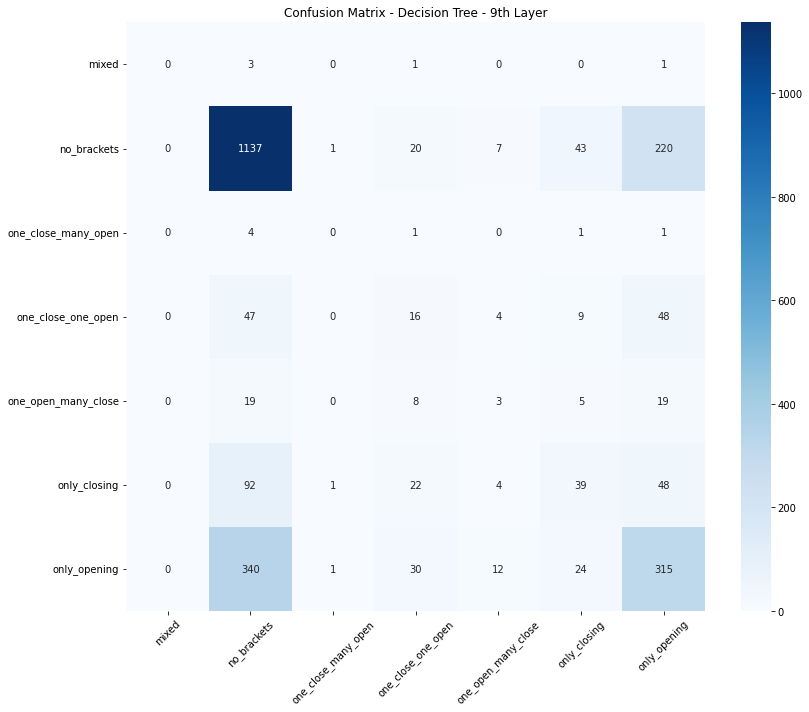


Random Forest Results (9th Layer):
Accuracy: 0.6760
F1 Score: 0.6076
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.68      0.97      0.80      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.00      0.00      0.00       124
one_open_many_close       0.00      0.00      0.00        54
       only_closing       1.00      0.04      0.08       206
       only_opening       0.65      0.46      0.54       722

           accuracy                           0.68      2546
          macro avg       0.33      0.21      0.20      2546
       weighted avg       0.65      0.68      0.61      2546



/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


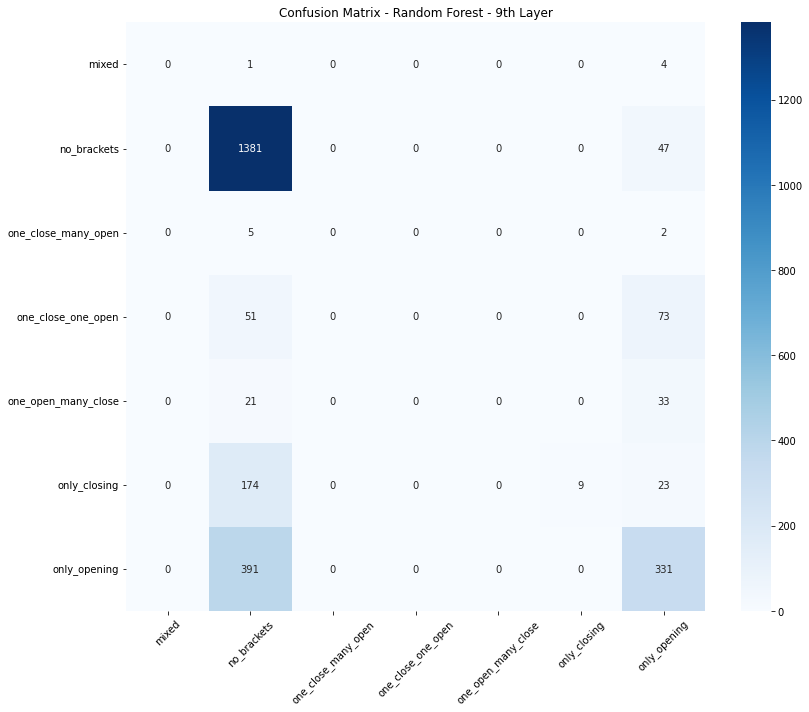

/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/6442845


K-Means Results:
Accuracy: 0.6626
F1 Score: 0.6042


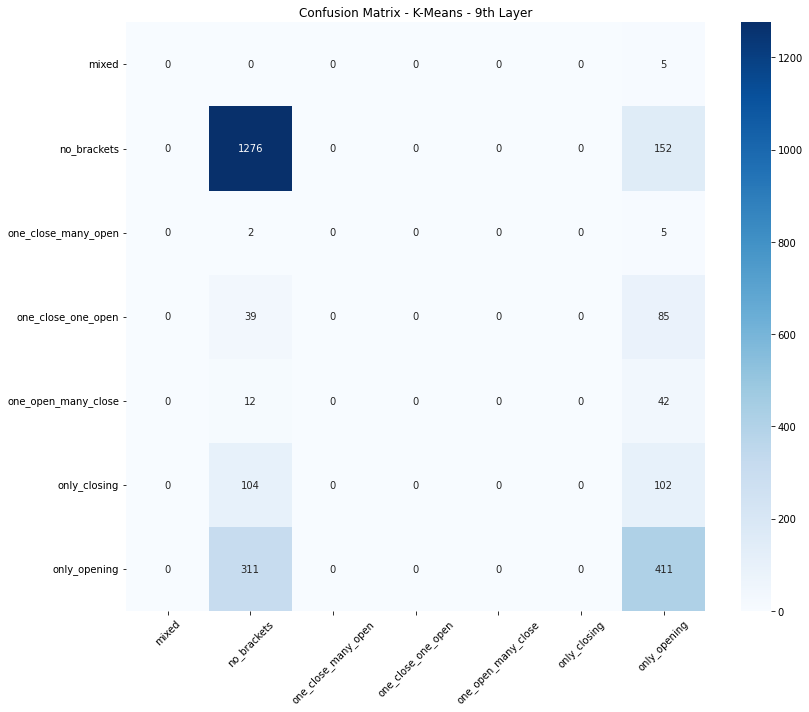


=== Анализ для 12th слоя ===

Decision Tree Results (12th Layer):
Accuracy: 0.5699
F1 Score: 0.5519
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.68      0.78      0.73      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.20      0.15      0.18       124
one_open_many_close       0.15      0.07      0.10        54
       only_closing       0.20      0.15      0.17       206
       only_opening       0.46      0.40      0.43       722

           accuracy                           0.57      2546
          macro avg       0.24      0.22      0.23      2546
       weighted avg       0.54      0.57      0.55      2546



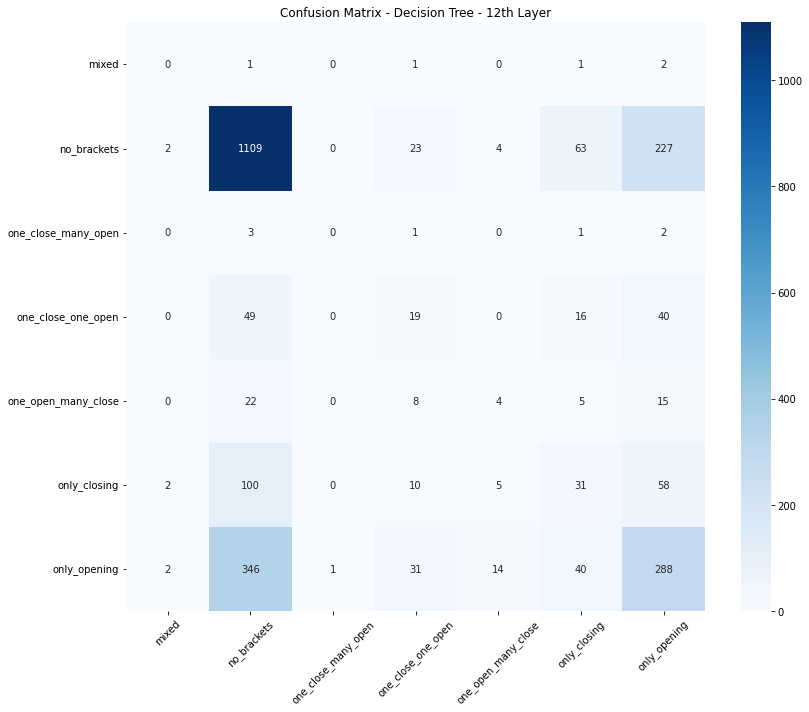


Random Forest Results (12th Layer):
Accuracy: 0.6697
F1 Score: 0.6001
                     precision    recall  f1-score   support

              mixed       0.00      0.00      0.00         5
        no_brackets       0.68      0.97      0.80      1428
one_close_many_open       0.00      0.00      0.00         7
 one_close_one_open       0.00      0.00      0.00       124
one_open_many_close       0.00      0.00      0.00        54
       only_closing       0.89      0.04      0.07       206
       only_opening       0.62      0.44      0.52       722

           accuracy                           0.67      2546
          macro avg       0.31      0.21      0.20      2546
       weighted avg       0.63      0.67      0.60      2546



/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


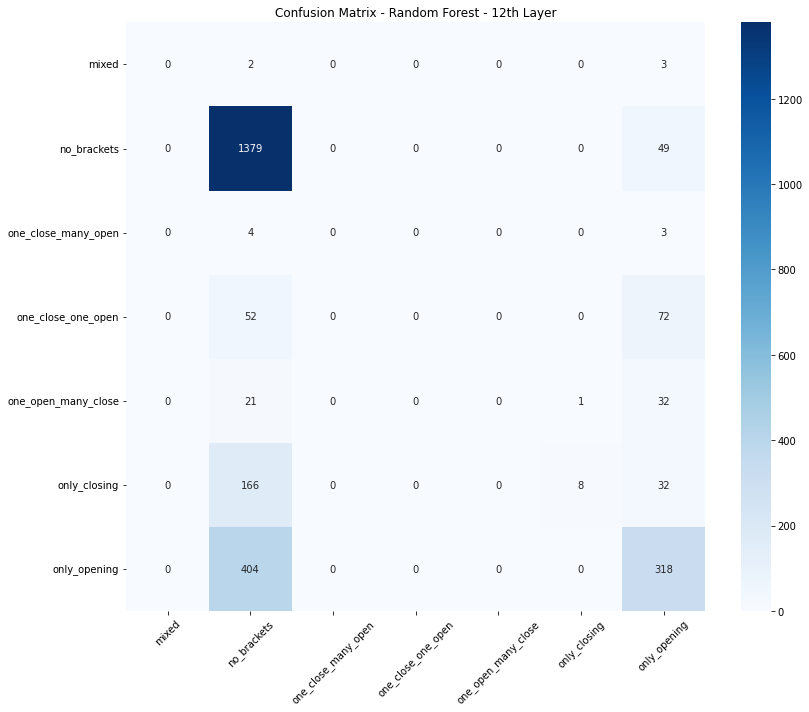

/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/644284551.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(y_test[mask])[0]
/tmp/ipykernel_208/6442845


K-Means Results:
Accuracy: 0.6587
F1 Score: 0.5987


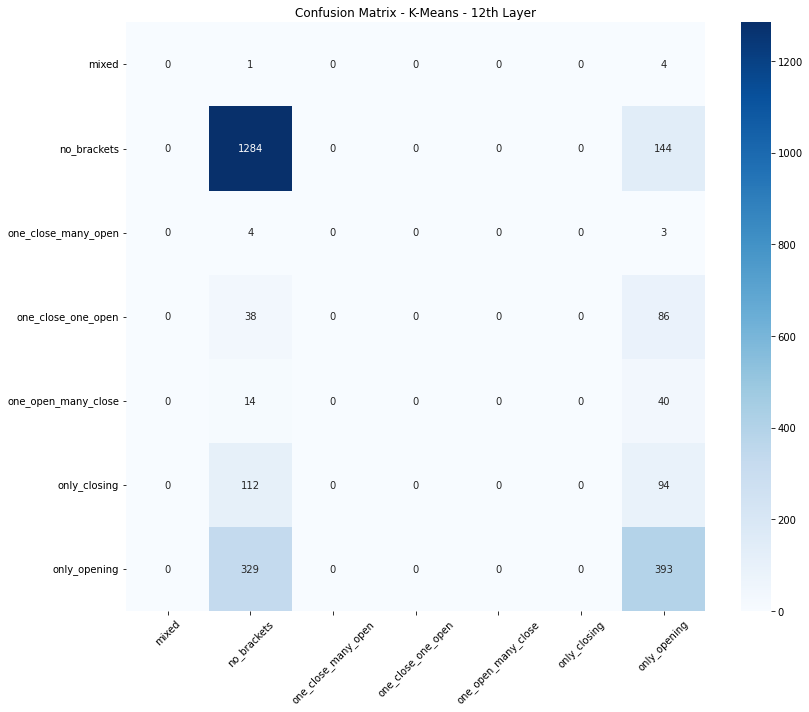

In [27]:

# Результаты для всех моделей и слоев
results = {
    'Decision Tree': {'acc': [], 'f1': []},
    'Random Forest': {'acc': [], 'f1': []},
    'K-Means': {'acc': [], 'f1': []}
}

# Обучение и оценка для каждого слоя
for layer in selected_layers:
    print(f"\n=== Анализ для {layer_names[layer]} слоя ===")
    
    if not X.get(layer) or len(X[layer]) < 10:  # Минимум 10 примеров
        print(f"Недостаточно данных для {layer_names[layer]} слоя")
        continue
    
    X_layer = np.array(X[layer])
    y_layer = np.array(y[layer])
    
    # Пропускаем слои с менее чем 2 классами
    if len(np.unique(y_layer)) < 2:
        print(f"Недостаточно классов для {layer_names[layer]} слоя")
        continue
    
    # Разделение и масштабирование
    X_train, X_test, y_train, y_test = train_test_split(
        X_layer, y_layer, test_size=0.2, random_state=42, stratify=y_layer
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Decision Tree
    dt = DecisionTreeClassifier(max_depth=10, random_state=42)
    dt_acc, dt_f1 = evaluate_model(
        dt, X_train_scaled, X_test_scaled, y_train, y_test,
        "Decision Tree", layer_names[layer]
    )
    results['Decision Tree']['acc'].append(dt_acc)
    results['Decision Tree']['f1'].append(dt_f1)
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_acc, rf_f1 = evaluate_model(
        rf, X_train_scaled, X_test_scaled, y_train, y_test,
        "Random Forest", layer_names[layer]
    )
    results['Random Forest']['acc'].append(rf_acc)
    results['Random Forest']['f1'].append(rf_f1)
    
    # K-Means (количество кластеров = количество классов)
    n_classes = len(np.unique(y_train))
    km = KMeans(n_clusters=n_classes, random_state=42)
    km.fit(X_train_scaled)
    
    # Для K-Means нужно сопоставить кластеры с реальными классами
    from scipy.stats import mode
    labels = np.zeros_like(km.predict(X_test_scaled))
    for i in range(n_classes):
        mask = (km.predict(X_test_scaled) == i)
        if mask.sum() > 0:
            labels[mask] = mode(y_test[mask])[0]
    
    km_acc = accuracy_score(y_test, labels)
    km_f1 = f1_score(y_test, labels, average='weighted')
    
    print("\nK-Means Results:")
    print(f"Accuracy: {km_acc:.4f}")
    print(f"F1 Score: {km_f1:.4f}")
    results['K-Means']['acc'].append(km_acc)
    results['K-Means']['f1'].append(km_f1)
    
    # Матрица ошибок для K-Means
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, labels)
    target_names = label_encoders[layer].classes_
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - K-Means - {layer_names[layer]} Layer')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    #plt.savefig(f'confusion_matrix_kmeans_{layer_names[layer]}.png', dpi=300)
    plt.show()


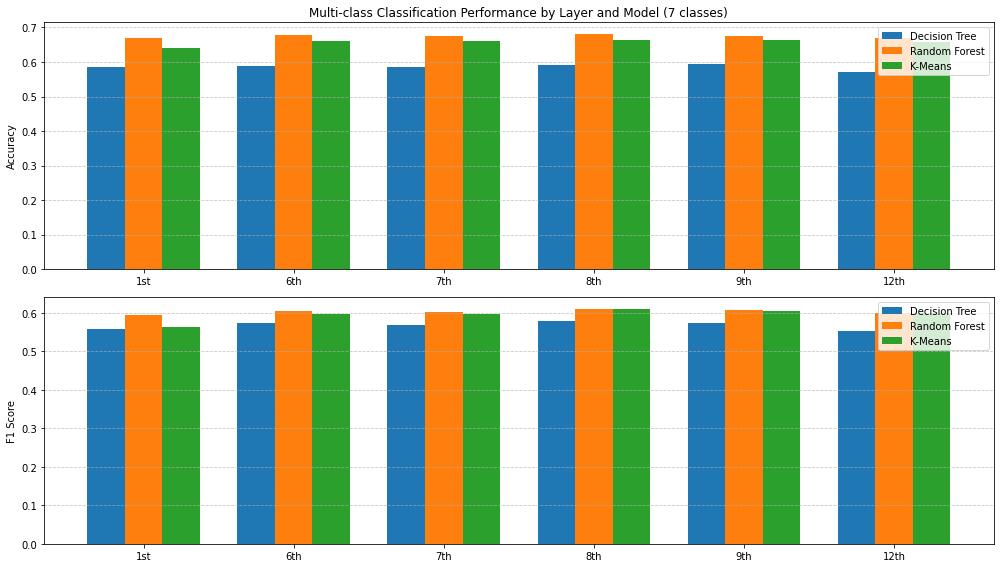

In [28]:

# Визуализация результатов по всем моделям
plt.figure(figsize=(14, 8))
x = np.arange(len(selected_layers))
width = 0.25

# График Accuracy
plt.subplot(2, 1, 1)
for i, (model, metrics) in enumerate(results.items()):
    plt.bar(x + i*width, metrics['acc'], width, label=model)
    
plt.ylabel('Accuracy')
plt.title('Multi-class Classification Performance by Layer and Model (7 classes)')
plt.xticks(x + width, [layer_names[l] for l in selected_layers])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# График F1 Score
plt.subplot(2, 1, 2)
for i, (model, metrics) in enumerate(results.items()):
    plt.bar(x + i*width, metrics['f1'], width, label=model)
    
plt.ylabel('F1 Score')
plt.xticks(x + width, [layer_names[l] for l in selected_layers])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
#plt.savefig('multi_class_performance_comparison_7classes.png', dpi=300)
plt.show()


/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna_mikhneva_/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


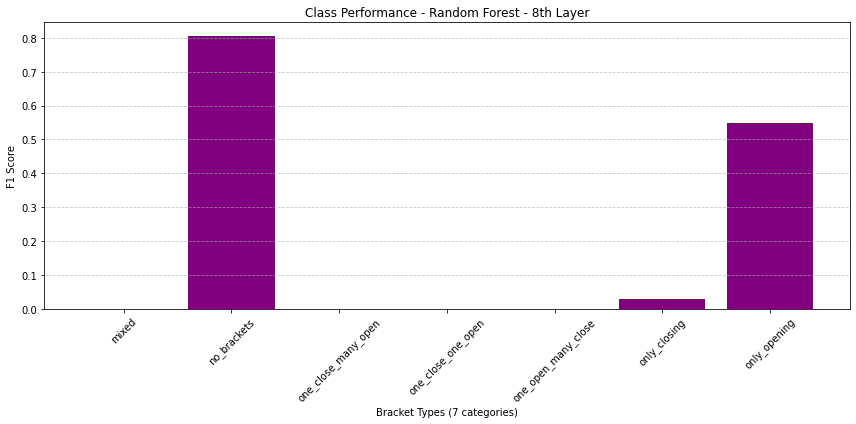

In [29]:
# Выбираем нужные слои (1-based индексы: 1,6,7,8,9,12)
selected_layers = [1, 6, 7, 8, 9, 12]
layer_names = {1: '1st', 6: '6th', 7: '7th', 8: '8th', 9: '9th', 12: '12th'}
# Анализ лучших классов для Random Forest
layer = 8  # Можно изменить на любой другой слой
if layer in selected_layers and X.get(layer) is not None:
    X_layer = np.array(X[layer])
    y_layer = np.array(y[layer])
    X_train, X_test, y_train, y_test = train_test_split(X_layer, y_layer, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Важность классов
    class_report = classification_report(y_test, rf.predict(X_test_scaled), 
                                      output_dict=True)
    classes = label_encoders[layer].classes_
    f1_scores = [class_report[str(i)]['f1-score'] for i in range(len(classes))]
    
    plt.figure(figsize=(12, 6))
    plt.bar(classes, f1_scores, color='purple')
    plt.xlabel('Bracket Types (7 categories)')
    plt.ylabel('F1 Score')
    plt.title(f'Class Performance - Random Forest - {layer_names[layer]} Layer')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'class_performance_rf_6classes_{layer_names[layer]}.png', dpi=300)
    plt.show()

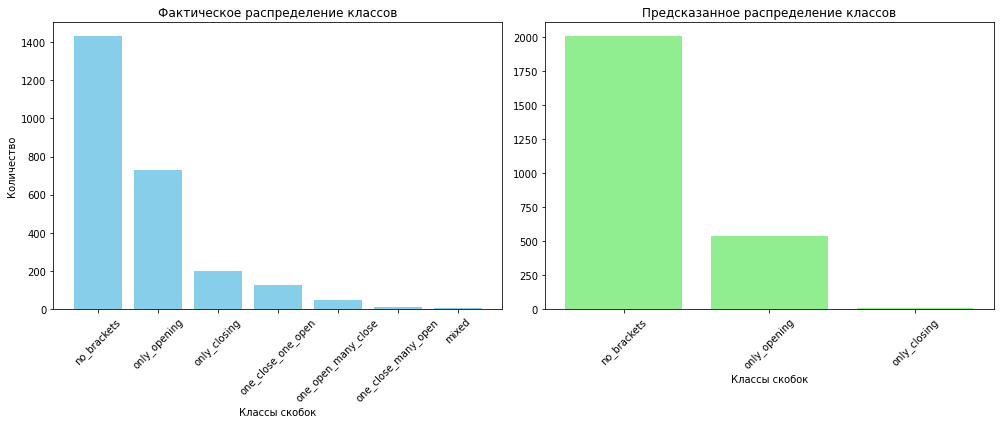

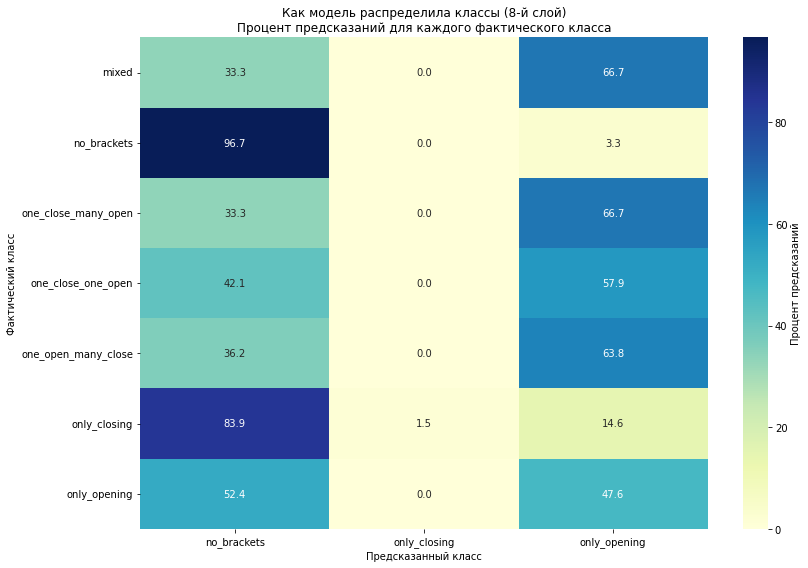


Подробная статистика по классам:

Класс: mixed
Всего примеров: 3
Правильно классифицировано: 0 (0.0%)
Ошибочно отнесено к:
only_opening    2
no_brackets     1

Класс: no_brackets
Всего примеров: 1433
Правильно классифицировано: 1386 (96.7%)
Ошибочно отнесено к:
only_opening    47

Класс: one_close_many_open
Всего примеров: 9
Правильно классифицировано: 0 (0.0%)
Ошибочно отнесено к:
only_opening    6
no_brackets     3

Класс: one_close_one_open
Всего примеров: 126
Правильно классифицировано: 0 (0.0%)
Ошибочно отнесено к:
only_opening    73
no_brackets     53

Класс: one_open_many_close
Всего примеров: 47
Правильно классифицировано: 0 (0.0%)
Ошибочно отнесено к:
only_opening    30
no_brackets     17

Класс: only_closing
Всего примеров: 199
Правильно классифицировано: 3 (1.5%)
Ошибочно отнесено к:
no_brackets     167
only_opening     29

Класс: only_opening
Всего примеров: 729
Правильно классифицировано: 347 (47.6%)
Ошибочно отнесено к:
no_brackets    382


In [30]:
# Анализ распределения предсказаний для Random Forest на 8-м слое
layer = 8  # Можно изменить на любой другой слой
if layer in selected_layers and X.get(layer) is not None:
    X_layer = np.array(X[layer])
    y_layer = np.array(y[layer])
    X_train, X_test, y_train, y_test = train_test_split(X_layer, y_layer, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Получаем предсказания
    y_pred = rf.predict(X_test_scaled)
    
    # Декодируем метки классов
    classes = label_encoders[layer].classes_
    y_test_decoded = [classes[i] for i in y_test]
    y_pred_decoded = [classes[i] for i in y_pred]
    
    # Создаем DataFrame для анализа
    import pandas as pd
    df_results = pd.DataFrame({
        'Actual': y_test_decoded,
        'Predicted': y_pred_decoded
    })
    
    # 1. Распределение фактических и предсказанных классов
    plt.figure(figsize=(14, 6))
    
    # Фактическое распределение
    plt.subplot(1, 2, 1)
    actual_counts = df_results['Actual'].value_counts()
    plt.bar(actual_counts.index, actual_counts.values, color='skyblue')
    plt.title('Фактическое распределение классов')
    plt.xlabel('Классы скобок')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    
    # Предсказанное распределение
    plt.subplot(1, 2, 2)
    predicted_counts = df_results['Predicted'].value_counts()
    plt.bar(predicted_counts.index, predicted_counts.values, color='lightgreen')
    plt.title('Предсказанное распределение классов')
    plt.xlabel('Классы скобок')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'actual_vs_predicted_distribution_{layer_names[layer]}.png', dpi=300)
    plt.show()
    
    # 2. Матрица переходов между фактическими и предсказанными классами
    cross_tab = pd.crosstab(df_results['Actual'], df_results['Predicted'], 
                           normalize='index') * 100
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='YlGnBu', 
                cbar_kws={'label': 'Процент предсказаний'})
    plt.title(f'Как модель распределила классы (8-й слой)\nПроцент предсказаний для каждого фактического класса')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Фактический класс')
    plt.tight_layout()
    plt.savefig(f'class_distribution_matrix_{layer_names[layer]}.png', dpi=300)
    plt.show()
    
    # 3. Статистика по каждому классу
    print("\nПодробная статистика по классам:")
    for cls in classes:
        cls_data = df_results[df_results['Actual'] == cls]
        if not cls_data.empty:
            correct = sum(cls_data['Actual'] == cls_data['Predicted'])
            total = len(cls_data)
            print(f"\nКласс: {cls}")
            print(f"Всего примеров: {total}")
            print(f"Правильно классифицировано: {correct} ({correct/total:.1%})")
            print("Ошибочно отнесено к:")
            wrong = cls_data[cls_data['Actual'] != cls_data['Predicted']]
            print(wrong['Predicted'].value_counts().to_string())


=== Анализ для 1st слоя ===


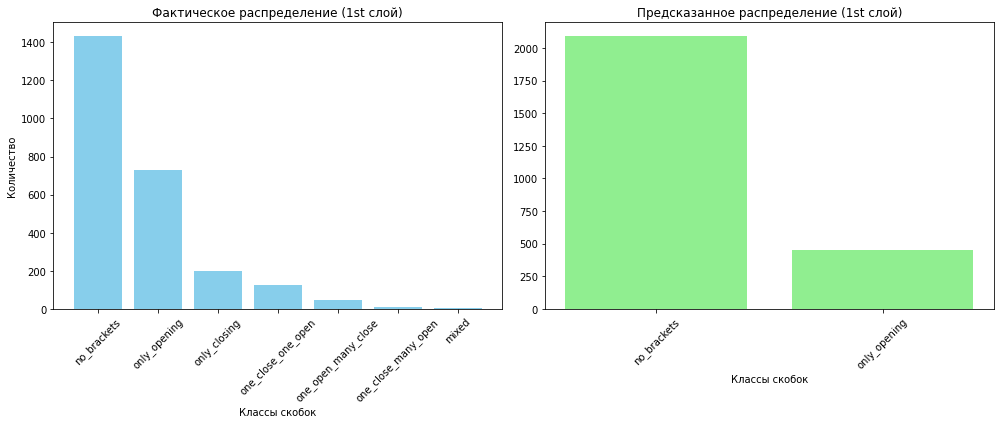

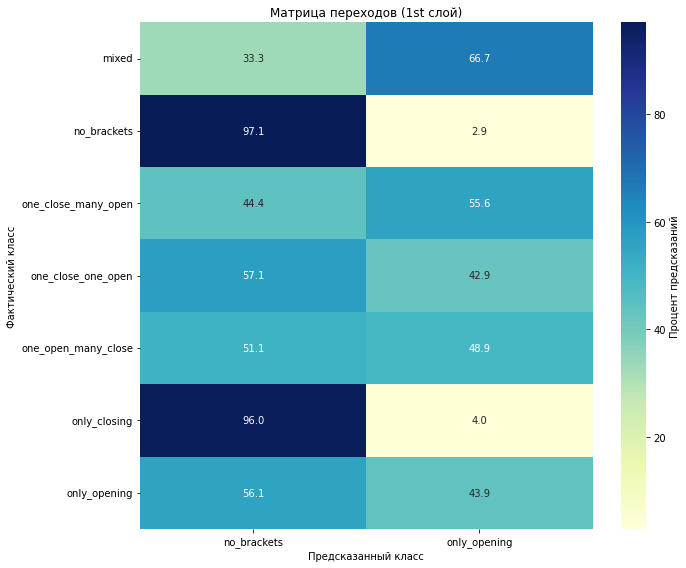


Статистика по классам:

Класс mixed:
  Точность: 0.0%
  Ошибки:
only_opening    2
no_brackets     1

Класс no_brackets:
  Точность: 97.1%
  Ошибки:
only_opening    42

Класс one_close_many_open:
  Точность: 0.0%
  Ошибки:
only_opening    5
no_brackets     4

Класс one_close_one_open:
  Точность: 0.0%
  Ошибки:
no_brackets     72
only_opening    54

Класс one_open_many_close:
  Точность: 0.0%
  Ошибки:
no_brackets     24
only_opening    23

Класс only_closing:
  Точность: 0.0%
  Ошибки:
no_brackets     191
only_opening      8

Класс only_opening:
  Точность: 43.9%
  Ошибки:
no_brackets    409

=== Анализ для 6th слоя ===


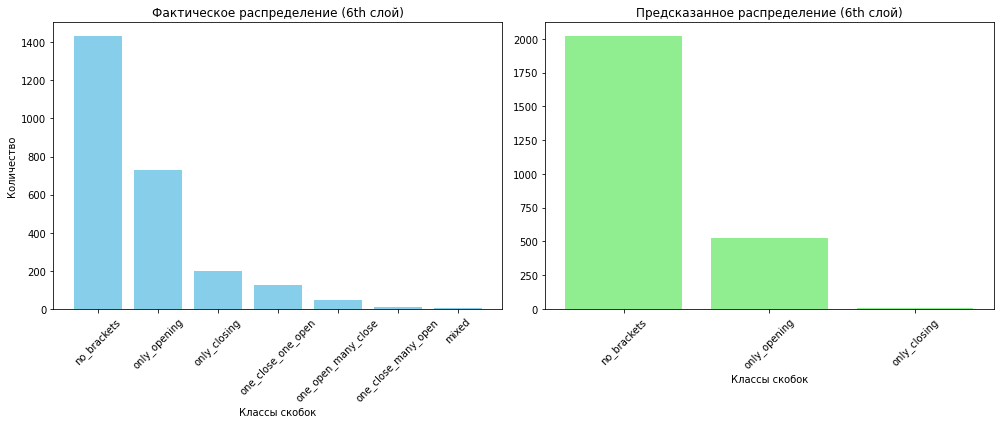

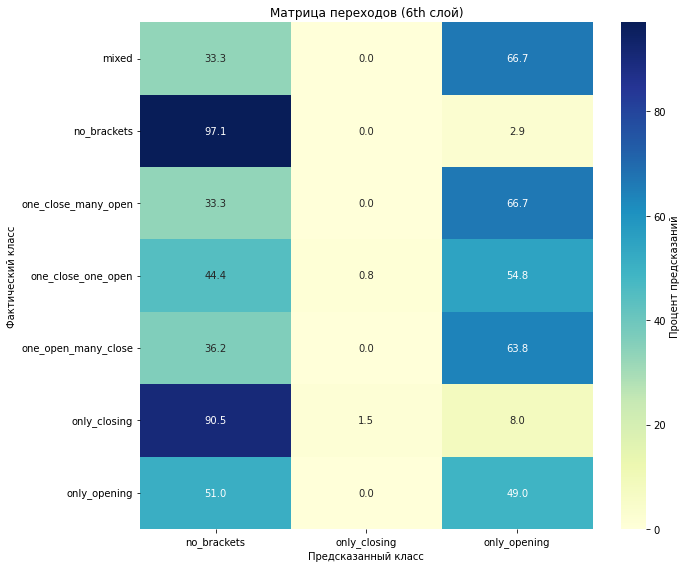


Статистика по классам:

Класс mixed:
  Точность: 0.0%
  Ошибки:
only_opening    2
no_brackets     1

Класс no_brackets:
  Точность: 97.1%
  Ошибки:
only_opening    42

Класс one_close_many_open:
  Точность: 0.0%
  Ошибки:
only_opening    6
no_brackets     3

Класс one_close_one_open:
  Точность: 0.0%
  Ошибки:
only_opening    69
no_brackets     56
only_closing     1

Класс one_open_many_close:
  Точность: 0.0%
  Ошибки:
only_opening    30
no_brackets     17

Класс only_closing:
  Точность: 1.5%
  Ошибки:
no_brackets     180
only_opening     16

Класс only_opening:
  Точность: 49.0%
  Ошибки:
no_brackets    372

=== Анализ для 7th слоя ===


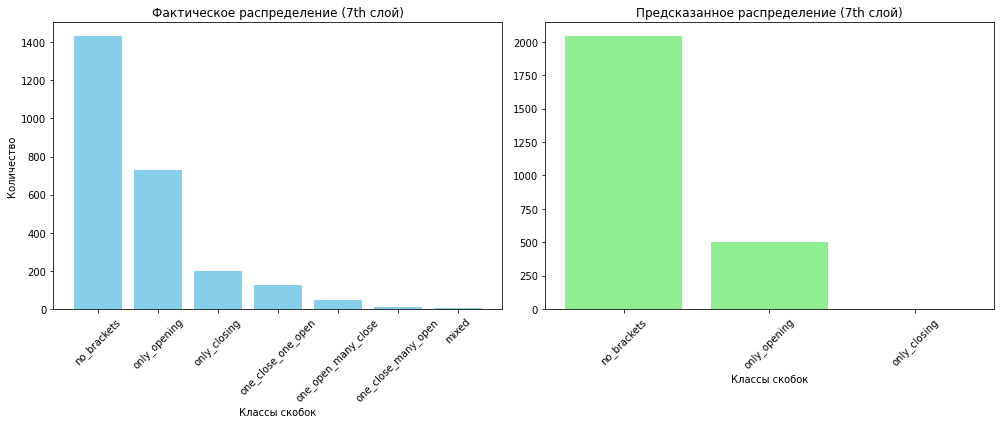

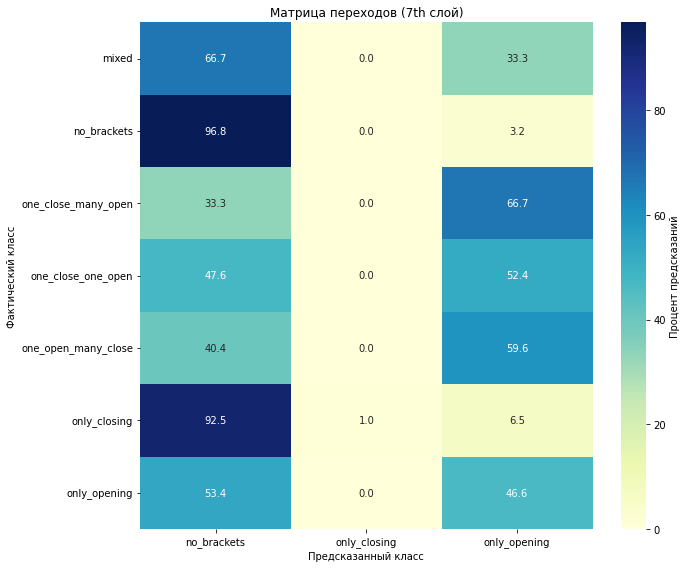


Статистика по классам:

Класс mixed:
  Точность: 0.0%
  Ошибки:
no_brackets     2
only_opening    1

Класс no_brackets:
  Точность: 96.8%
  Ошибки:
only_opening    46

Класс one_close_many_open:
  Точность: 0.0%
  Ошибки:
only_opening    6
no_brackets     3

Класс one_close_one_open:
  Точность: 0.0%
  Ошибки:
only_opening    66
no_brackets     60

Класс one_open_many_close:
  Точность: 0.0%
  Ошибки:
only_opening    28
no_brackets     19

Класс only_closing:
  Точность: 1.0%
  Ошибки:
no_brackets     184
only_opening     13

Класс only_opening:
  Точность: 46.6%
  Ошибки:
no_brackets    389

=== Анализ для 8th слоя ===


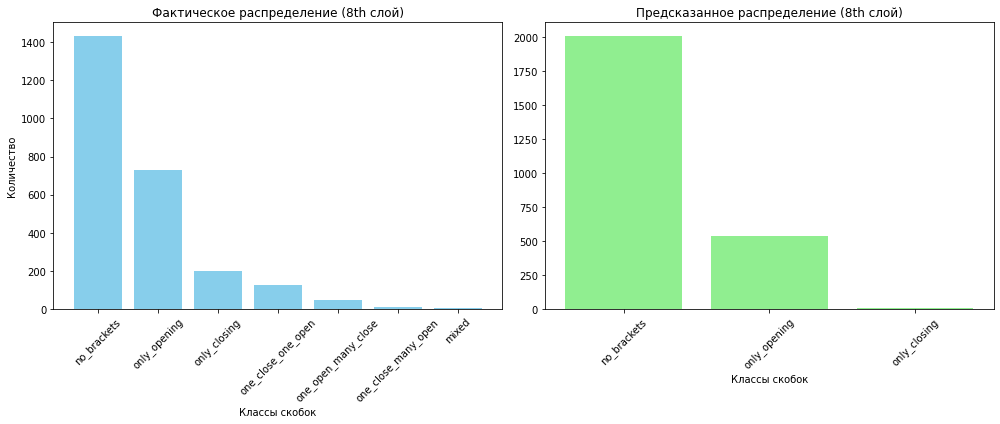

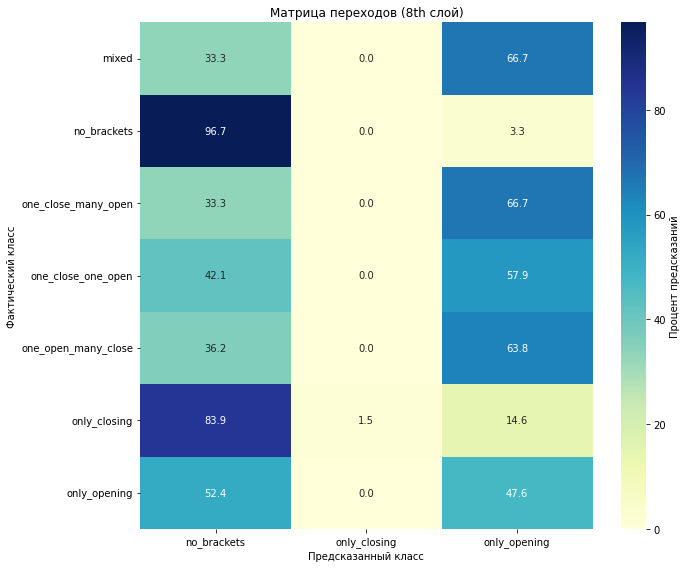


Статистика по классам:

Класс mixed:
  Точность: 0.0%
  Ошибки:
only_opening    2
no_brackets     1

Класс no_brackets:
  Точность: 96.7%
  Ошибки:
only_opening    47

Класс one_close_many_open:
  Точность: 0.0%
  Ошибки:
only_opening    6
no_brackets     3

Класс one_close_one_open:
  Точность: 0.0%
  Ошибки:
only_opening    73
no_brackets     53

Класс one_open_many_close:
  Точность: 0.0%
  Ошибки:
only_opening    30
no_brackets     17

Класс only_closing:
  Точность: 1.5%
  Ошибки:
no_brackets     167
only_opening     29

Класс only_opening:
  Точность: 47.6%
  Ошибки:
no_brackets    382

=== Анализ для 9th слоя ===


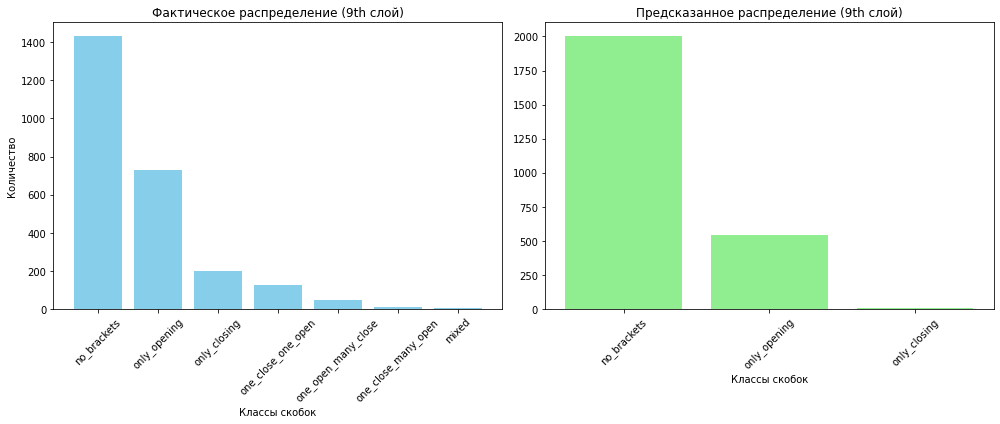

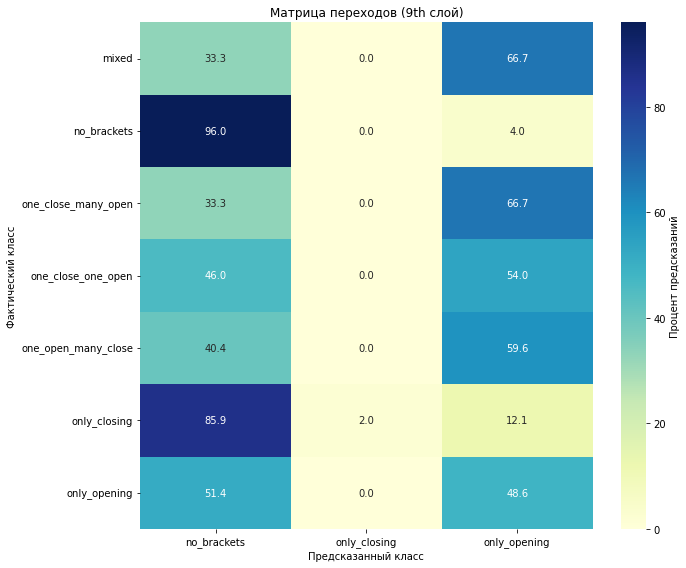


Статистика по классам:

Класс mixed:
  Точность: 0.0%
  Ошибки:
only_opening    2
no_brackets     1

Класс no_brackets:
  Точность: 96.0%
  Ошибки:
only_opening    57

Класс one_close_many_open:
  Точность: 0.0%
  Ошибки:
only_opening    6
no_brackets     3

Класс one_close_one_open:
  Точность: 0.0%
  Ошибки:
only_opening    68
no_brackets     58

Класс one_open_many_close:
  Точность: 0.0%
  Ошибки:
only_opening    28
no_brackets     19

Класс only_closing:
  Точность: 2.0%
  Ошибки:
no_brackets     171
only_opening     24

Класс only_opening:
  Точность: 48.6%
  Ошибки:
no_brackets    375

=== Анализ для 12th слоя ===


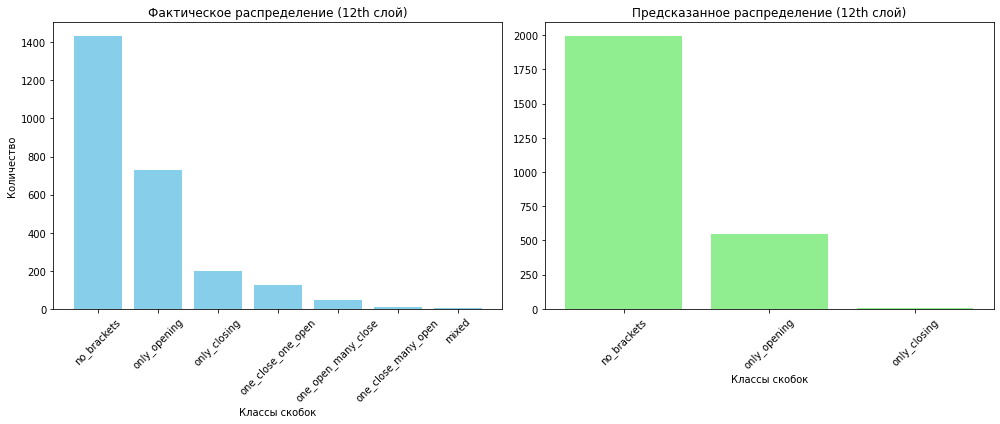

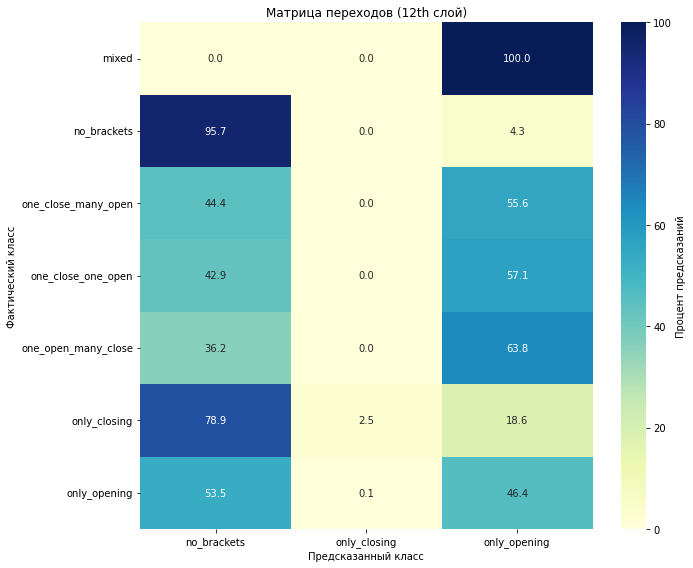


Статистика по классам:

Класс mixed:
  Точность: 0.0%
  Ошибки:
only_opening    3

Класс no_brackets:
  Точность: 95.7%
  Ошибки:
only_opening    62

Класс one_close_many_open:
  Точность: 0.0%
  Ошибки:
only_opening    5
no_brackets     4

Класс one_close_one_open:
  Точность: 0.0%
  Ошибки:
only_opening    72
no_brackets     54

Класс one_open_many_close:
  Точность: 0.0%
  Ошибки:
only_opening    30
no_brackets     17

Класс only_closing:
  Точность: 2.5%
  Ошибки:
no_brackets     157
only_opening     37

Класс only_opening:
  Точность: 46.4%
  Ошибки:
no_brackets     390
only_closing      1


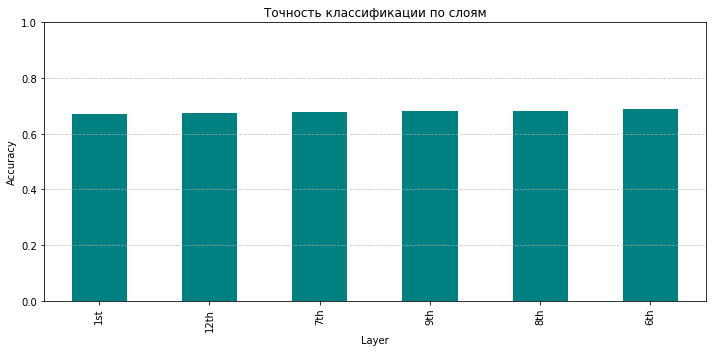

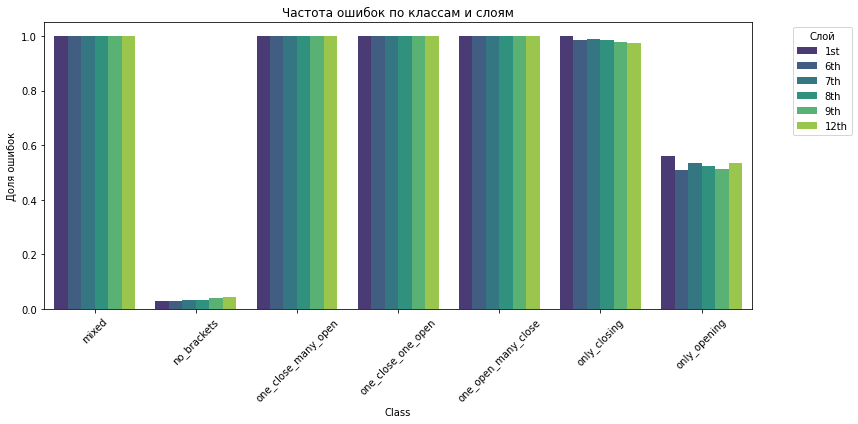

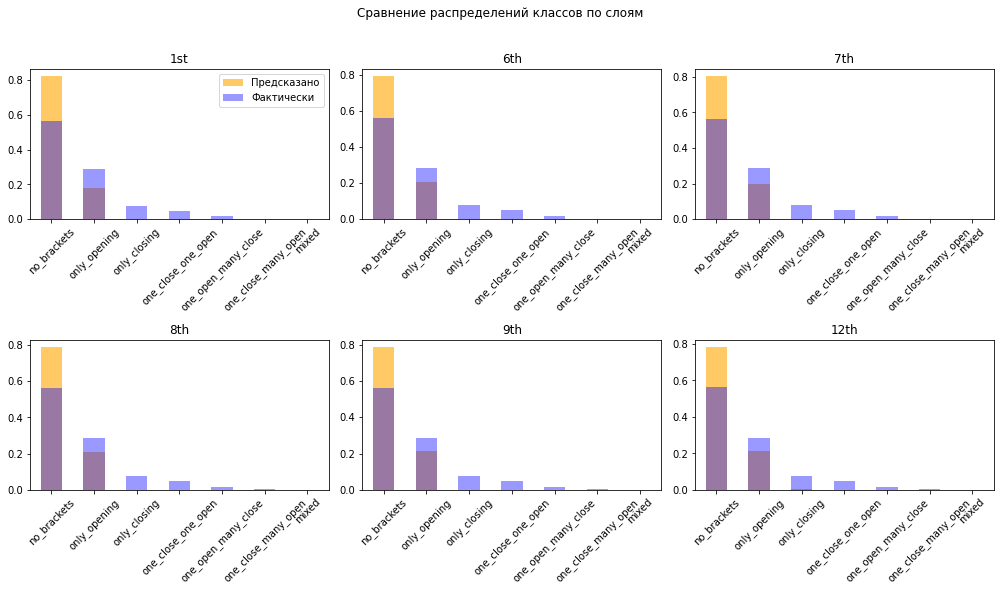

In [31]:
# Создаем структуру для хранения результатов по всем слоям
all_layers_results = []

# Анализ для каждого слоя
for layer in [1, 6, 7, 8, 9, 12]:
    if layer not in selected_layers or X.get(layer) is None:
        continue
        
    print(f"\n=== Анализ для {layer_names[layer]} слоя ===")
    
    X_layer = np.array(X[layer])
    y_layer = np.array(y[layer])
    
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X_layer, y_layer, test_size=0.2, random_state=42
    )
    
    # Масштабирование
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Обучение модели
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Предсказания
    y_pred = rf.predict(X_test_scaled)
    
    # Декодируем метки классов
    classes = label_encoders[layer].classes_
    y_test_decoded = [classes[i] for i in y_test]
    y_pred_decoded = [classes[i] for i in y_pred]
    
    # Создаем DataFrame для анализа
    df_results = pd.DataFrame({
        'Actual': y_test_decoded,
        'Predicted': y_pred_decoded,
        'Layer': layer_names[layer]
    })
    
    # Сохраняем результаты для итогового сравнения
    all_layers_results.append(df_results)
    
    # 1. Распределение классов
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    actual_counts = df_results['Actual'].value_counts()
    plt.bar(actual_counts.index, actual_counts.values, color='skyblue')
    plt.title(f'Фактическое распределение ({layer_names[layer]} слой)')
    plt.xlabel('Классы скобок')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    predicted_counts = df_results['Predicted'].value_counts()
    plt.bar(predicted_counts.index, predicted_counts.values, color='lightgreen')
    plt.title(f'Предсказанное распределение ({layer_names[layer]} слой)')
    plt.xlabel('Классы скобок')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'distribution_{layer_names[layer]}.png', dpi=300)
    plt.show()
    
    # 2. Матрица переходов
    cross_tab = pd.crosstab(
        index=df_results['Actual'],
        columns=df_results['Predicted'],
        normalize='index'
    ) * 100
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='YlGnBu',
                cbar_kws={'label': 'Процент предсказаний'})
    plt.title(f'Матрица переходов ({layer_names[layer]} слой)')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Фактический класс')
    plt.tight_layout()
    plt.savefig(f'transition_matrix_{layer_names[layer]}.png', dpi=300)
    plt.show()
    
    # 3. Статистика по классам
    print("\nСтатистика по классам:")
    for cls in classes:
        cls_data = df_results[df_results['Actual'] == cls]
        if not cls_data.empty:
            correct = sum(cls_data['Actual'] == cls_data['Predicted'])
            total = len(cls_data)
            print(f"\nКласс {cls}:")
            print(f"  Точность: {correct/total:.1%}")
            print("  Ошибки:")
            errors = cls_data[cls_data['Actual'] != cls_data['Predicted']]
            print(errors['Predicted'].value_counts().to_string())

# Сравнительный анализ по всем слоям
if all_layers_results:
    # Объединяем результаты всех слоев
    all_results = pd.concat(all_layers_results)
    
    # 1. Сравнение точности по слоям
    layer_accuracy = all_results.groupby('Layer').apply(
        lambda x: sum(x['Actual'] == x['Predicted']) / len(x)
    )
    
    plt.figure(figsize=(10, 5))
    layer_accuracy.sort_values().plot(kind='bar', color='teal')
    plt.title('Точность классификации по слоям')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('accuracy_by_layer.png', dpi=300)
    plt.show()
    
    # 2. Распределение ошибок по классам и слоям
    error_rates = []
    for layer_df in all_layers_results:
        layer_name = layer_df['Layer'].iloc[0]
        for cls in classes:
            cls_data = layer_df[layer_df['Actual'] == cls]
            if len(cls_data) > 0:
                error_rate = 1 - sum(cls_data['Actual'] == cls_data['Predicted'])/len(cls_data)
                error_rates.append({
                    'Layer': layer_name,
                    'Class': cls,
                    'Error Rate': error_rate
                })
    
    error_df = pd.DataFrame(error_rates)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=error_df, x='Class', y='Error Rate', hue='Layer',
                palette='viridis')
    plt.title('Частота ошибок по классам и слоям')
    plt.xticks(rotation=45)
    plt.ylabel('Доля ошибок')
    plt.legend(title='Слой', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('error_rates_by_class_and_layer.png', dpi=300)
    plt.show()
    
    # 3. Сравнение распределений классов
    plt.figure(figsize=(14, 8))
    for i, layer_df in enumerate(all_layers_results):
        plt.subplot(2, 3, i+1)
        layer_name = layer_df['Layer'].iloc[0]
        pred_counts = layer_df['Predicted'].value_counts(normalize=True)
        pred_counts.plot(kind='bar', color='orange', alpha=0.6, label='Предсказано')
        actual_counts = layer_df['Actual'].value_counts(normalize=True)
        actual_counts.plot(kind='bar', color='blue', alpha=0.4, label='Фактически')
        plt.title(layer_name)
        plt.xticks(rotation=45)
        if i == 0:
            plt.legend()
    
    plt.suptitle('Сравнение распределений классов по слоям', y=1.02)
    plt.tight_layout()
    plt.savefig('class_distribution_comparison.png', dpi=300)
    plt.show()

In [16]:
# Функция для вычисления косинусной близости
def cos(v1, v2):
    return torch.nn.functional.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()

# Собираем данные для всех слоев
all_layers_boundary = [defaultdict(list) for _ in range(12)]  # 12 слоев

for n in new_data[:1000]:
    # Получаем векторы для всех слоев
    all_layers_vectors = vectors_for_word_all_layers(n[0])  # предполагая, что n[0] - это текст
    
    for layer in range(12):
        layer_vectors = all_layers_vectors[layer]
        
        if len(n[1][0]) != 0:  # слова на границах клауз
            for i in n[1][0]:
                if i[0] < len(layer_vectors) and i[1] < len(layer_vectors):
                    output = cos(layer_vectors[i[0]], layer_vectors[i[1]])
                    all_layers_boundary[layer][i[2]].append(output)
        
        if len(n[1][1]) != 0:  # слова не на границах клауз
            for i in n[1][1]:
                if i[0] < len(layer_vectors) and i[1] < len(layer_vectors):
                    output = cos(layer_vectors[i[0]], layer_vectors[i[1]])
                    all_layers_boundary[layer]['0'].append(output)

In [18]:
# Функция для подсчета общего количества скобок (без разбора типов)
def count_brackets(b_type):
    if b_type == '0':
        return 0
    return len(b_type)  # Просто считаем все символы в строке скобок

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


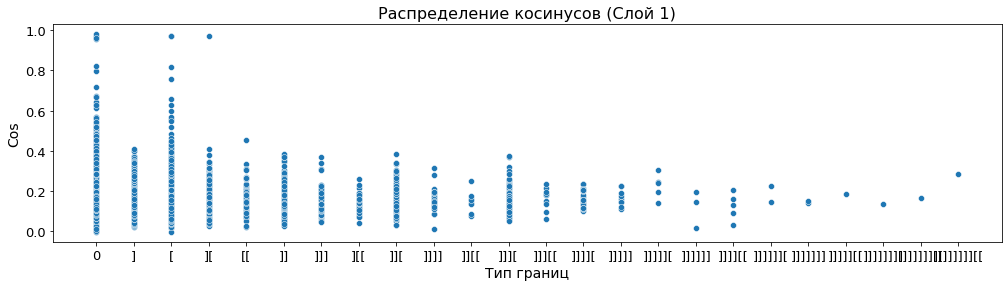

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


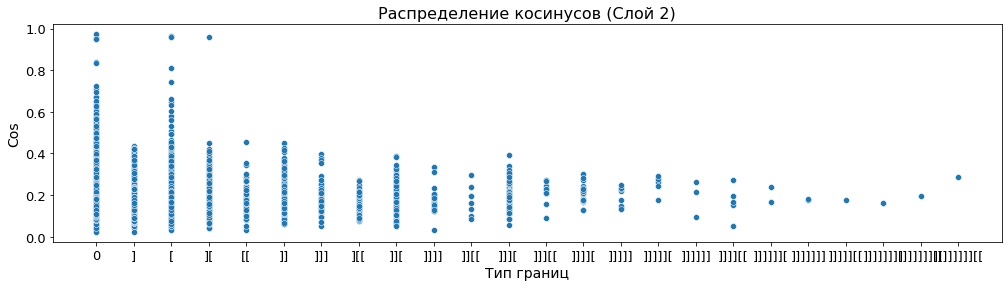

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


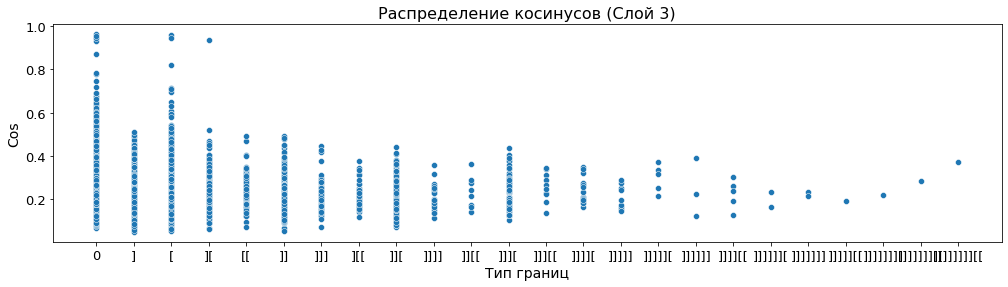

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


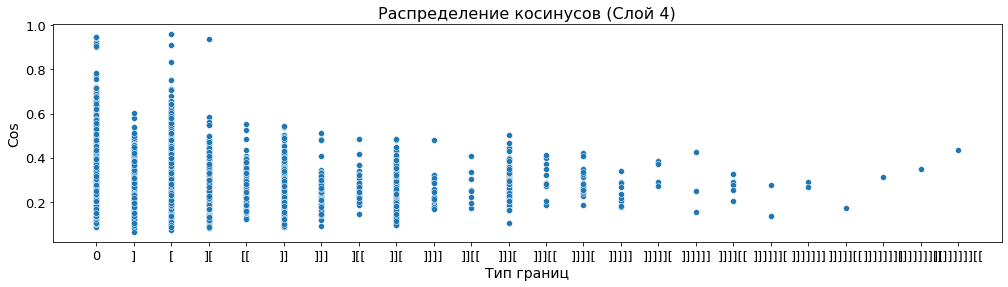

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


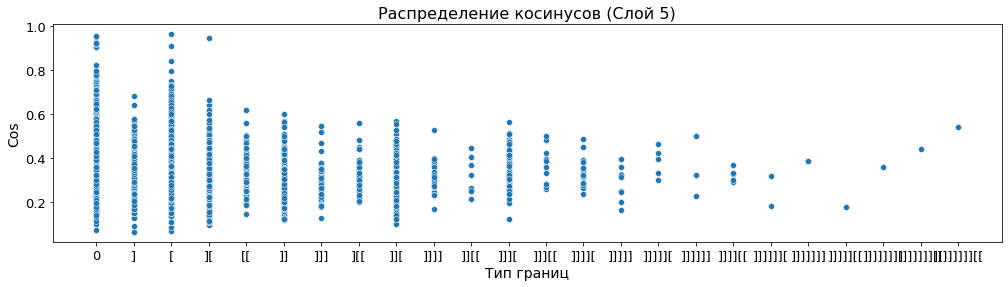

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


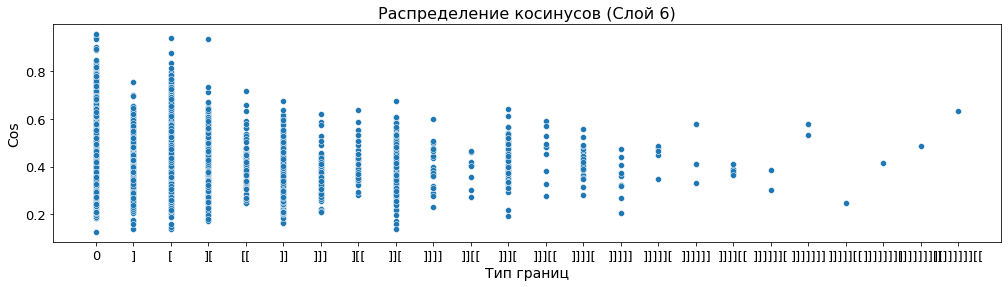

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


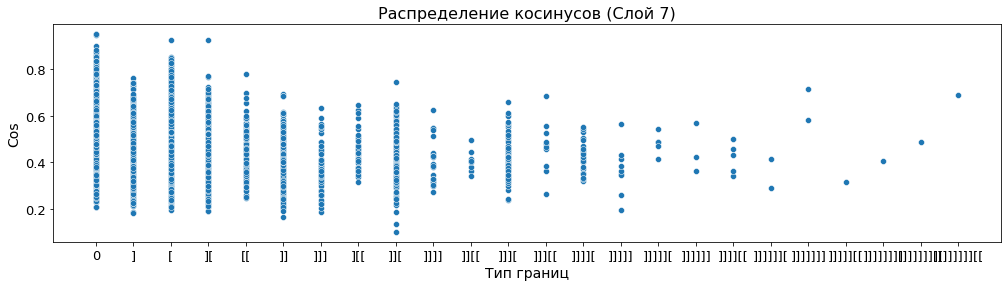

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


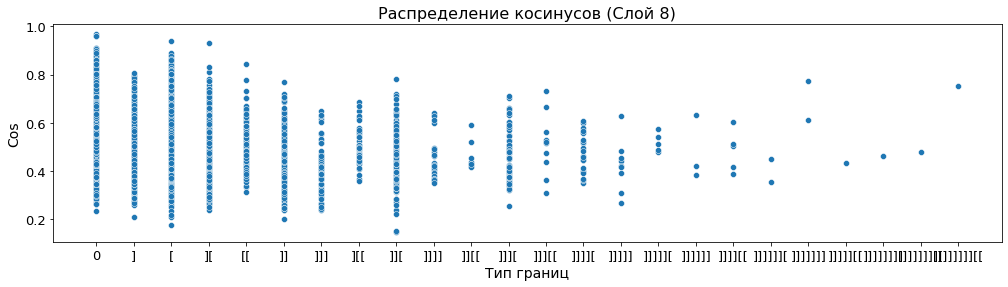

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


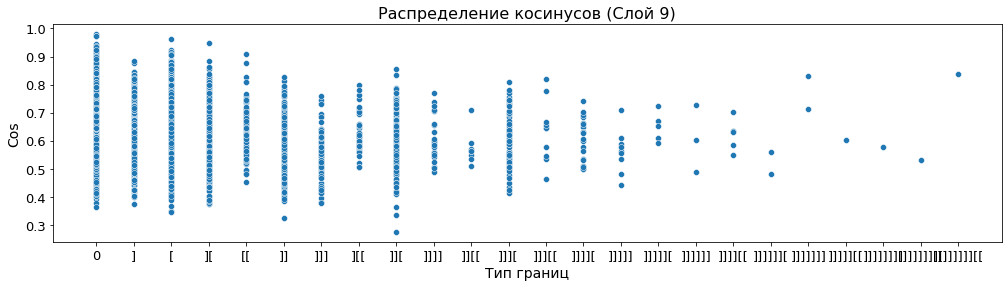

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


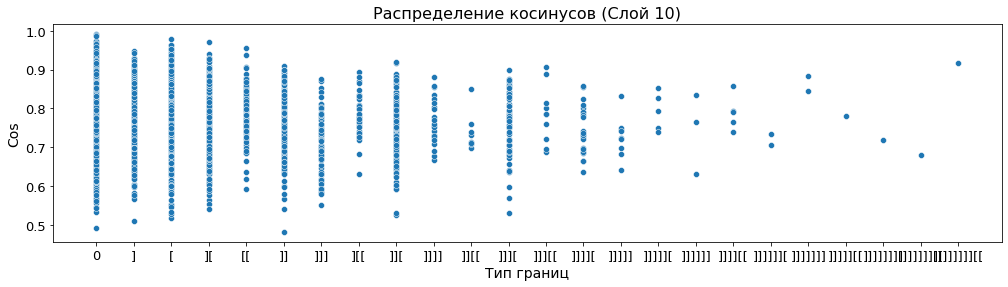

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


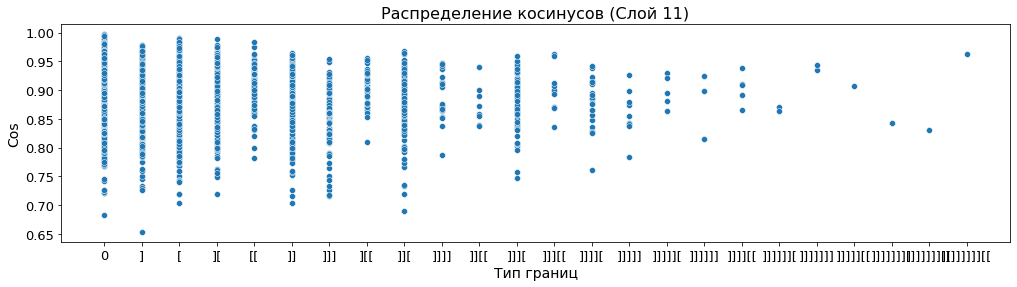

/tmp/ipykernel_153/3093116520.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


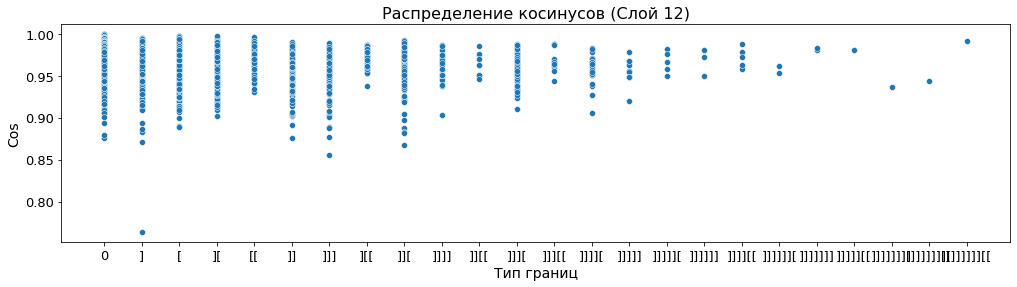

In [19]:
# Строим графики для каждого слоя
for layer in range(12):
    # Преобразуем данные для текущего слоя в DataFrame
    layer_data = []
    for bracket_type, cos_values in all_layers_boundary[layer].items():
        for val in cos_values:
            layer_data.append({'bracket_type': bracket_type, 'cos': val})
    
    if not layer_data:  # если нет данных для этого слоя
        continue
        
    result = pd.DataFrame(layer_data)
    result['bracket_count'] = result['bracket_type'].apply(count_brackets)
    
    # Сортируем данные по количеству скобок
    result = result.sort_values('bracket_count')
    plt.figure(figsize=(17, 4))
    ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')
    ax.set_ylabel("Cos", fontsize=14)
    ax.set_xlabel("Тип границ", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.title(f'Распределение косинусов (Слой {layer+1})', fontsize=16)
    plt.savefig(f'graphs_linear0_small/scatt_layer_{layer+1}.png')
    plt.show()

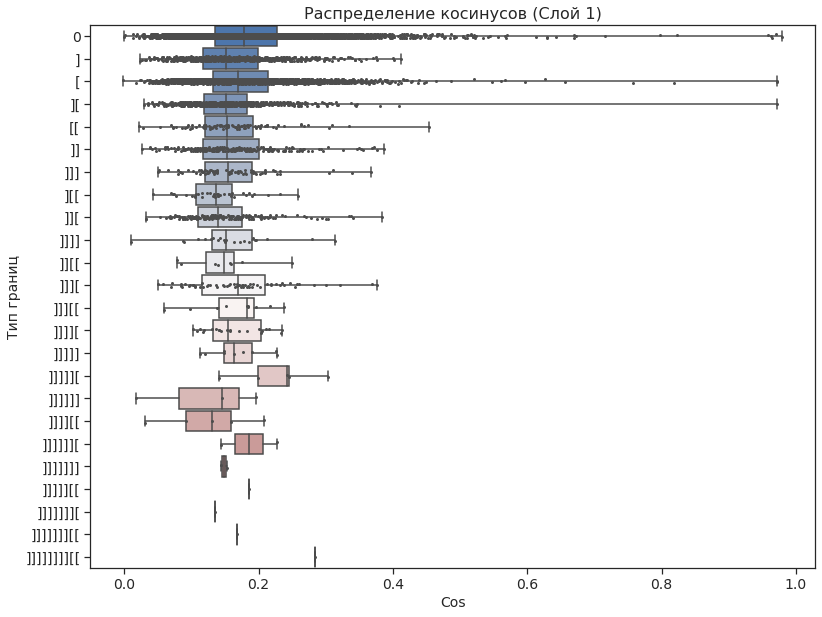

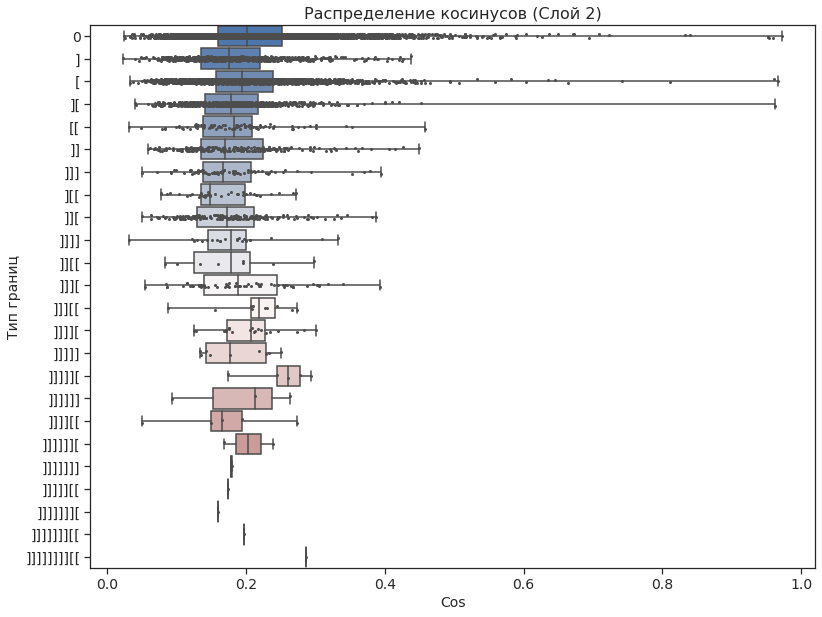

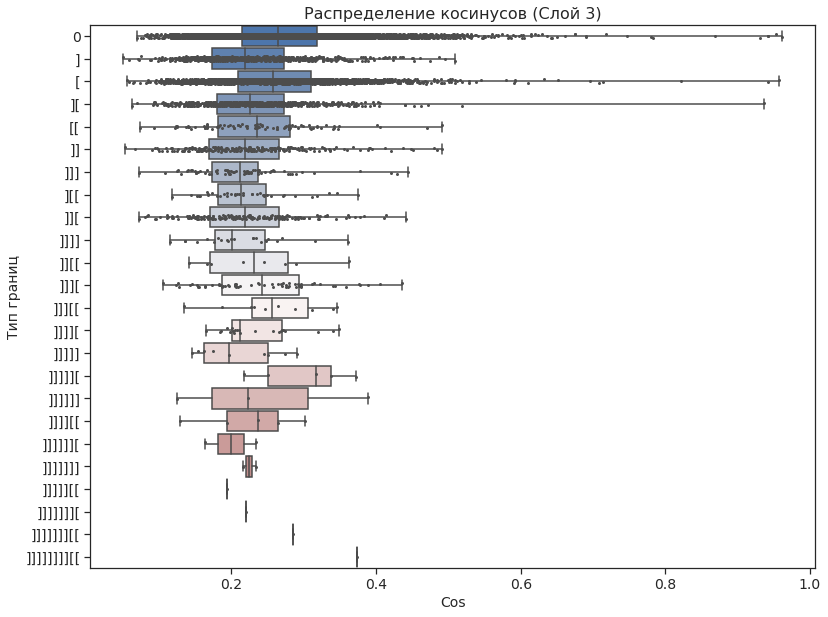

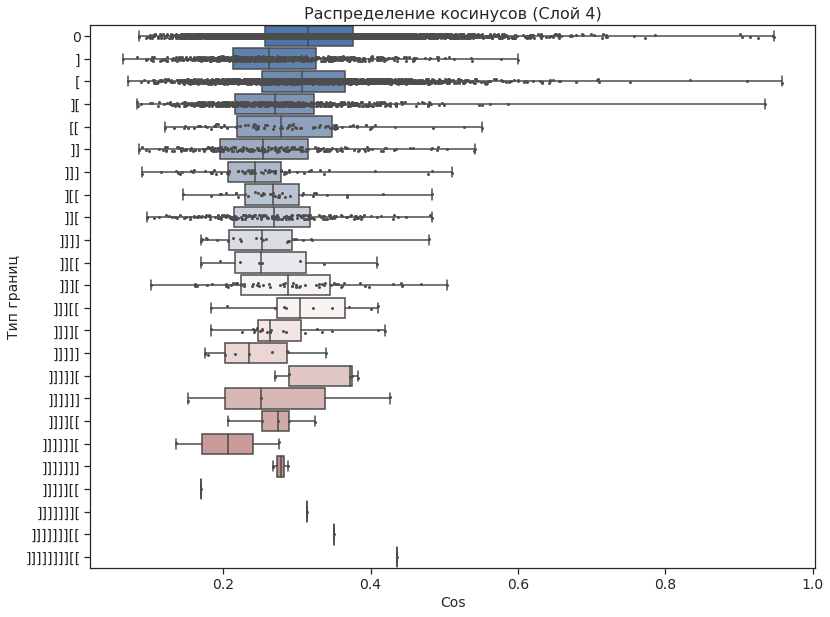

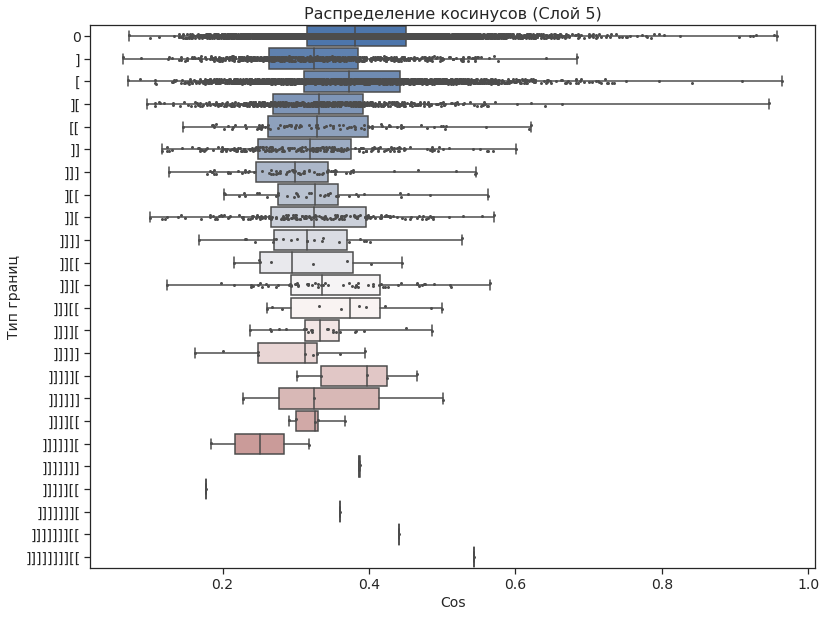

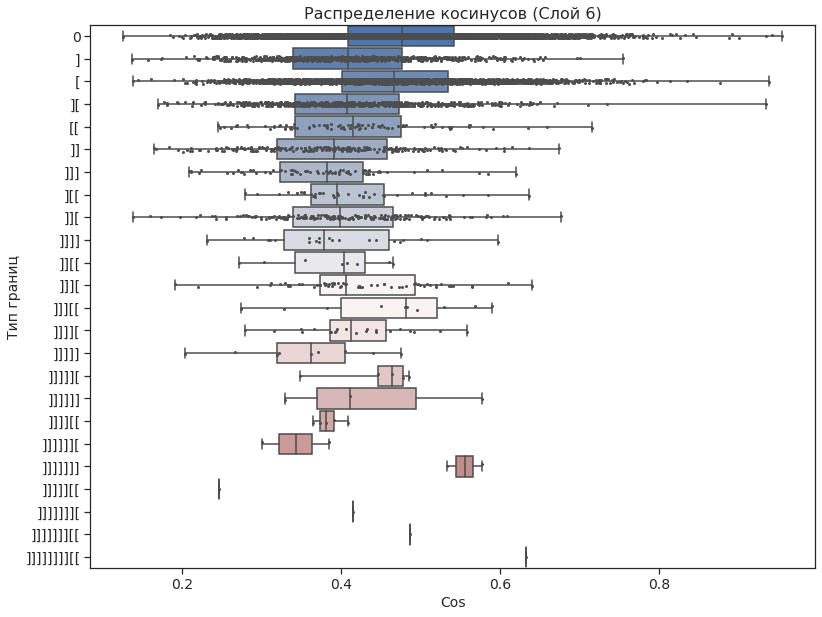

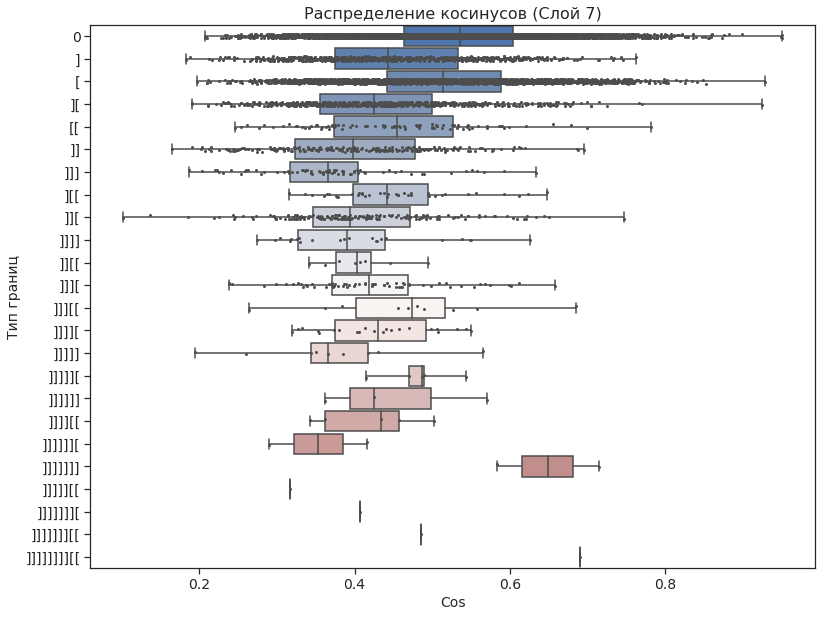

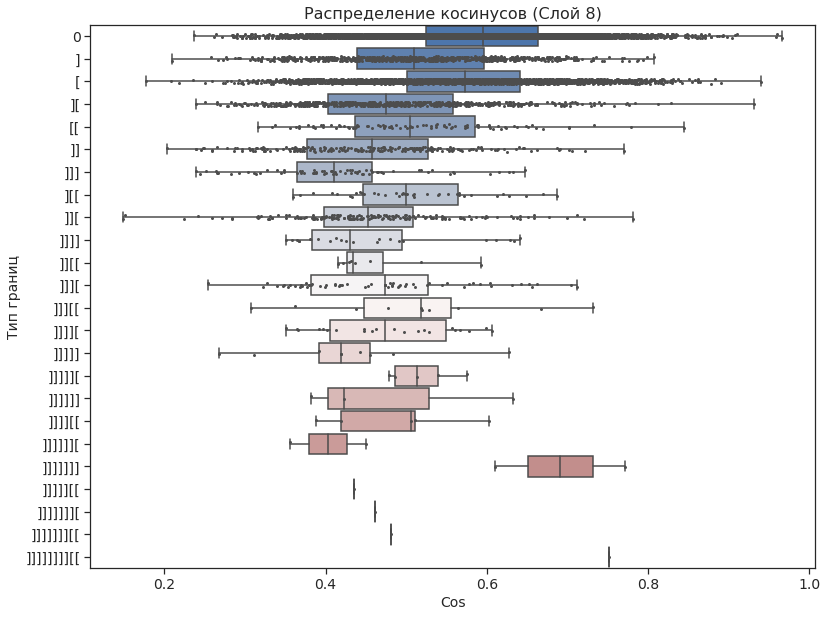

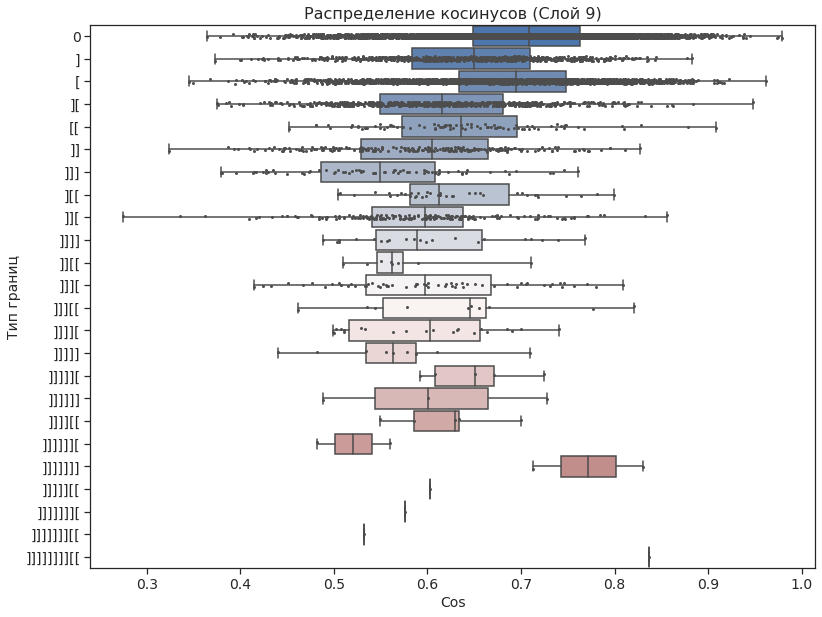

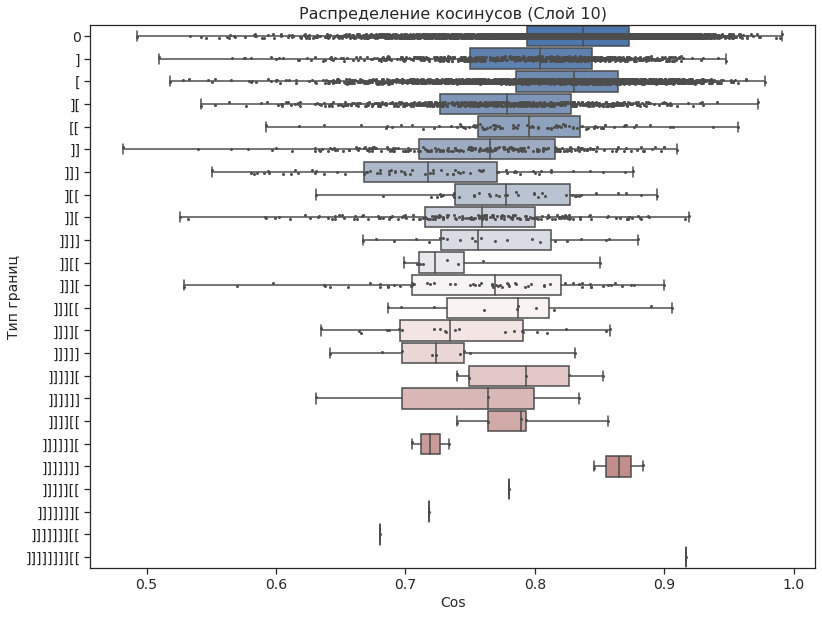

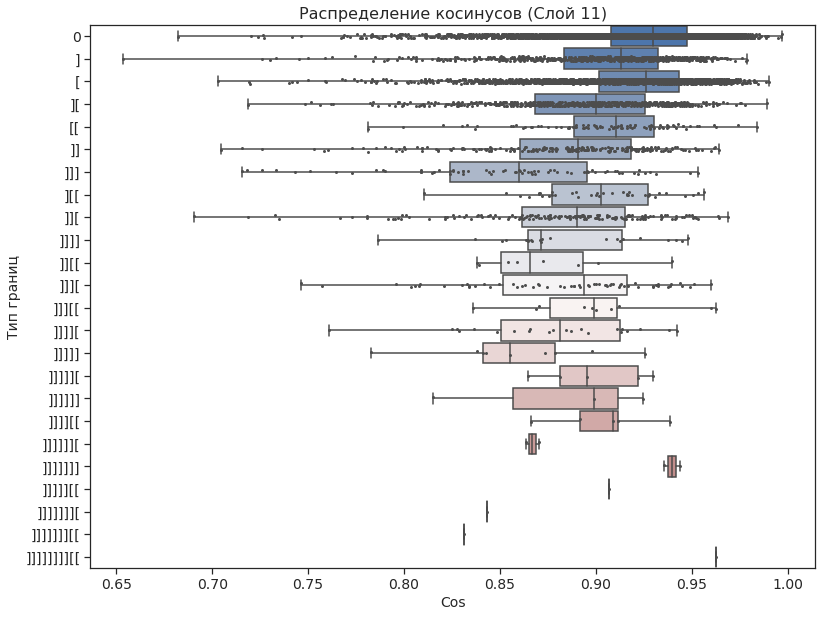

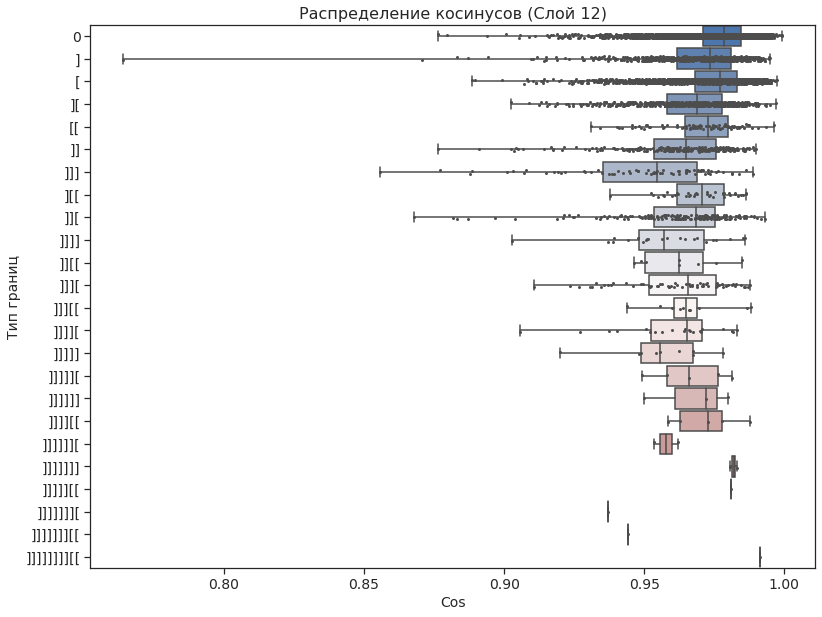

In [20]:

sns.set_theme(style="ticks")

# Создаем 12 графиков (по одному на каждый слой)
for layer in range(12):
    # Преобразуем данные для текущего слоя в DataFrame
    layer_data = []
    for bracket_type, cos_values in all_layers_boundary[layer].items():
        for val in cos_values:
            layer_data.append({'bracket_type': bracket_type, 'cos': val})
    
    if not layer_data:  # если нет данных для этого слоя
        continue
        
    result = pd.DataFrame(layer_data)
    result['bracket_count'] = result['bracket_type'].apply(count_brackets)
    
    # Сортируем данные по количеству скобок
    result = result.sort_values('bracket_count')    
    # Создаем фигуру для текущего слоя
    f, ax = plt.subplots(figsize=(13, 10))
    
    # Boxplot
    sns.boxplot(x="cos", y="bracket_type", data=result,
               whis=[0, 100], width=.9, palette="vlag")
    
    # Stripplot (точечный график поверх boxplot)
    sns.stripplot(x="cos", y="bracket_type", data=result,
                  size=3, color=".3", linewidth=0)
    
    # Настройки осей и заголовка
    plt.xlabel('Cos', fontsize=14)
    plt.ylabel('Тип границ', fontsize=14)
    plt.title(f'Распределение косинусов (Слой {layer+1})', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    # Сохраняем и показываем график
    plt.savefig(f'graphs_linear0_small/boxplot_layer_{layer+1}.png')
    plt.show()

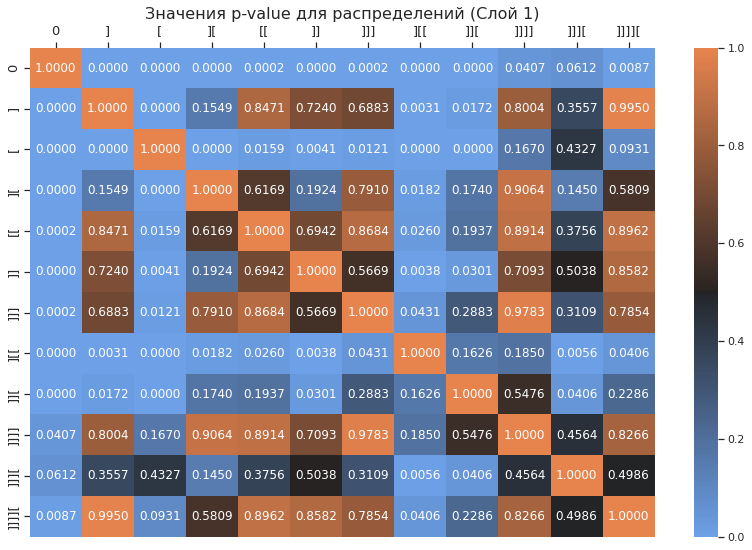

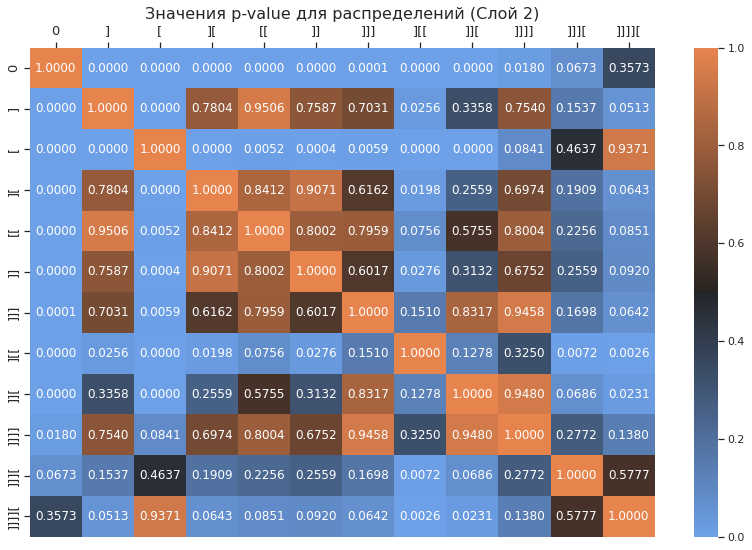

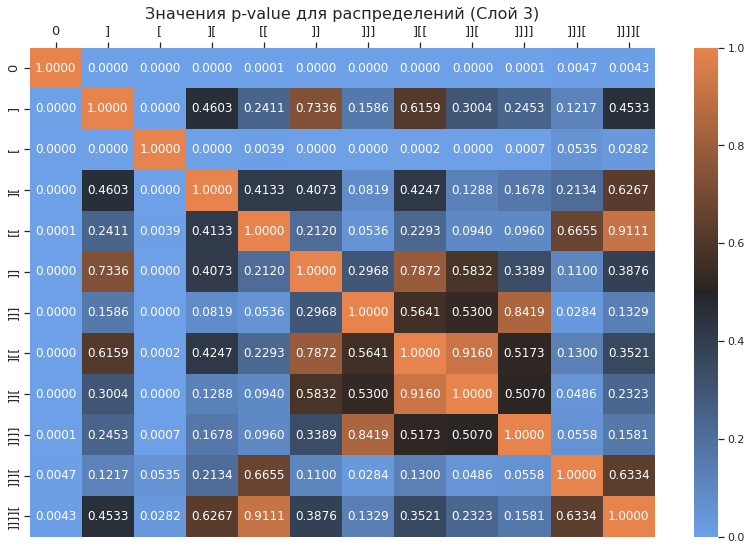

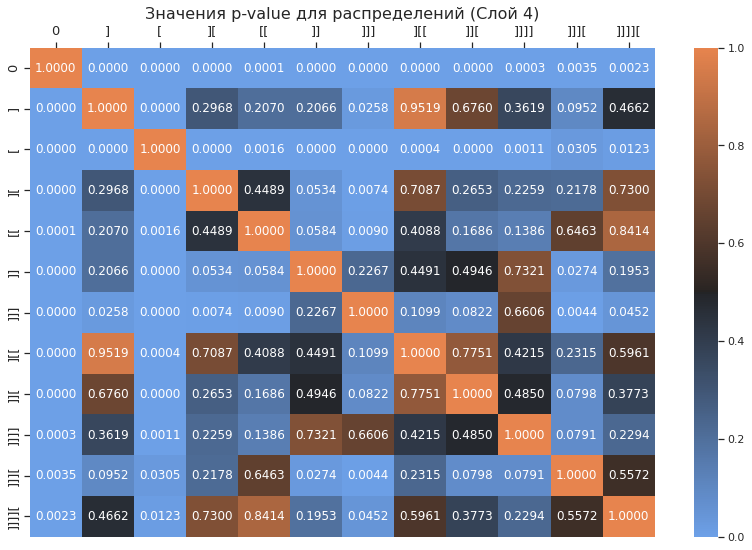

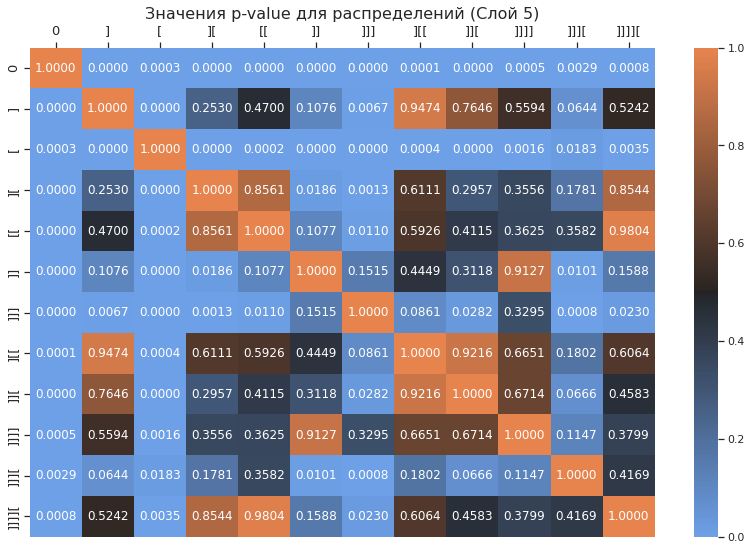

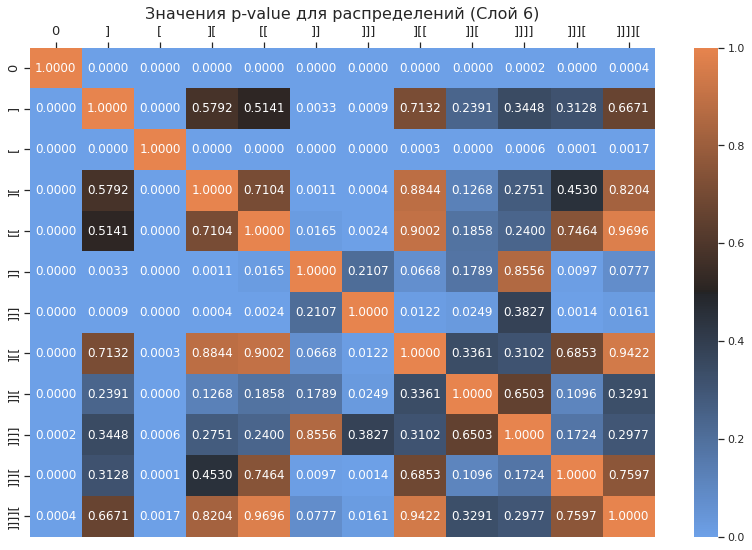

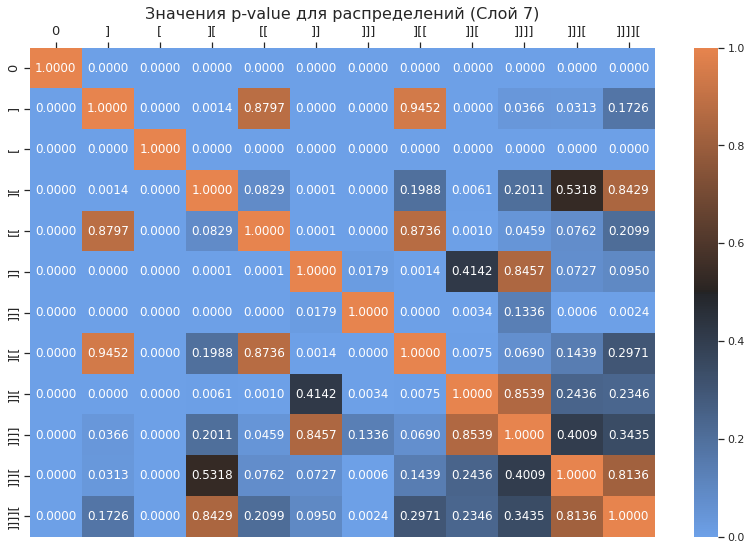

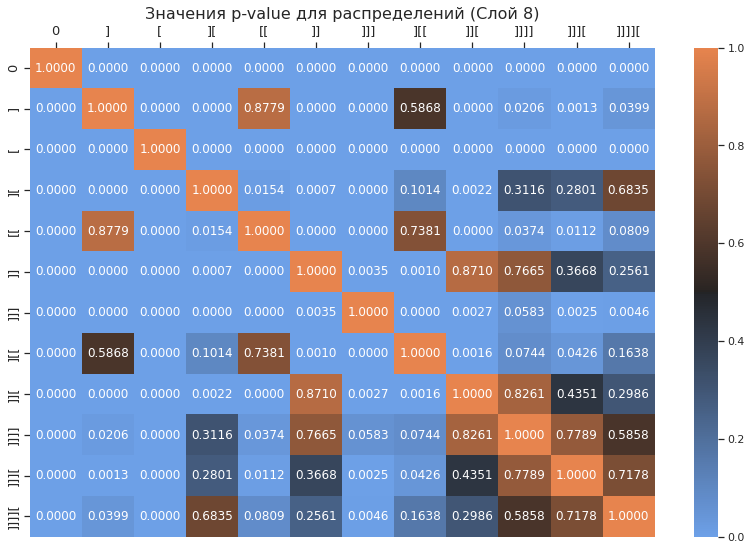

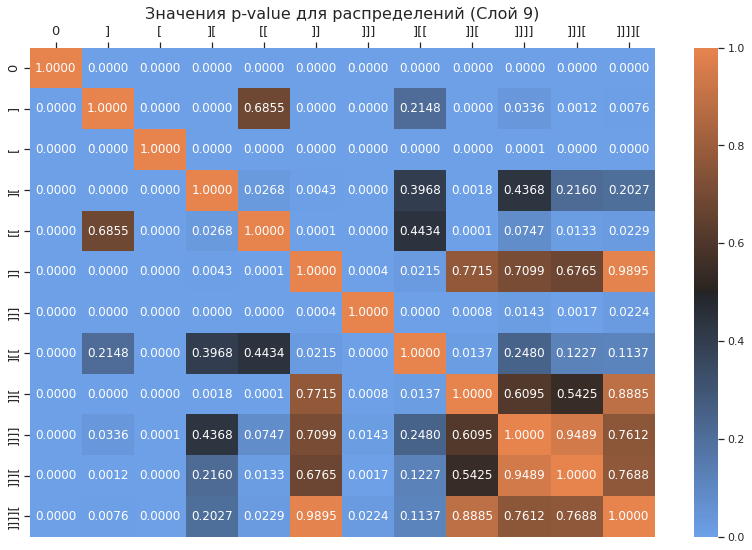

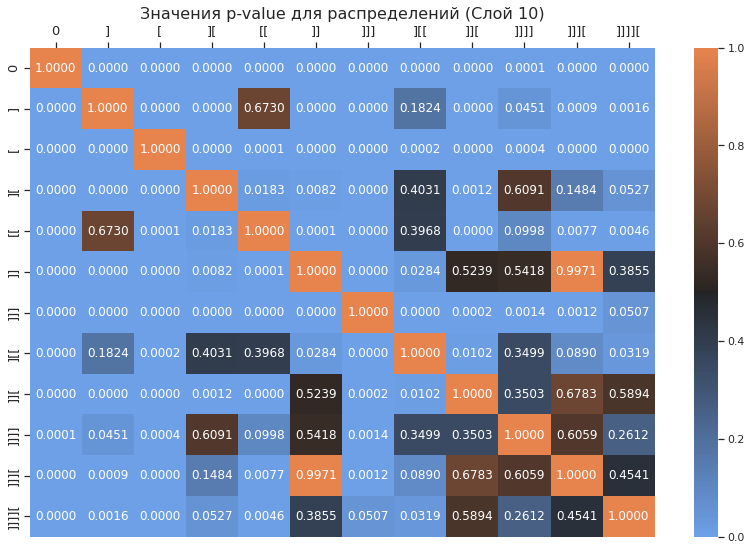

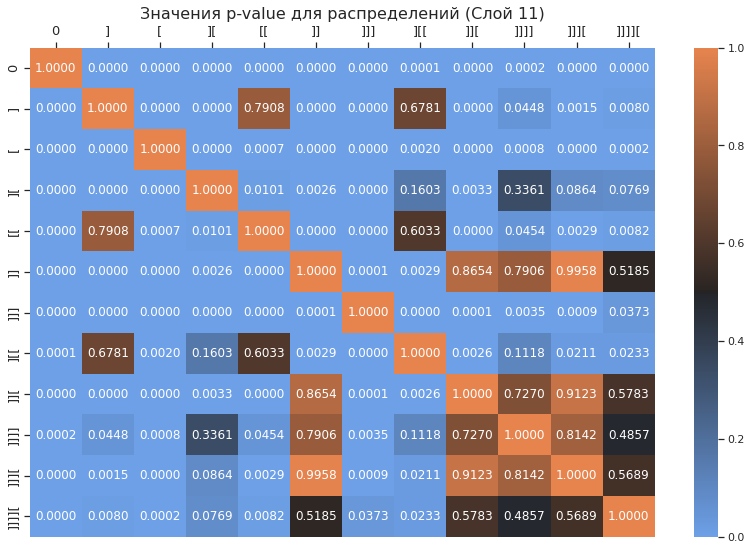

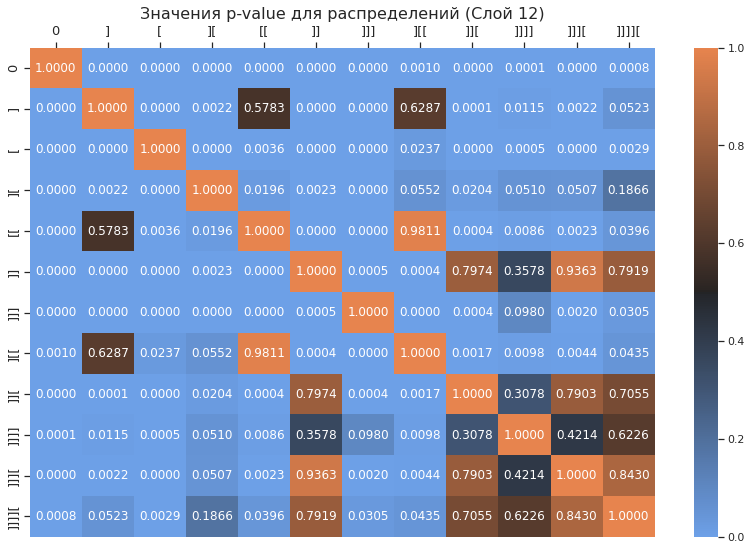

In [21]:
# Создаем heatmap для каждого слоя
for layer in range(12):
    # Подготавливаем данные для текущего слоя
    layer_data = []
    for bracket_type, cos_values in all_layers_boundary[layer].items():
        for val in cos_values:
            layer_data.append({'bracket_type': bracket_type, 'cos': val})
    
    if not layer_data:  # пропускаем слой, если нет данных
        continue
        
    result = pd.DataFrame(layer_data)
    result['bracket_count'] = result['bracket_type'].apply(count_brackets)
    
    # Сортируем данные по количеству скобок
    result = result.sort_values('bracket_count')    
    # Собираем статистику по группам
    inf_for_stats = {}
    for bracket in result.bracket_type.unique():
        group = result[result['bracket_type'] == bracket]
        if len(group['cos']) >= 20:  # только если достаточно данных
            inf_for_stats[bracket] = group['cos']
    
    if not inf_for_stats:  # если нет групп с достаточным количеством данных
        continue
    
    # Вычисляем p-values для всех пар групп
    arr = []
    for k1 in inf_for_stats.keys():
        row = []
        for k2 in inf_for_stats.keys():
            row.append(stats.ttest_ind(a=inf_for_stats[k1], b=inf_for_stats[k2], equal_var=False)[1])
        arr.append(row)
    
    pvalues = np.array(arr)
    table = pd.DataFrame(data=pvalues, index=inf_for_stats.keys(), columns=inf_for_stats.keys())
    
    # Строим heatmap
    plt.figure(figsize=(14, 9))
    ax = sns.heatmap(
        table, 
        annot=True, 
        fmt=".4f", 
        cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
    )
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.title(f'Значения p-value для распределений (Слой {layer+1})', fontsize=16)
    plt.savefig(f'graphs_linear0_small/heatmap_layer_{layer+1}.png')
    plt.show()

In [30]:
# Пример создания словаря
vocab = {'<pad>': 0, '<unk>': 1}
words = set()
for item in new_data:
    text = item[0]
    words.update(text.split())
for idx, word in enumerate(words, start=2):  # Начинаем с 2, так как 0 и 1 уже заняты
    vocab[word] = idx
model_config['vocab_size'] = len(vocab)
print(len(vocab))

18405


In [25]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, hidden_size, pad_idx, dropout):
        super(Embedding, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_idx)
        self.position_embedding = nn.Embedding(512, hidden_size)  # Максимальная длина последовательности
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), dtype=torch.long, device=x.device).unsqueeze(0)
        token_embeddings = self.token_embedding(x)
        position_embeddings = self.position_embedding(positions)
        embeddings = token_embeddings + position_embeddings
        return self.dropout(embeddings)

In [26]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, hidden_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [27]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [28]:
class SublayerConnection(nn.Module):
    def __init__(self, hidden_size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [29]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size, ff_hidden_size, dropout):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(hidden_size, ff_hidden_size)
        self.linear2 = nn.Linear(ff_hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, n_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        assert hidden_size % n_heads == 0
        self.d_k = hidden_size // n_heads
        self.n_heads = n_heads
        self.linear_q = nn.Linear(hidden_size, hidden_size)
        self.linear_k = nn.Linear(hidden_size, hidden_size)
        self.linear_v = nn.Linear(hidden_size, hidden_size)
        self.linear_out = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        q = self.linear_q(q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k = self.linear_k(k).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v = self.linear_v(v).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self.dropout(p_attn)
        x = torch.matmul(p_attn, v)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)
        return self.linear_out(x)

In [23]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, n_heads, ff_hidden_size, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(hidden_size, n_heads, dropout['attention'])
        self.feed_forward = FeedForward(hidden_size, ff_hidden_size, dropout['relu'])
        self.sublayer = nn.ModuleList([SublayerConnection(hidden_size, dropout['residual']) for _ in range(2)])

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [22]:
class Encoder(nn.Module):
    def __init__(self, model_config):
        super(Encoder, self).__init__()
        self.embedding = Embedding(model_config['vocab_size'], model_config['hidden_size'], model_config['pad_idx'], model_config['dropout']['embedding'])
        self.layers = nn.ModuleList([EncoderLayer(model_config['hidden_size'], model_config['n_heads'], model_config['ff_hidden_size'], model_config['dropout']) for _ in range(model_config['n_layers'])])

    def forward(self, x, mask):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, n_heads, ff_hidden_size, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(hidden_size, n_heads, dropout['attention'])
        self.src_attn = MultiHeadAttention(hidden_size, n_heads, dropout['attention'])
        self.feed_forward = FeedForward(hidden_size, ff_hidden_size, dropout['relu'])
        self.sublayer = nn.ModuleList([SublayerConnection(hidden_size, dropout['residual']) for _ in range(3)])

    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [14]:
class Decoder(nn.Module):
    def __init__(self, model_config):
        super(Decoder, self).__init__()
        self.embedding = Embedding(model_config['vocab_size'], model_config['hidden_size'], model_config['pad_idx'], model_config['dropout']['embedding'])
        self.layers = nn.ModuleList([DecoderLayer(model_config['hidden_size'], model_config['n_heads'], model_config['ff_hidden_size'], model_config['dropout']) for _ in range(model_config['n_layers'])])

    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return x

In [15]:
class Transformer(nn.Module):
    def __init__(self, model_config):
        super(Transformer, self).__init__()
        self.encoder = Encoder(model_config)
        self.decoder = Decoder(model_config)

    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encoder(src, src_mask)
        output = self.decoder(tgt, memory, src_mask, tgt_mask)
        return output

In [16]:
class LRScheduler:
    def __init__(self, optimizer, warmup_steps, lr_peak, total_steps):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.lr_peak = lr_peak
        self.total_steps = total_steps
        self.current_step = 0

    def step(self):
        self.current_step += 1
        if self.current_step < self.warmup_steps:
            lr = self.lr_peak * (self.current_step / self.warmup_steps)
        else:
            lr = self.lr_peak * (1 - (self.current_step - self.warmup_steps) / (self.total_steps - self.warmup_steps))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

In [34]:
class TextEncoder:
    def __init__(self, vocab):
        self.vocab = vocab
        self.pad_idx = vocab['<pad>']
        self.unk_idx = vocab['<unk>']

    def encode(self, text):
        return [self.vocab.get(word, self.unk_idx) for word in text.split()]

In [18]:
class SintagrusDataset(Dataset):
    def __init__(self, data, text_encoder, pad_idx):
        self.data = data
        self.text_encoder = text_encoder
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, _ = self.data[idx]
        tokens = self.text_encoder.encode(text)
        return torch.tensor(tokens, dtype=torch.long)

In [19]:
model_config = {
    'n_layers': 12,
    'n_heads': 2,
    'hidden_size': 128,
    'ff_hidden_size': 256,
    'dropout': {
        'embedding': 0.1,
        'attention': 0.1,
        'residual': 0.1,
        'relu': 0.1
    },
    'pad_idx': 0,
    'vocab_size': len(vocab)
}

train_config = {
    'batch_size': 200,
    'n_epochs': 5,
    'lr_scheduler': {
        'type': 'warmup,decay_linear',
        'warmup_steps_part': 0.1,
        'lr_peak': 3e-4,
    }
}
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch, pad_idx):
    """
    Функция для обработки батчей:
    - Дополняет предложения до одинаковой длины с помощью pad_idx.
    - Возвращает тензоры.
    """
    # Дополняем предложения до одинаковой длины
    batch = pad_sequence(batch, batch_first=True, padding_value=pad_idx)
    return batch

In [43]:
# Функция обучения
def train(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)  # (batch_size, sequence_length)
        
        # Проверка целевых значений
        if (batch >= model_config['vocab_size']).any():
            raise ValueError("Найдены индексы, выходящие за пределы словаря.")
        
        # Forward pass
        output = model(batch, batch, None, None)  # (batch_size, sequence_length, vocab_size)
        
        # Reshape output and targets for criterion
        output = output.view(-1, output.size(-1))  # (batch_size * sequence_length, vocab_size)
        targets = batch.view(-1)  # (batch_size * sequence_length)
        
        # Compute loss
        loss = criterion(output, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Основная функция
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Создание словаря
    vocab = {'<pad>': 0, '<unk>': 1}
    words = set()
    for item in new_data:
        text = item[0]
        words.update(text.split())
    for idx, word in enumerate(words, start=2):  # Начинаем с 2, так как 0 и 1 уже заняты
        vocab[word] = idx
    model_config['vocab_size'] = len(vocab)
    
    # Инициализация TextEncoder
    text_encoder = TextEncoder(vocab)
    
    # Датасет и DataLoader
    dataset = SintagrusDataset(new_data, text_encoder, model_config['pad_idx'])
    dataloader = DataLoader(
        dataset,
        batch_size=train_config['batch_size'],
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, model_config['pad_idx'])
    )
    
    # Модель, оптимизатор и критерий
    model = Transformer(model_config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=train_config['lr_scheduler']['lr_peak'])
    total_steps = train_config['n_epochs'] * len(dataloader)
    scheduler = LRScheduler(optimizer, train_config['lr_scheduler']['warmup_steps_part'] * total_steps, train_config['lr_scheduler']['lr_peak'], total_steps)
    criterion = nn.CrossEntropyLoss(ignore_index=model_config['pad_idx'])
    # Проверка выхода модели
    
    # Обучение
    for epoch in range(train_config['n_epochs']):
        loss = train(model, dataloader, optimizer, scheduler, criterion, device)
        print(f'Epoch {epoch+1}, Loss: {loss}')
            
if __name__ == '__main__':
    main()
output = model(batch, batch, None, None)
print(f"Размерность выхода модели: {output.shape}")
print(f"Ожидаемая размерность: (batch_size, sequence_length, vocab_size)")

# Проверка размерностей перед передачей в criterion
output = output.view(-1, output.size(-1))  # (batch_size * sequence_length, vocab_size)
targets = batch.view(-1)  # (batch_size * sequence_length)
print(f"Размерность output: {output.shape}")
print(f"Размерность targets: {targets.shape}")

# Проверка данных на наличие пустых строк или некорректных токенов
for item in new_data:
    text = item[0]
    if not text.strip():  # Проверка на пустые строки
        print(f"Пустая строка в данных: {item}")
    tokens = text_encoder.encode(text)
    if any(token >= len(vocab) for token in tokens):
        print(f"Некорректные индексы в тексте: {text}")
        print(f"Некорректные индексы: {[token for token in tokens if token >= len(vocab)]}")

IndexError: Target 11951 is out of bounds.

In [38]:
# Проверка данных на наличие некорректных индексов
for item in new_data:
    text = item[0]
    tokens = text_encoder.encode(text)
    if any(token >= len(vocab) for token in tokens):
        print(f"Некорректные индексы в тексте: {text}")
        print(f"Некорректные индексы: {[token for token in tokens if token >= len(vocab)]}")

# Проверка размера словаря в модели
print(f"Размер словаря в модели: {model_config['vocab_size']}")
print(f"Реальный размер словаря: {len(vocab)}")

# Обновление vocab_size в model_config, если необходимо
if model_config['vocab_size'] != len(vocab):
    model_config['vocab_size'] = len(vocab)
    print(f"Обновлен vocab_size в model_config: {model_config['vocab_size']}")

Размер словаря в модели: 18405
Реальный размер словаря: 18405


In [39]:
# Проверка выхода модели
output = model(batch, batch, None, None)
print(f"Размерность выхода модели: {output.shape}")
print(f"Ожидаемая размерность: (batch_size, sequence_length, vocab_size)")

# Проверка размерностей перед передачей в criterion
output = output.view(-1, output.size(-1))  # (batch_size * sequence_length, vocab_size)
targets = batch.view(-1)  # (batch_size * sequence_length)
print(f"Размерность output: {output.shape}")
print(f"Размерность targets: {targets.shape}")

# Проверка данных на наличие пустых строк или некорректных токенов
for item in new_data:
    text = item[0]
    if not text.strip():  # Проверка на пустые строки
        print(f"Пустая строка в данных: {item}")
    tokens = text_encoder.encode(text)
    if any(token >= len(vocab) for token in tokens):
        print(f"Некорректные индексы в тексте: {text}")
        print(f"Некорректные индексы: {[token for token in tokens if token >= len(vocab)]}")

NameError: name 'model' is not defined